# Image Captioning using LSTM on Flickr8K dataset

## Downloading Data and Dependencies

In [6]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2
import joblib

In [2]:
## Data Visualization and Preprocessing

In [5]:
import os
print(os.getcwd())

C:\Work\BITS\ImageCoaptioning\Image_Captioning_Pycharm\updated


In [5]:
#converting the text files to pandas dataframe

# Define the folder path
folder_path = r"C:\Work\BITS\ImageCoaptioning\Flickr8k_text"

# Reading the files using the full path
image_tokens = pd.read_csv(f"{folder_path}\\Flickr8k.lemma.token.txt", sep='\t', names=["img_id", "img_caption"])
train_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.trainImages.txt", names=["img_id"])
test_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.testImages.txt", names=["img_id"])
val_image_names = pd.read_csv(f"{folder_path}\\Flickr_8k.devImages.txt", names=["img_id"])


In [7]:
#just checking the number of images in the dataset
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
l=os.listdir(folder_path_images)
print(len(l))

8091


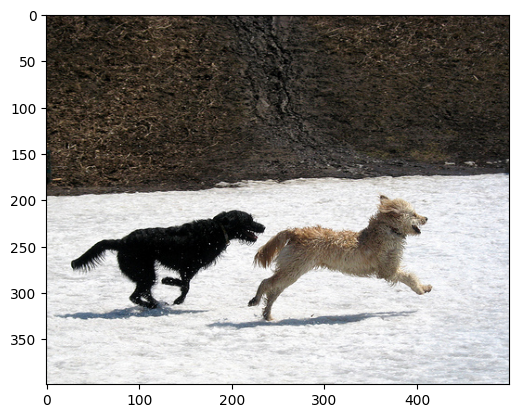

In [8]:
#visualising one of the train images
img=cv2.imread(folder_path_images+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [9]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [10]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [11]:
#head of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [12]:
#head of the train_image_names dataframe
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

### Creating dictionaries to map image_id and their corresponding captions

In [13]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 436.37it/s]


In [14]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.53it/s]


In [15]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.71it/s]


### ResNet50 model for encoding images

In [16]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()
# Serialize and save ResNet50 model
joblib.dump(model, "resnet50_model.joblib")
print("ResNet50 model saved as resnet50_model.joblib")


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

ResNet50 model saved as resnet50_model.joblib


### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [17]:
#extracting image encodings(features) from resnet50 and forming dict train_features
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
path="all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
#  img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|                                                                                                                | 0/6000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|                                                                                                      | 1/6000 [00:01<2:30:56,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  0%|                                                                                                      | 2/6000 [00:01<1:14:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                                                        | 3/6000 [00:01<47:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|                                                                                                        | 4/6000 [00:02<35:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|                                                                                                        | 5/6000 [00:02<28:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  0%|                                                                                                        | 6/6000 [00:02<24:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  0%|                                                                                                        | 7/6000 [00:02<21:34,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  0%|▏                                                                                                       | 8/6000 [00:02<20:08,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  0%|▏                                                                                                       | 9/6000 [00:02<18:52,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|▏                                                                                                      | 10/6000 [00:03<18:11,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|▏                                                                                                      | 11/6000 [00:03<17:09,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  0%|▏                                                                                                      | 12/6000 [00:03<17:05,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  0%|▏                                                                                                      | 13/6000 [00:03<17:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  0%|▏                                                                                                      | 14/6000 [00:03<18:26,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                                                      | 15/6000 [00:03<17:51,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  0%|▎                                                                                                      | 16/6000 [00:04<17:57,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▎                                                                                                      | 17/6000 [00:04<18:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                                                      | 18/6000 [00:04<17:39,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▎                                                                                                      | 19/6000 [00:04<17:23,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  0%|▎                                                                                                      | 20/6000 [00:04<17:08,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                                                      | 21/6000 [00:04<16:59,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|▍                                                                                                      | 22/6000 [00:05<16:51,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▍                                                                                                      | 23/6000 [00:05<16:45,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|▍                                                                                                      | 24/6000 [00:05<16:40,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  0%|▍                                                                                                      | 25/6000 [00:05<16:35,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  0%|▍                                                                                                      | 26/6000 [00:05<16:38,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  0%|▍                                                                                                      | 27/6000 [00:05<18:09,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  0%|▍                                                                                                      | 28/6000 [00:06<17:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|▍                                                                                                      | 29/6000 [00:06<16:55,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  0%|▌                                                                                                      | 30/6000 [00:06<16:12,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▌                                                                                                      | 31/6000 [00:06<15:59,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▌                                                                                                      | 32/6000 [00:06<15:23,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|▌                                                                                                      | 33/6000 [00:06<14:58,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|▌                                                                                                      | 34/6000 [00:07<14:41,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|▌                                                                                                      | 35/6000 [00:07<14:39,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  1%|▌                                                                                                      | 36/6000 [00:07<14:24,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 37/6000 [00:07<14:15,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 38/6000 [00:07<14:38,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|▋                                                                                                      | 39/6000 [00:07<14:27,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 40/6000 [00:07<14:18,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 41/6000 [00:08<14:12,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 42/6000 [00:08<14:11,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▋                                                                                                      | 43/6000 [00:08<14:07,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|▊                                                                                                      | 44/6000 [00:08<14:04,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▊                                                                                                      | 45/6000 [00:08<14:02,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  1%|▊                                                                                                      | 46/6000 [00:08<14:57,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▊                                                                                                      | 47/6000 [00:08<14:39,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  1%|▊                                                                                                      | 48/6000 [00:09<15:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▊                                                                                                      | 49/6000 [00:09<15:00,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|▊                                                                                                      | 50/6000 [00:09<14:37,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 51/6000 [00:09<14:53,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 52/6000 [00:09<14:36,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 53/6000 [00:09<14:51,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 54/6000 [00:09<14:34,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  1%|▉                                                                                                      | 55/6000 [00:10<14:26,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 56/6000 [00:10<14:45,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  1%|▉                                                                                                      | 57/6000 [00:10<14:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▉                                                                                                      | 58/6000 [00:10<14:47,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█                                                                                                      | 59/6000 [00:10<14:32,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█                                                                                                      | 60/6000 [00:10<14:20,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█                                                                                                      | 61/6000 [00:10<14:40,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█                                                                                                      | 62/6000 [00:11<14:26,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█                                                                                                      | 63/6000 [00:11<14:16,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  1%|█                                                                                                      | 64/6000 [00:11<14:36,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|█                                                                                                      | 65/6000 [00:11<14:24,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|█▏                                                                                                     | 66/6000 [00:11<14:15,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  1%|█▏                                                                                                     | 67/6000 [00:11<14:36,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▏                                                                                                     | 68/6000 [00:12<14:23,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▏                                                                                                     | 69/6000 [00:12<14:42,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▏                                                                                                     | 70/6000 [00:12<14:27,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▏                                                                                                     | 71/6000 [00:12<14:17,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▏                                                                                                     | 72/6000 [00:12<14:37,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▎                                                                                                     | 73/6000 [00:12<14:24,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|█▎                                                                                                     | 74/6000 [00:12<14:15,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▎                                                                                                     | 75/6000 [00:13<14:36,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  1%|█▎                                                                                                     | 76/6000 [00:13<14:23,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  1%|█▎                                                                                                     | 77/6000 [00:13<14:36,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▎                                                                                                     | 78/6000 [00:13<14:29,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  1%|█▎                                                                                                     | 79/6000 [00:13<14:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  1%|█▎                                                                                                     | 80/6000 [00:13<15:11,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|█▍                                                                                                     | 81/6000 [00:13<15:58,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|█▍                                                                                                     | 82/6000 [00:14<16:42,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  1%|█▍                                                                                                     | 83/6000 [00:14<16:12,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|█▍                                                                                                     | 84/6000 [00:14<16:41,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|█▍                                                                                                     | 85/6000 [00:14<16:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|█▍                                                                                                     | 86/6000 [00:14<15:59,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|█▍                                                                                                     | 87/6000 [00:14<16:31,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  1%|█▌                                                                                                     | 88/6000 [00:15<18:42,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  1%|█▌                                                                                                     | 89/6000 [00:15<18:49,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|█▌                                                                                                     | 90/6000 [00:15<17:25,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  2%|█▌                                                                                                     | 91/6000 [00:15<16:35,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  2%|█▌                                                                                                     | 92/6000 [00:15<16:02,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|█▌                                                                                                     | 93/6000 [00:16<15:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▌                                                                                                     | 94/6000 [00:16<16:33,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  2%|█▋                                                                                                     | 95/6000 [00:16<16:41,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▋                                                                                                     | 96/6000 [00:16<15:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|█▋                                                                                                     | 97/6000 [00:16<15:19,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▋                                                                                                     | 98/6000 [00:16<15:26,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  2%|█▋                                                                                                     | 99/6000 [00:16<15:31,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  2%|█▋                                                                                                    | 100/6000 [00:17<15:08,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▋                                                                                                    | 101/6000 [00:17<14:44,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|█▋                                                                                                    | 102/6000 [00:17<14:30,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▊                                                                                                    | 103/6000 [00:17<14:45,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  2%|█▊                                                                                                    | 104/6000 [00:17<14:49,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|█▊                                                                                                    | 105/6000 [00:17<15:48,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|█▊                                                                                                    | 106/6000 [00:18<15:53,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▊                                                                                                    | 107/6000 [00:18<15:11,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  2%|█▊                                                                                                    | 108/6000 [00:18<15:14,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▊                                                                                                    | 109/6000 [00:18<14:53,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▊                                                                                                    | 110/6000 [00:18<15:01,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▉                                                                                                    | 111/6000 [00:18<15:35,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▉                                                                                                    | 112/6000 [00:19<15:56,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|█▉                                                                                                    | 113/6000 [00:19<15:47,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▉                                                                                                    | 114/6000 [00:19<16:11,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▉                                                                                                    | 115/6000 [00:19<16:36,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|█▉                                                                                                    | 116/6000 [00:19<16:23,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|█▉                                                                                                    | 117/6000 [00:19<16:32,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|██                                                                                                    | 118/6000 [00:20<16:24,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|██                                                                                                    | 119/6000 [00:20<16:07,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  2%|██                                                                                                    | 120/6000 [00:20<15:45,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██                                                                                                    | 121/6000 [00:20<15:09,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|██                                                                                                    | 122/6000 [00:20<14:44,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|██                                                                                                    | 123/6000 [00:20<15:56,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  2%|██                                                                                                    | 124/6000 [00:20<16:24,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|██▏                                                                                                   | 125/6000 [00:21<15:54,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|██▏                                                                                                   | 126/6000 [00:21<16:26,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|██▏                                                                                                   | 127/6000 [00:21<16:46,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|██▏                                                                                                   | 128/6000 [00:21<17:56,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  2%|██▏                                                                                                   | 129/6000 [00:21<19:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|██▏                                                                                                   | 130/6000 [00:22<18:39,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|██▏                                                                                                   | 131/6000 [00:22<18:17,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|██▏                                                                                                   | 132/6000 [00:22<17:41,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|██▎                                                                                                   | 133/6000 [00:22<17:42,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|██▎                                                                                                   | 134/6000 [00:22<17:56,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|██▎                                                                                                   | 135/6000 [00:23<18:29,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|██▎                                                                                                   | 136/6000 [00:23<18:22,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  2%|██▎                                                                                                   | 137/6000 [00:23<17:55,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  2%|██▎                                                                                                   | 138/6000 [00:23<17:13,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▎                                                                                                   | 139/6000 [00:23<17:05,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▍                                                                                                   | 140/6000 [00:23<16:59,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|██▍                                                                                                   | 141/6000 [00:24<17:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|██▍                                                                                                   | 142/6000 [00:24<17:34,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▍                                                                                                   | 143/6000 [00:24<17:20,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▍                                                                                                   | 144/6000 [00:24<17:09,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▍                                                                                                   | 145/6000 [00:24<17:30,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▍                                                                                                   | 146/6000 [00:24<17:16,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|██▍                                                                                                   | 147/6000 [00:25<16:58,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▌                                                                                                   | 148/6000 [00:25<17:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  2%|██▌                                                                                                   | 149/6000 [00:25<17:17,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  2%|██▌                                                                                                   | 150/6000 [00:25<17:07,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▌                                                                                                   | 151/6000 [00:25<17:00,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▌                                                                                                   | 152/6000 [00:26<16:56,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▌                                                                                                   | 153/6000 [00:26<17:12,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▌                                                                                                   | 154/6000 [00:26<17:04,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▋                                                                                                   | 155/6000 [00:26<16:58,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|██▋                                                                                                   | 156/6000 [00:26<16:53,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▋                                                                                                   | 157/6000 [00:26<16:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▋                                                                                                   | 158/6000 [00:27<16:48,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  3%|██▋                                                                                                   | 159/6000 [00:27<16:47,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▋                                                                                                   | 160/6000 [00:27<16:38,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▋                                                                                                   | 161/6000 [00:27<16:30,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 162/6000 [00:27<16:33,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 163/6000 [00:27<16:36,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  3%|██▊                                                                                                   | 164/6000 [00:28<16:46,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 165/6000 [00:28<16:27,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 166/6000 [00:28<16:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 167/6000 [00:28<16:26,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|██▊                                                                                                   | 168/6000 [00:28<16:58,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▊                                                                                                   | 169/6000 [00:28<17:20,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 170/6000 [00:29<17:35,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 171/6000 [00:29<18:14,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▉                                                                                                   | 172/6000 [00:29<17:31,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 173/6000 [00:29<17:15,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 174/6000 [00:29<17:05,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 175/6000 [00:30<16:57,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▉                                                                                                   | 176/6000 [00:30<17:06,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 177/6000 [00:30<16:58,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 178/6000 [00:30<16:53,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 179/6000 [00:30<16:49,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 180/6000 [00:30<16:46,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 181/6000 [00:31<16:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 182/6000 [00:31<16:42,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███                                                                                                   | 183/6000 [00:31<16:41,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 184/6000 [00:31<16:28,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 185/6000 [00:31<16:31,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 186/6000 [00:31<16:33,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|███▏                                                                                                  | 187/6000 [00:32<16:47,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 188/6000 [00:32<16:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 189/6000 [00:32<16:42,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 190/6000 [00:32<16:13,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▏                                                                                                  | 191/6000 [00:32<16:48,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▎                                                                                                  | 192/6000 [00:32<16:45,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  3%|███▎                                                                                                  | 193/6000 [00:33<16:18,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▎                                                                                                  | 194/6000 [00:33<16:24,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|███▎                                                                                                  | 195/6000 [00:33<16:39,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▎                                                                                                  | 196/6000 [00:33<16:38,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|███▎                                                                                                  | 197/6000 [00:33<16:38,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▎                                                                                                  | 198/6000 [00:33<16:37,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  3%|███▍                                                                                                  | 199/6000 [00:34<16:25,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▍                                                                                                  | 200/6000 [00:34<16:28,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▍                                                                                                  | 201/6000 [00:34<16:31,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▍                                                                                                  | 202/6000 [00:34<16:32,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▍                                                                                                  | 203/6000 [00:34<16:33,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▍                                                                                                  | 204/6000 [00:35<16:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  3%|███▍                                                                                                  | 205/6000 [00:35<16:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|███▌                                                                                                  | 206/6000 [00:35<16:34,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|███▌                                                                                                  | 207/6000 [00:35<16:49,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|███▌                                                                                                  | 208/6000 [00:35<16:45,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|███▌                                                                                                  | 209/6000 [00:35<16:42,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▌                                                                                                  | 210/6000 [00:36<16:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▌                                                                                                  | 211/6000 [00:36<16:19,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|███▌                                                                                                  | 212/6000 [00:36<16:51,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▌                                                                                                  | 213/6000 [00:36<17:13,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▋                                                                                                  | 214/6000 [00:36<17:01,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|███▋                                                                                                  | 215/6000 [00:36<18:43,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|███▋                                                                                                  | 216/6000 [00:37<18:55,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  4%|███▋                                                                                                  | 217/6000 [00:37<20:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  4%|███▋                                                                                                  | 218/6000 [00:37<21:45,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  4%|███▋                                                                                                  | 219/6000 [00:38<25:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███▋                                                                                                  | 220/6000 [00:38<24:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███▊                                                                                                  | 221/6000 [00:38<23:44,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███▊                                                                                                  | 222/6000 [00:38<22:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  4%|███▊                                                                                                  | 223/6000 [00:38<23:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  4%|███▊                                                                                                  | 224/6000 [00:39<22:41,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|███▊                                                                                                  | 225/6000 [00:39<21:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|███▊                                                                                                  | 226/6000 [00:39<20:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|███▊                                                                                                  | 227/6000 [00:39<20:54,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  4%|███▉                                                                                                  | 228/6000 [00:40<20:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  4%|███▉                                                                                                  | 229/6000 [00:40<20:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  4%|███▉                                                                                                  | 230/6000 [00:40<18:54,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▉                                                                                                  | 231/6000 [00:40<18:38,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|███▉                                                                                                  | 232/6000 [00:40<18:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▉                                                                                                  | 233/6000 [00:40<18:05,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▉                                                                                                  | 234/6000 [00:41<17:45,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|███▉                                                                                                  | 235/6000 [00:41<17:20,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████                                                                                                  | 236/6000 [00:41<16:38,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|████                                                                                                  | 237/6000 [00:41<16:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████                                                                                                  | 238/6000 [00:41<16:43,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████                                                                                                  | 239/6000 [00:41<16:39,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  4%|████                                                                                                  | 240/6000 [00:42<16:16,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████                                                                                                  | 241/6000 [00:42<16:47,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████                                                                                                  | 242/6000 [00:42<16:14,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 243/6000 [00:42<16:19,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 244/6000 [00:42<16:22,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 245/6000 [00:42<16:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 246/6000 [00:43<16:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 247/6000 [00:43<16:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▏                                                                                                 | 248/6000 [00:43<16:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  4%|████▏                                                                                                 | 249/6000 [00:43<16:21,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 250/6000 [00:43<16:23,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 251/6000 [00:44<16:24,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|████▎                                                                                                 | 252/6000 [00:44<16:10,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 253/6000 [00:44<16:15,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 254/6000 [00:44<16:18,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 255/6000 [00:44<16:48,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 256/6000 [00:44<16:41,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▎                                                                                                 | 257/6000 [00:45<17:10,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  4%|████▍                                                                                                 | 258/6000 [00:45<17:12,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▍                                                                                                 | 259/6000 [00:45<17:25,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|████▍                                                                                                 | 260/6000 [00:45<17:04,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▍                                                                                                 | 261/6000 [00:45<16:52,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  4%|████▍                                                                                                 | 262/6000 [00:45<16:44,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  4%|████▍                                                                                                 | 263/6000 [00:46<16:15,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▍                                                                                                 | 264/6000 [00:46<16:18,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▌                                                                                                 | 265/6000 [00:46<16:20,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▌                                                                                                 | 266/6000 [00:46<16:21,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  4%|████▌                                                                                                 | 267/6000 [00:46<16:22,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▌                                                                                                 | 268/6000 [00:46<16:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|████▌                                                                                                 | 269/6000 [00:47<16:22,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|████▌                                                                                                 | 270/6000 [00:47<16:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▌                                                                                                 | 271/6000 [00:47<16:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  5%|████▌                                                                                                 | 272/6000 [00:47<16:22,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▋                                                                                                 | 273/6000 [00:47<16:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|████▋                                                                                                 | 274/6000 [00:47<16:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▋                                                                                                 | 275/6000 [00:48<16:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▋                                                                                                 | 276/6000 [00:48<15:57,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▋                                                                                                 | 277/6000 [00:48<16:04,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▋                                                                                                 | 278/6000 [00:48<16:10,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|████▋                                                                                                 | 279/6000 [00:48<16:13,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|████▊                                                                                                 | 280/6000 [00:49<16:16,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▊                                                                                                 | 281/6000 [00:49<16:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▊                                                                                                 | 282/6000 [00:49<15:52,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▊                                                                                                 | 283/6000 [00:49<16:01,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  5%|████▊                                                                                                 | 284/6000 [00:49<16:08,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▊                                                                                                 | 285/6000 [00:49<16:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▊                                                                                                 | 286/6000 [00:50<16:15,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  5%|████▉                                                                                                 | 287/6000 [00:50<16:16,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▉                                                                                                 | 288/6000 [00:50<16:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▉                                                                                                 | 289/6000 [00:50<16:19,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▉                                                                                                 | 290/6000 [00:50<16:19,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▉                                                                                                 | 291/6000 [00:50<16:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|████▉                                                                                                 | 292/6000 [00:51<16:25,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|████▉                                                                                                 | 293/6000 [00:51<15:52,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▉                                                                                                 | 294/6000 [00:51<16:00,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 295/6000 [00:51<16:23,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 296/6000 [00:51<16:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 297/6000 [00:51<16:09,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  5%|█████                                                                                                 | 298/6000 [00:52<16:11,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 299/6000 [00:52<16:13,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 300/6000 [00:52<16:15,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████                                                                                                 | 301/6000 [00:52<15:49,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▏                                                                                                | 302/6000 [00:52<15:58,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▏                                                                                                | 303/6000 [00:52<16:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  5%|█████▏                                                                                                | 304/6000 [00:53<16:10,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|█████▏                                                                                                | 305/6000 [00:53<16:11,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▏                                                                                                | 306/6000 [00:53<15:47,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|█████▏                                                                                                | 307/6000 [00:53<16:09,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▏                                                                                                | 308/6000 [00:53<16:00,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|█████▎                                                                                                | 309/6000 [00:53<15:39,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  5%|█████▎                                                                                                | 310/6000 [00:54<15:49,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▎                                                                                                | 311/6000 [00:54<15:57,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|█████▎                                                                                                | 312/6000 [00:54<16:03,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▎                                                                                                | 313/6000 [00:54<15:40,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▎                                                                                                | 314/6000 [00:54<15:51,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▎                                                                                                | 315/6000 [00:54<15:59,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▎                                                                                                | 316/6000 [00:55<16:03,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 317/6000 [00:55<16:34,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 318/6000 [00:55<16:02,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 319/6000 [00:55<16:10,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 320/6000 [00:55<15:45,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 321/6000 [00:55<15:54,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  5%|█████▍                                                                                                | 322/6000 [00:56<15:57,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▍                                                                                                | 323/6000 [00:56<16:02,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  5%|█████▌                                                                                                | 324/6000 [00:56<16:06,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▌                                                                                                | 325/6000 [00:56<16:08,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▌                                                                                                | 326/6000 [00:56<15:43,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▌                                                                                                | 327/6000 [00:56<15:53,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  5%|█████▌                                                                                                | 328/6000 [00:57<15:58,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|█████▌                                                                                                | 329/6000 [00:57<16:03,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▌                                                                                                | 330/6000 [00:57<15:39,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|█████▋                                                                                                | 331/6000 [00:57<16:00,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▋                                                                                                | 332/6000 [00:57<16:04,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▋                                                                                                | 333/6000 [00:57<16:06,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|█████▋                                                                                                | 334/6000 [00:58<15:58,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|█████▋                                                                                                | 335/6000 [00:58<15:36,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▋                                                                                                | 336/6000 [00:58<15:47,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▋                                                                                                | 337/6000 [00:58<15:55,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|█████▋                                                                                                | 338/6000 [00:58<16:00,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▊                                                                                                | 339/6000 [00:58<15:37,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  6%|█████▊                                                                                                | 340/6000 [00:59<15:49,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▊                                                                                                | 341/6000 [00:59<15:55,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▊                                                                                                | 342/6000 [00:59<16:01,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  6%|█████▊                                                                                                | 343/6000 [00:59<16:09,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▊                                                                                                | 344/6000 [00:59<15:43,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▊                                                                                                | 345/6000 [00:59<15:51,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|█████▉                                                                                                | 346/6000 [01:00<15:52,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▉                                                                                                | 347/6000 [01:00<15:58,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▉                                                                                                | 348/6000 [01:00<15:35,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▉                                                                                                | 349/6000 [01:00<15:46,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████▉                                                                                                | 350/6000 [01:00<15:53,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|█████▉                                                                                                | 351/6000 [01:01<15:58,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  6%|█████▉                                                                                                | 352/6000 [01:01<16:00,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████                                                                                                | 353/6000 [01:01<16:03,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████                                                                                                | 354/6000 [01:01<15:38,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|██████                                                                                                | 355/6000 [01:01<15:56,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████                                                                                                | 356/6000 [01:01<16:00,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████                                                                                                | 357/6000 [01:02<15:36,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  6%|██████                                                                                                | 358/6000 [01:02<15:39,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████                                                                                                | 359/6000 [01:02<15:48,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████                                                                                                | 360/6000 [01:02<15:54,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▏                                                                                               | 361/6000 [01:02<15:32,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▏                                                                                               | 362/6000 [01:02<15:43,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████▏                                                                                               | 363/6000 [01:03<15:50,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  6%|██████▏                                                                                               | 364/6000 [01:03<15:55,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▏                                                                                               | 365/6000 [01:03<15:32,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▏                                                                                               | 366/6000 [01:03<15:43,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  6%|██████▏                                                                                               | 367/6000 [01:03<15:33,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▎                                                                                               | 368/6000 [01:03<15:43,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▎                                                                                               | 369/6000 [01:04<15:24,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  6%|██████▎                                                                                               | 370/6000 [01:04<15:54,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▎                                                                                               | 371/6000 [01:04<15:31,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▎                                                                                               | 372/6000 [01:04<15:42,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▎                                                                                               | 373/6000 [01:04<15:49,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████▎                                                                                               | 374/6000 [01:04<15:54,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▍                                                                                               | 375/6000 [01:05<15:31,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|██████▍                                                                                               | 376/6000 [01:05<15:42,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▍                                                                                               | 377/6000 [01:05<15:49,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████▍                                                                                               | 378/6000 [01:05<15:54,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  6%|██████▍                                                                                               | 379/6000 [01:05<15:41,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████▍                                                                                               | 380/6000 [01:05<15:22,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▍                                                                                               | 381/6000 [01:06<15:35,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  6%|██████▍                                                                                               | 382/6000 [01:06<15:33,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 383/6000 [01:06<15:42,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 384/6000 [01:06<15:49,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 385/6000 [01:06<16:51,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 386/6000 [01:06<16:59,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 387/6000 [01:07<17:09,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|██████▌                                                                                               | 388/6000 [01:07<16:50,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|██████▌                                                                                               | 389/6000 [01:07<16:36,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  6%|██████▋                                                                                               | 390/6000 [01:07<16:26,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|██████▋                                                                                               | 391/6000 [01:07<16:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▋                                                                                               | 392/6000 [01:07<16:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  7%|██████▋                                                                                               | 393/6000 [01:08<15:51,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|██████▋                                                                                               | 394/6000 [01:08<15:55,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▋                                                                                               | 395/6000 [01:08<15:57,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▋                                                                                               | 396/6000 [01:08<15:32,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▋                                                                                               | 397/6000 [01:08<15:41,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▊                                                                                               | 398/6000 [01:08<15:47,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|██████▊                                                                                               | 399/6000 [01:09<15:52,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▊                                                                                               | 400/6000 [01:09<15:55,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▊                                                                                               | 401/6000 [01:09<15:57,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|██████▊                                                                                               | 402/6000 [01:09<15:32,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  7%|██████▊                                                                                               | 403/6000 [01:09<15:55,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  7%|██████▊                                                                                               | 404/6000 [01:10<16:49,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  7%|██████▉                                                                                               | 405/6000 [01:10<18:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|██████▉                                                                                               | 406/6000 [01:10<18:46,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|██████▉                                                                                               | 407/6000 [01:10<18:23,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▉                                                                                               | 408/6000 [01:10<18:06,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|██████▉                                                                                               | 409/6000 [01:11<17:28,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  7%|██████▉                                                                                               | 410/6000 [01:11<17:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|██████▉                                                                                               | 411/6000 [01:11<16:43,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████                                                                                               | 412/6000 [01:11<16:30,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|███████                                                                                               | 413/6000 [01:11<16:31,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████                                                                                               | 414/6000 [01:11<16:01,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████                                                                                               | 415/6000 [01:12<16:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  7%|███████                                                                                               | 416/6000 [01:12<16:59,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|███████                                                                                               | 417/6000 [01:12<17:07,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████                                                                                               | 418/6000 [01:12<16:46,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████                                                                                               | 419/6000 [01:12<16:32,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▏                                                                                              | 420/6000 [01:12<16:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  7%|███████▏                                                                                              | 421/6000 [01:13<16:14,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▏                                                                                              | 422/6000 [01:13<16:09,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▏                                                                                              | 423/6000 [01:13<16:05,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▏                                                                                              | 424/6000 [01:13<16:03,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  7%|███████▏                                                                                              | 425/6000 [01:13<15:53,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|███████▏                                                                                              | 426/6000 [01:13<15:54,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  7%|███████▎                                                                                              | 427/6000 [01:14<15:38,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▎                                                                                              | 428/6000 [01:14<15:44,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|███████▎                                                                                              | 429/6000 [01:14<15:48,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▎                                                                                              | 430/6000 [01:14<15:24,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▎                                                                                              | 431/6000 [01:14<15:34,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▎                                                                                              | 432/6000 [01:14<15:40,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▎                                                                                              | 433/6000 [01:15<15:45,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▍                                                                                              | 434/6000 [01:15<15:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▍                                                                                              | 435/6000 [01:15<15:51,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|███████▍                                                                                              | 436/6000 [01:15<15:52,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  7%|███████▍                                                                                              | 437/6000 [01:15<15:45,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▍                                                                                              | 438/6000 [01:16<15:22,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|███████▍                                                                                              | 439/6000 [01:16<15:40,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|███████▍                                                                                              | 440/6000 [01:16<15:18,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▍                                                                                              | 441/6000 [01:16<15:29,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  7%|███████▌                                                                                              | 442/6000 [01:16<15:36,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▌                                                                                              | 443/6000 [01:16<15:16,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▌                                                                                              | 444/6000 [01:17<15:27,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|███████▌                                                                                              | 445/6000 [01:17<15:35,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▌                                                                                              | 446/6000 [01:17<15:41,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▌                                                                                              | 447/6000 [01:17<15:45,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|███████▌                                                                                              | 448/6000 [01:17<15:47,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|███████▋                                                                                              | 449/6000 [01:17<15:44,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▋                                                                                              | 450/6000 [01:18<15:47,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▋                                                                                              | 451/6000 [01:18<15:54,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  8%|███████▋                                                                                              | 452/6000 [01:18<15:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▋                                                                                              | 453/6000 [01:18<15:27,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▋                                                                                              | 454/6000 [01:18<15:34,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|███████▋                                                                                              | 455/6000 [01:18<15:40,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▊                                                                                              | 456/6000 [01:19<15:17,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  8%|███████▊                                                                                              | 457/6000 [01:19<15:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▊                                                                                              | 458/6000 [01:19<15:26,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▊                                                                                              | 459/6000 [01:19<16:00,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▊                                                                                              | 460/6000 [01:19<15:31,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  8%|███████▊                                                                                              | 461/6000 [01:19<15:34,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|███████▊                                                                                              | 462/6000 [01:20<15:58,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▊                                                                                              | 463/6000 [01:20<15:41,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 464/6000 [01:20<15:44,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 465/6000 [01:20<15:20,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 466/6000 [01:20<15:29,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 467/6000 [01:20<15:35,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 468/6000 [01:21<15:40,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 469/6000 [01:21<15:43,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███████▉                                                                                              | 470/6000 [01:21<15:45,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████                                                                                              | 471/6000 [01:21<15:46,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████                                                                                              | 472/6000 [01:21<15:47,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|████████                                                                                              | 473/6000 [01:21<16:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|████████                                                                                              | 474/6000 [01:22<16:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|████████                                                                                              | 475/6000 [01:22<16:13,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████                                                                                              | 476/6000 [01:22<15:57,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████                                                                                              | 477/6000 [01:22<15:54,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  8%|████████▏                                                                                             | 478/6000 [01:22<16:45,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▏                                                                                             | 479/6000 [01:23<16:54,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▏                                                                                             | 480/6000 [01:23<16:57,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▏                                                                                             | 481/6000 [01:23<16:36,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▏                                                                                             | 482/6000 [01:23<16:47,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▏                                                                                             | 483/6000 [01:23<16:29,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  8%|████████▏                                                                                             | 484/6000 [01:23<16:15,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  8%|████████▏                                                                                             | 485/6000 [01:24<17:52,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▎                                                                                             | 486/6000 [01:24<17:40,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▎                                                                                             | 487/6000 [01:24<17:32,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|████████▎                                                                                             | 488/6000 [01:24<17:10,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  8%|████████▎                                                                                             | 489/6000 [01:24<17:45,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|████████▎                                                                                             | 490/6000 [01:25<17:17,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▎                                                                                             | 491/6000 [01:25<16:49,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▎                                                                                             | 492/6000 [01:25<16:30,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  8%|████████▍                                                                                             | 493/6000 [01:25<17:08,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▍                                                                                             | 494/6000 [01:25<17:09,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▍                                                                                             | 495/6000 [01:26<17:10,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  8%|████████▍                                                                                             | 496/6000 [01:26<16:44,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|████████▍                                                                                             | 497/6000 [01:26<17:44,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▍                                                                                             | 498/6000 [01:26<17:35,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▍                                                                                             | 499/6000 [01:26<17:02,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▌                                                                                             | 500/6000 [01:26<16:38,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  8%|████████▌                                                                                             | 501/6000 [01:27<16:47,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▌                                                                                             | 502/6000 [01:27<16:54,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▌                                                                                             | 503/6000 [01:27<16:33,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|████████▌                                                                                             | 504/6000 [01:27<16:18,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|████████▌                                                                                             | 505/6000 [01:27<16:35,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  8%|████████▌                                                                                             | 506/6000 [01:28<16:45,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▌                                                                                             | 507/6000 [01:28<17:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▋                                                                                             | 508/6000 [01:28<17:13,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  8%|████████▋                                                                                             | 509/6000 [01:28<17:37,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|████████▋                                                                                             | 510/6000 [01:28<17:29,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▋                                                                                             | 511/6000 [01:28<16:57,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|████████▋                                                                                             | 512/6000 [01:29<17:00,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▋                                                                                             | 513/6000 [01:29<17:02,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▋                                                                                             | 514/6000 [01:29<17:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▊                                                                                             | 515/6000 [01:29<16:39,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|████████▊                                                                                             | 516/6000 [01:29<15:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▊                                                                                             | 517/6000 [01:30<16:27,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▊                                                                                             | 518/6000 [01:30<16:29,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▊                                                                                             | 519/6000 [01:30<16:40,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▊                                                                                             | 520/6000 [01:30<16:48,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▊                                                                                             | 521/6000 [01:30<16:53,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|████████▊                                                                                             | 522/6000 [01:30<16:31,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|████████▉                                                                                             | 523/6000 [01:31<16:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▉                                                                                             | 524/6000 [01:31<16:10,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▉                                                                                             | 525/6000 [01:31<16:01,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  9%|████████▉                                                                                             | 526/6000 [01:31<16:59,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|████████▉                                                                                             | 527/6000 [01:31<17:11,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  9%|████████▉                                                                                             | 528/6000 [01:32<16:39,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|████████▉                                                                                             | 529/6000 [01:32<16:47,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████                                                                                             | 530/6000 [01:32<16:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████                                                                                             | 531/6000 [01:32<16:13,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|█████████                                                                                             | 532/6000 [01:32<16:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  9%|█████████                                                                                             | 533/6000 [01:33<17:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  9%|█████████                                                                                             | 534/6000 [01:33<19:09,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|█████████                                                                                             | 535/6000 [01:33<19:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████                                                                                             | 536/6000 [01:33<18:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▏                                                                                            | 537/6000 [01:33<17:41,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  9%|█████████▏                                                                                            | 538/6000 [01:34<17:33,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|█████████▏                                                                                            | 539/6000 [01:34<17:44,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████▏                                                                                            | 540/6000 [01:34<18:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████▏                                                                                            | 541/6000 [01:34<18:07,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▏                                                                                            | 542/6000 [01:34<17:23,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▏                                                                                            | 543/6000 [01:35<17:17,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|█████████▏                                                                                            | 544/6000 [01:35<16:43,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▎                                                                                            | 545/6000 [01:35<16:23,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▎                                                                                            | 546/6000 [01:35<16:35,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▎                                                                                            | 547/6000 [01:35<16:18,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  9%|█████████▎                                                                                            | 548/6000 [01:35<17:29,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|█████████▎                                                                                            | 549/6000 [01:36<17:14,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████▎                                                                                            | 550/6000 [01:36<17:11,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▎                                                                                            | 551/6000 [01:36<17:08,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 552/6000 [01:36<16:40,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 553/6000 [01:36<16:21,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 554/6000 [01:37<16:07,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  9%|█████████▍                                                                                            | 555/6000 [01:37<16:21,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 556/6000 [01:37<16:07,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 557/6000 [01:37<15:57,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▍                                                                                            | 558/6000 [01:37<15:50,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  9%|█████████▌                                                                                            | 559/6000 [01:37<15:45,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▌                                                                                            | 560/6000 [01:38<15:46,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  9%|█████████▌                                                                                            | 561/6000 [01:38<15:38,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▌                                                                                            | 562/6000 [01:38<15:37,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▌                                                                                            | 563/6000 [01:38<15:10,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▌                                                                                            | 564/6000 [01:38<15:17,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████▌                                                                                            | 565/6000 [01:38<15:47,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  9%|█████████▌                                                                                            | 566/6000 [01:39<17:27,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|█████████▋                                                                                            | 567/6000 [01:39<17:45,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|█████████▋                                                                                            | 568/6000 [01:39<16:40,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|█████████▋                                                                                            | 569/6000 [01:39<17:16,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▋                                                                                            | 570/6000 [01:39<16:40,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 10%|█████████▋                                                                                            | 571/6000 [01:40<17:39,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▋                                                                                            | 572/6000 [01:40<17:20,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█████████▋                                                                                            | 573/6000 [01:40<16:47,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▊                                                                                            | 574/6000 [01:40<16:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█████████▊                                                                                            | 575/6000 [01:40<16:59,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▊                                                                                            | 576/6000 [01:41<16:33,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|█████████▊                                                                                            | 577/6000 [01:41<16:41,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▊                                                                                            | 578/6000 [01:41<16:21,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▊                                                                                            | 579/6000 [01:41<15:40,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▊                                                                                            | 580/6000 [01:41<15:37,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▉                                                                                            | 581/6000 [01:41<15:35,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 10%|█████████▉                                                                                            | 582/6000 [01:42<15:42,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▉                                                                                            | 583/6000 [01:42<15:28,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█████████▉                                                                                            | 584/6000 [01:42<15:54,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▉                                                                                            | 585/6000 [01:42<15:47,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|█████████▉                                                                                            | 586/6000 [01:42<15:41,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|█████████▉                                                                                            | 587/6000 [01:42<16:03,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|█████████▉                                                                                            | 588/6000 [01:43<16:20,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████                                                                                            | 589/6000 [01:43<16:30,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████                                                                                            | 590/6000 [01:43<16:12,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████                                                                                            | 591/6000 [01:43<18:31,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████                                                                                            | 592/6000 [01:43<17:36,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 10%|██████████                                                                                            | 593/6000 [01:44<17:22,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████                                                                                            | 594/6000 [01:44<20:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████                                                                                            | 595/6000 [01:44<19:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▏                                                                                           | 596/6000 [01:44<18:04,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▏                                                                                           | 597/6000 [01:44<17:17,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|██████████▏                                                                                           | 598/6000 [01:45<16:45,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▏                                                                                           | 599/6000 [01:45<16:22,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████▏                                                                                           | 600/6000 [01:45<16:05,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▏                                                                                           | 601/6000 [01:45<15:54,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|██████████▏                                                                                           | 602/6000 [01:45<16:41,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|██████████▎                                                                                           | 603/6000 [01:45<16:28,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|██████████▎                                                                                           | 604/6000 [01:46<16:18,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▎                                                                                           | 605/6000 [01:46<16:28,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████▎                                                                                           | 606/6000 [01:46<17:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|██████████▎                                                                                           | 607/6000 [01:46<16:46,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▎                                                                                           | 608/6000 [01:46<16:22,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 10%|██████████▎                                                                                           | 609/6000 [01:47<17:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▎                                                                                           | 610/6000 [01:47<16:36,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████▍                                                                                           | 611/6000 [01:47<16:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 10%|██████████▍                                                                                           | 612/6000 [01:47<18:06,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 10%|██████████▍                                                                                           | 613/6000 [01:47<19:23,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 10%|██████████▍                                                                                           | 614/6000 [01:48<20:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|██████████▍                                                                                           | 615/6000 [01:48<20:25,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 10%|██████████▍                                                                                           | 616/6000 [01:48<21:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|██████████▍                                                                                           | 617/6000 [01:48<20:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 10%|██████████▌                                                                                           | 618/6000 [01:49<19:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▌                                                                                           | 619/6000 [01:49<18:48,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████▌                                                                                           | 620/6000 [01:49<17:46,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 10%|██████████▌                                                                                           | 621/6000 [01:49<17:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|██████████▌                                                                                           | 622/6000 [01:49<16:33,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▌                                                                                           | 623/6000 [01:50<16:12,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|██████████▌                                                                                           | 624/6000 [01:50<15:59,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▋                                                                                           | 625/6000 [01:50<15:48,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▋                                                                                           | 626/6000 [01:50<15:40,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|██████████▋                                                                                           | 627/6000 [01:50<16:51,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 10%|██████████▋                                                                                           | 628/6000 [01:51<18:59,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 10%|██████████▋                                                                                           | 629/6000 [01:51<19:13,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|██████████▋                                                                                           | 630/6000 [01:51<18:20,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 11%|██████████▋                                                                                           | 631/6000 [01:51<18:43,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▋                                                                                           | 632/6000 [01:51<18:58,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▊                                                                                           | 633/6000 [01:52<17:53,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 11%|██████████▊                                                                                           | 634/6000 [01:52<17:08,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▊                                                                                           | 635/6000 [01:52<16:36,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▊                                                                                           | 636/6000 [01:52<16:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▊                                                                                           | 637/6000 [01:52<16:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▊                                                                                           | 638/6000 [01:52<16:40,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|██████████▊                                                                                           | 639/6000 [01:53<16:44,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▉                                                                                           | 640/6000 [01:53<16:19,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▉                                                                                           | 641/6000 [01:53<16:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▉                                                                                           | 642/6000 [01:53<16:14,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▉                                                                                           | 643/6000 [01:53<16:23,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▉                                                                                           | 644/6000 [01:54<16:04,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▉                                                                                           | 645/6000 [01:54<15:50,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|██████████▉                                                                                           | 646/6000 [01:54<16:06,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|██████████▉                                                                                           | 647/6000 [01:54<16:17,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████                                                                                           | 648/6000 [01:54<15:59,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████                                                                                           | 649/6000 [01:54<15:47,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 11%|███████████                                                                                           | 650/6000 [01:55<16:29,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████                                                                                           | 651/6000 [01:55<16:33,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 11%|███████████                                                                                           | 652/6000 [01:55<17:01,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████                                                                                           | 653/6000 [01:55<16:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 11%|███████████                                                                                           | 654/6000 [01:55<17:26,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|███████████▏                                                                                          | 655/6000 [01:56<17:18,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████▏                                                                                          | 656/6000 [01:56<16:51,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████▏                                                                                          | 657/6000 [01:56<16:23,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|███████████▏                                                                                          | 658/6000 [01:56<16:30,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▏                                                                                          | 659/6000 [01:56<16:32,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████▏                                                                                          | 660/6000 [01:56<16:41,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 11%|███████████▏                                                                                          | 661/6000 [01:57<16:32,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████▎                                                                                          | 662/6000 [01:57<16:34,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▎                                                                                          | 663/6000 [01:57<16:36,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▎                                                                                          | 664/6000 [01:57<17:02,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▎                                                                                          | 665/6000 [01:57<16:55,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▎                                                                                          | 666/6000 [01:58<16:51,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▎                                                                                          | 667/6000 [01:58<16:47,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|███████████▎                                                                                          | 668/6000 [01:58<16:20,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|███████████▎                                                                                          | 669/6000 [01:58<16:05,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▍                                                                                          | 670/6000 [01:58<16:15,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▍                                                                                          | 671/6000 [01:59<15:57,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|███████████▍                                                                                          | 672/6000 [01:59<16:28,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▍                                                                                          | 673/6000 [01:59<16:06,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|███████████▍                                                                                          | 674/6000 [01:59<16:15,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|███████████▍                                                                                          | 675/6000 [01:59<16:44,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 11%|███████████▍                                                                                          | 676/6000 [02:00<18:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 11%|███████████▌                                                                                          | 677/6000 [02:00<22:45,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|███████████▌                                                                                          | 678/6000 [02:00<22:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 11%|███████████▌                                                                                          | 679/6000 [02:00<21:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 11%|███████████▌                                                                                          | 680/6000 [02:01<22:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 11%|███████████▌                                                                                          | 681/6000 [02:01<22:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 11%|███████████▌                                                                                          | 682/6000 [02:01<23:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 11%|███████████▌                                                                                          | 683/6000 [02:01<24:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 11%|███████████▋                                                                                          | 684/6000 [02:02<24:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 11%|███████████▋                                                                                          | 685/6000 [02:02<26:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|███████████▋                                                                                          | 686/6000 [02:02<25:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 11%|███████████▋                                                                                          | 687/6000 [02:03<23:18,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 11%|███████████▋                                                                                          | 688/6000 [02:03<21:40,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 11%|███████████▋                                                                                          | 689/6000 [02:03<20:30,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 12%|███████████▋                                                                                          | 690/6000 [02:03<19:40,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 12%|███████████▋                                                                                          | 691/6000 [02:03<19:04,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|███████████▊                                                                                          | 692/6000 [02:04<18:36,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|███████████▊                                                                                          | 693/6000 [02:04<17:52,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|███████████▊                                                                                          | 694/6000 [02:04<17:06,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|███████████▊                                                                                          | 695/6000 [02:04<17:07,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|███████████▊                                                                                          | 696/6000 [02:04<16:49,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|███████████▊                                                                                          | 697/6000 [02:05<16:44,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|███████████▊                                                                                          | 698/6000 [02:05<16:16,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|███████████▉                                                                                          | 699/6000 [02:05<15:56,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|███████████▉                                                                                          | 700/6000 [02:05<16:24,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 12%|███████████▉                                                                                          | 701/6000 [02:05<18:44,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 12%|███████████▉                                                                                          | 702/6000 [02:06<19:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 12%|███████████▉                                                                                          | 703/6000 [02:06<19:36,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|███████████▉                                                                                          | 704/6000 [02:06<18:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|███████████▉                                                                                          | 705/6000 [02:06<18:50,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████                                                                                          | 706/6000 [02:06<17:44,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|████████████                                                                                          | 707/6000 [02:07<17:28,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|████████████                                                                                          | 708/6000 [02:07<16:53,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|████████████                                                                                          | 709/6000 [02:07<16:32,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████                                                                                          | 710/6000 [02:07<16:06,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████                                                                                          | 711/6000 [02:07<15:49,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████                                                                                          | 712/6000 [02:07<15:36,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|████████████                                                                                          | 713/6000 [02:08<15:44,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 12%|████████████▏                                                                                         | 714/6000 [02:08<15:35,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|████████████▏                                                                                         | 715/6000 [02:08<15:26,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▏                                                                                         | 716/6000 [02:08<15:21,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████████▏                                                                                         | 717/6000 [02:08<15:27,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▏                                                                                         | 718/6000 [02:08<15:21,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████████████▏                                                                                         | 719/6000 [02:09<15:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▏                                                                                         | 720/6000 [02:09<15:30,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▎                                                                                         | 721/6000 [02:09<15:23,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 12%|████████████▎                                                                                         | 722/6000 [02:09<15:29,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|████████████▎                                                                                         | 723/6000 [02:09<15:52,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 12%|████████████▎                                                                                         | 724/6000 [02:10<16:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|████████████▎                                                                                         | 725/6000 [02:10<19:48,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|████████████▎                                                                                         | 726/6000 [02:10<19:52,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|████████████▎                                                                                         | 727/6000 [02:10<20:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|████████████▍                                                                                         | 728/6000 [02:11<19:16,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 12%|████████████▍                                                                                         | 729/6000 [02:11<18:17,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|████████████▍                                                                                         | 730/6000 [02:11<17:28,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|████████████▍                                                                                         | 731/6000 [02:11<16:42,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 12%|████████████▍                                                                                         | 732/6000 [02:11<17:17,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 12%|████████████▍                                                                                         | 733/6000 [02:11<16:44,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████████████▍                                                                                         | 734/6000 [02:12<16:10,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▍                                                                                         | 735/6000 [02:12<15:50,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 12%|████████████▌                                                                                         | 736/6000 [02:12<16:27,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 12%|████████████▌                                                                                         | 737/6000 [02:12<16:58,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 12%|████████████▌                                                                                         | 738/6000 [02:12<17:16,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|████████████▌                                                                                         | 739/6000 [02:13<17:31,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▌                                                                                         | 740/6000 [02:13<16:34,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 12%|████████████▌                                                                                         | 741/6000 [02:13<16:14,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|████████████▌                                                                                         | 742/6000 [02:13<16:11,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|████████████▋                                                                                         | 743/6000 [02:13<16:36,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|████████████▋                                                                                         | 744/6000 [02:14<16:31,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 12%|████████████▋                                                                                         | 745/6000 [02:14<16:50,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 12%|████████████▋                                                                                         | 746/6000 [02:14<16:19,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|████████████▋                                                                                         | 747/6000 [02:14<16:18,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|████████████▋                                                                                         | 748/6000 [02:14<16:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|████████████▋                                                                                         | 749/6000 [02:14<15:53,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|████████████▊                                                                                         | 750/6000 [02:15<17:21,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|████████████▊                                                                                         | 751/6000 [02:15<18:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 13%|████████████▊                                                                                         | 752/6000 [02:15<18:37,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|████████████▊                                                                                         | 753/6000 [02:15<17:53,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|████████████▊                                                                                         | 754/6000 [02:16<17:33,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 13%|████████████▊                                                                                         | 755/6000 [02:16<18:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|████████████▊                                                                                         | 756/6000 [02:16<18:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|████████████▊                                                                                         | 757/6000 [02:16<17:12,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|████████████▉                                                                                         | 758/6000 [02:16<16:48,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 13%|████████████▉                                                                                         | 759/6000 [02:17<16:14,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|████████████▉                                                                                         | 760/6000 [02:17<15:41,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 13%|████████████▉                                                                                         | 761/6000 [02:17<16:49,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|████████████▉                                                                                         | 762/6000 [02:17<18:19,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|████████████▉                                                                                         | 763/6000 [02:17<18:09,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|████████████▉                                                                                         | 764/6000 [02:18<17:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|█████████████                                                                                         | 765/6000 [02:18<16:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████                                                                                         | 766/6000 [02:18<16:42,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████                                                                                         | 767/6000 [02:18<16:35,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████████                                                                                         | 768/6000 [02:18<16:24,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████                                                                                         | 769/6000 [02:18<15:58,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 13%|█████████████                                                                                         | 770/6000 [02:19<16:43,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 13%|█████████████                                                                                         | 771/6000 [02:19<17:17,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████                                                                                         | 772/6000 [02:19<16:35,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▏                                                                                        | 773/6000 [02:19<16:06,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████▏                                                                                        | 774/6000 [02:19<15:45,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▏                                                                                        | 775/6000 [02:20<15:31,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▏                                                                                        | 776/6000 [02:20<15:44,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 13%|█████████████▏                                                                                        | 777/6000 [02:20<16:23,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▏                                                                                        | 778/6000 [02:20<16:17,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|█████████████▏                                                                                        | 779/6000 [02:20<15:51,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▎                                                                                        | 780/6000 [02:20<15:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 13%|█████████████▎                                                                                        | 781/6000 [02:21<15:30,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▎                                                                                        | 782/6000 [02:21<15:19,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▎                                                                                        | 783/6000 [02:21<14:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 13%|█████████████▎                                                                                        | 784/6000 [02:21<16:16,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 13%|█████████████▎                                                                                        | 785/6000 [02:21<16:28,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|█████████████▎                                                                                        | 786/6000 [02:22<16:18,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▍                                                                                        | 787/6000 [02:22<15:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▍                                                                                        | 788/6000 [02:22<15:46,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▍                                                                                        | 789/6000 [02:22<15:06,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 13%|█████████████▍                                                                                        | 790/6000 [02:22<15:18,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|█████████████▍                                                                                        | 791/6000 [02:22<16:02,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|█████████████▍                                                                                        | 792/6000 [02:23<16:21,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|█████████████▍                                                                                        | 793/6000 [02:23<16:43,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 13%|█████████████▍                                                                                        | 794/6000 [02:23<17:46,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▌                                                                                        | 795/6000 [02:23<16:54,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▌                                                                                        | 796/6000 [02:23<16:18,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|█████████████▌                                                                                        | 797/6000 [02:24<15:47,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 13%|█████████████▌                                                                                        | 798/6000 [02:24<16:20,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████████▌                                                                                        | 799/6000 [02:24<16:29,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▌                                                                                        | 800/6000 [02:24<16:00,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████████▌                                                                                        | 801/6000 [02:24<15:51,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████▋                                                                                        | 802/6000 [02:25<15:58,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▋                                                                                        | 803/6000 [02:25<15:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▋                                                                                        | 804/6000 [02:25<15:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▋                                                                                        | 805/6000 [02:25<15:16,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████████▋                                                                                        | 806/6000 [02:25<15:33,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▋                                                                                        | 807/6000 [02:25<15:45,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|█████████████▋                                                                                        | 808/6000 [02:26<15:53,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████████▊                                                                                        | 809/6000 [02:26<15:34,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|█████████████▊                                                                                        | 810/6000 [02:26<15:21,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|█████████████▊                                                                                        | 811/6000 [02:26<15:36,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▊                                                                                        | 812/6000 [02:26<15:28,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▊                                                                                        | 813/6000 [02:26<15:12,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 14%|█████████████▊                                                                                        | 814/6000 [02:27<15:04,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 14%|█████████████▊                                                                                        | 815/6000 [02:27<15:00,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▊                                                                                        | 816/6000 [02:27<14:57,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|█████████████▉                                                                                        | 817/6000 [02:27<14:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|█████████████▉                                                                                        | 818/6000 [02:27<14:53,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|█████████████▉                                                                                        | 819/6000 [02:28<14:52,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 14%|█████████████▉                                                                                        | 820/6000 [02:28<14:52,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▉                                                                                        | 821/6000 [02:28<15:15,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▉                                                                                        | 822/6000 [02:28<15:56,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|█████████████▉                                                                                        | 823/6000 [02:28<16:00,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 14%|██████████████                                                                                        | 824/6000 [02:28<16:08,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 14%|██████████████                                                                                        | 825/6000 [02:29<16:04,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████                                                                                        | 826/6000 [02:29<16:05,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████                                                                                        | 827/6000 [02:29<16:06,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 14%|██████████████                                                                                        | 828/6000 [02:29<16:21,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 14%|██████████████                                                                                        | 829/6000 [02:29<16:35,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████████                                                                                        | 830/6000 [02:30<16:19,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 831/6000 [02:30<15:51,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 832/6000 [02:30<15:56,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 833/6000 [02:30<15:11,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 834/6000 [02:30<15:04,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|██████████████▏                                                                                       | 835/6000 [02:30<15:03,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 14%|██████████████▏                                                                                       | 836/6000 [02:31<15:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 837/6000 [02:31<14:45,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▏                                                                                       | 838/6000 [02:31<14:45,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▎                                                                                       | 839/6000 [02:31<14:45,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▎                                                                                       | 840/6000 [02:31<15:11,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 14%|██████████████▎                                                                                       | 841/6000 [02:32<16:09,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▎                                                                                       | 842/6000 [02:32<16:14,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▎                                                                                       | 843/6000 [02:32<16:11,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▎                                                                                       | 844/6000 [02:32<15:46,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▎                                                                                       | 845/6000 [02:32<15:52,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 14%|██████████████▍                                                                                       | 846/6000 [02:32<16:03,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 14%|██████████████▍                                                                                       | 847/6000 [02:33<17:57,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 14%|██████████████▍                                                                                       | 848/6000 [02:33<17:57,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 14%|██████████████▍                                                                                       | 849/6000 [02:33<18:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 14%|██████████████▍                                                                                       | 850/6000 [02:33<18:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 14%|██████████████▍                                                                                       | 851/6000 [02:34<18:29,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|██████████████▍                                                                                       | 852/6000 [02:34<18:14,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▌                                                                                       | 853/6000 [02:34<18:20,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▌                                                                                       | 854/6000 [02:34<17:39,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████████▌                                                                                       | 855/6000 [02:34<17:10,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 14%|██████████████▌                                                                                       | 856/6000 [02:35<16:20,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▌                                                                                       | 857/6000 [02:35<16:14,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▌                                                                                       | 858/6000 [02:35<16:11,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▌                                                                                       | 859/6000 [02:35<16:34,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▌                                                                                       | 860/6000 [02:35<16:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▋                                                                                       | 861/6000 [02:36<15:37,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████████▋                                                                                       | 862/6000 [02:36<15:21,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████████▋                                                                                       | 863/6000 [02:36<15:33,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|██████████████▋                                                                                       | 864/6000 [02:36<15:45,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▋                                                                                       | 865/6000 [02:36<15:26,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 14%|██████████████▋                                                                                       | 866/6000 [02:36<15:15,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████████▋                                                                                       | 867/6000 [02:37<15:19,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 14%|██████████████▊                                                                                       | 868/6000 [02:37<16:47,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 14%|██████████████▊                                                                                       | 869/6000 [02:37<17:24,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████████▊                                                                                       | 870/6000 [02:37<16:58,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▊                                                                                       | 871/6000 [02:37<16:17,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|██████████████▊                                                                                       | 872/6000 [02:38<16:11,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▊                                                                                       | 873/6000 [02:38<16:07,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▊                                                                                       | 874/6000 [02:38<15:17,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|██████████████▉                                                                                       | 875/6000 [02:38<15:56,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|██████████████▉                                                                                       | 876/6000 [02:38<15:55,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 15%|██████████████▉                                                                                       | 877/6000 [02:39<16:28,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▉                                                                                       | 878/6000 [02:39<16:36,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|██████████████▉                                                                                       | 879/6000 [02:39<16:25,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▉                                                                                       | 880/6000 [02:39<16:17,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|██████████████▉                                                                                       | 881/6000 [02:39<15:24,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 15%|██████████████▉                                                                                       | 882/6000 [02:39<16:08,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 15%|███████████████                                                                                       | 883/6000 [02:40<17:19,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 15%|███████████████                                                                                       | 884/6000 [02:40<17:50,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|███████████████                                                                                       | 885/6000 [02:40<18:31,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 15%|███████████████                                                                                       | 886/6000 [02:40<18:34,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████████                                                                                       | 887/6000 [02:41<18:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████                                                                                       | 888/6000 [02:41<17:08,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████                                                                                       | 889/6000 [02:41<16:23,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▏                                                                                      | 890/6000 [02:41<15:51,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▏                                                                                      | 891/6000 [02:41<15:29,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▏                                                                                      | 892/6000 [02:41<15:13,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 15%|███████████████▏                                                                                      | 893/6000 [02:42<15:01,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▏                                                                                      | 894/6000 [02:42<14:54,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 15%|███████████████▏                                                                                      | 895/6000 [02:42<14:49,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▏                                                                                      | 896/6000 [02:42<14:46,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▏                                                                                      | 897/6000 [02:42<14:43,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▎                                                                                      | 898/6000 [02:42<14:41,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 15%|███████████████▎                                                                                      | 899/6000 [02:43<14:39,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▎                                                                                      | 900/6000 [02:43<14:38,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▎                                                                                      | 901/6000 [02:43<14:37,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▎                                                                                      | 902/6000 [02:43<14:36,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▎                                                                                      | 903/6000 [02:43<14:36,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▎                                                                                      | 904/6000 [02:44<14:59,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 15%|███████████████▍                                                                                      | 905/6000 [02:44<14:52,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▍                                                                                      | 906/6000 [02:44<14:47,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▍                                                                                      | 907/6000 [02:44<14:43,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 15%|███████████████▍                                                                                      | 908/6000 [02:44<14:43,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▍                                                                                      | 909/6000 [02:44<15:04,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████████▍                                                                                      | 910/6000 [02:45<14:53,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▍                                                                                      | 911/6000 [02:45<14:24,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▌                                                                                      | 912/6000 [02:45<14:27,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▌                                                                                      | 913/6000 [02:45<14:29,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▌                                                                                      | 914/6000 [02:45<14:30,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▌                                                                                      | 915/6000 [02:45<14:55,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 15%|███████████████▌                                                                                      | 916/6000 [02:46<15:44,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▌                                                                                      | 917/6000 [02:46<15:38,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▌                                                                                      | 918/6000 [02:46<15:18,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|███████████████▌                                                                                      | 919/6000 [02:46<15:32,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 15%|███████████████▋                                                                                      | 920/6000 [02:46<16:49,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 15%|███████████████▋                                                                                      | 921/6000 [02:47<20:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 15%|███████████████▋                                                                                      | 922/6000 [02:47<25:10,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 15%|███████████████▋                                                                                      | 923/6000 [02:48<37:17,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 15%|███████████████▋                                                                                      | 924/6000 [02:48<35:59,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 15%|███████████████▋                                                                                      | 925/6000 [02:49<31:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 15%|███████████████▋                                                                                      | 926/6000 [02:49<28:18,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 15%|███████████████▊                                                                                      | 927/6000 [02:49<24:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████████▊                                                                                      | 928/6000 [02:49<21:50,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████████▊                                                                                      | 929/6000 [02:49<19:38,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|███████████████▊                                                                                      | 930/6000 [02:50<19:38,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|███████████████▊                                                                                      | 931/6000 [02:50<18:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|███████████████▊                                                                                      | 932/6000 [02:50<17:18,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 16%|███████████████▊                                                                                      | 933/6000 [02:50<16:32,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|███████████████▉                                                                                      | 934/6000 [02:50<15:55,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|███████████████▉                                                                                      | 935/6000 [02:51<15:30,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|███████████████▉                                                                                      | 936/6000 [02:51<15:08,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|███████████████▉                                                                                      | 937/6000 [02:51<14:32,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|███████████████▉                                                                                      | 938/6000 [02:51<14:55,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|███████████████▉                                                                                      | 939/6000 [02:51<15:36,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|███████████████▉                                                                                      | 940/6000 [02:51<15:39,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|███████████████▉                                                                                      | 941/6000 [02:52<15:40,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████                                                                                      | 942/6000 [02:52<15:42,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|████████████████                                                                                      | 943/6000 [02:52<15:20,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████████                                                                                      | 944/6000 [02:52<15:19,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████                                                                                      | 945/6000 [02:52<14:55,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████                                                                                      | 946/6000 [02:52<15:11,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|████████████████                                                                                      | 947/6000 [02:53<14:53,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████                                                                                      | 948/6000 [02:53<14:45,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 949/6000 [02:53<14:40,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 950/6000 [02:53<14:36,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 951/6000 [02:53<14:09,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 952/6000 [02:54<14:15,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 16%|████████████████▏                                                                                     | 953/6000 [02:54<14:41,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 954/6000 [02:54<14:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▏                                                                                     | 955/6000 [02:54<14:34,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████████▎                                                                                     | 956/6000 [02:54<14:39,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▎                                                                                     | 957/6000 [02:54<14:35,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|████████████████▎                                                                                     | 958/6000 [02:55<14:37,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▎                                                                                     | 959/6000 [02:55<14:45,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▎                                                                                     | 960/6000 [02:55<15:02,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████▎                                                                                     | 961/6000 [02:55<14:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████▎                                                                                     | 962/6000 [02:55<15:07,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▎                                                                                     | 963/6000 [02:55<14:54,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▍                                                                                     | 964/6000 [02:56<14:45,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▍                                                                                     | 965/6000 [02:56<14:39,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▍                                                                                     | 966/6000 [02:56<14:34,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▍                                                                                     | 967/6000 [02:56<14:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|████████████████▍                                                                                     | 968/6000 [02:56<14:33,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▍                                                                                     | 969/6000 [02:56<14:06,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 16%|████████████████▍                                                                                     | 970/6000 [02:57<14:03,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▌                                                                                     | 971/6000 [02:57<14:09,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▌                                                                                     | 972/6000 [02:57<14:13,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▌                                                                                     | 973/6000 [02:57<14:16,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▌                                                                                     | 974/6000 [02:57<14:18,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▌                                                                                     | 975/6000 [02:58<14:19,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|████████████████▌                                                                                     | 976/6000 [02:58<14:21,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████▌                                                                                     | 977/6000 [02:58<14:21,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████▋                                                                                     | 978/6000 [02:58<14:45,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 16%|████████████████▋                                                                                     | 979/6000 [02:58<15:12,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▋                                                                                     | 980/6000 [02:58<14:57,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 16%|████████████████▋                                                                                     | 981/6000 [02:59<14:59,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▋                                                                                     | 982/6000 [02:59<14:48,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▋                                                                                     | 983/6000 [02:59<14:40,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▋                                                                                     | 984/6000 [02:59<14:34,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▋                                                                                     | 985/6000 [02:59<14:30,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|████████████████▊                                                                                     | 986/6000 [02:59<14:54,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|████████████████▊                                                                                     | 987/6000 [03:00<14:40,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████████▊                                                                                     | 988/6000 [03:00<14:34,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 16%|████████████████▊                                                                                     | 989/6000 [03:00<14:07,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████████▊                                                                                     | 990/6000 [03:00<14:11,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 17%|████████████████▊                                                                                     | 991/6000 [03:00<14:03,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████████▊                                                                                     | 992/6000 [03:00<14:32,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|████████████████▉                                                                                     | 993/6000 [03:01<14:15,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                     | 994/6000 [03:01<14:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                     | 995/6000 [03:01<14:17,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                     | 996/6000 [03:01<14:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                     | 997/6000 [03:01<14:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                     | 998/6000 [03:02<14:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████████▉                                                                                     | 999/6000 [03:02<14:19,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▊                                                                                    | 1000/6000 [03:02<14:19,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 17%|████████████████▊                                                                                    | 1001/6000 [03:02<14:42,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 17%|████████████████▊                                                                                    | 1002/6000 [03:02<15:12,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                    | 1003/6000 [03:02<14:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████████▉                                                                                    | 1004/6000 [03:03<14:54,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|████████████████▉                                                                                    | 1005/6000 [03:03<14:43,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████████▉                                                                                    | 1006/6000 [03:03<14:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 17%|████████████████▉                                                                                    | 1007/6000 [03:03<14:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|████████████████▉                                                                                    | 1008/6000 [03:03<14:39,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 17%|████████████████▉                                                                                    | 1009/6000 [03:03<14:58,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|█████████████████                                                                                    | 1010/6000 [03:04<15:03,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████                                                                                    | 1011/6000 [03:04<14:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████                                                                                    | 1012/6000 [03:04<14:39,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████                                                                                    | 1013/6000 [03:04<14:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 17%|█████████████████                                                                                    | 1014/6000 [03:04<15:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█████████████████                                                                                    | 1015/6000 [03:05<14:57,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████                                                                                    | 1016/6000 [03:05<14:40,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 17%|█████████████████                                                                                    | 1017/6000 [03:05<15:21,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▏                                                                                   | 1018/6000 [03:05<15:47,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▏                                                                                   | 1019/6000 [03:05<15:19,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 17%|█████████████████▏                                                                                   | 1020/6000 [03:06<16:33,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▏                                                                                   | 1021/6000 [03:06<15:54,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▏                                                                                   | 1022/6000 [03:06<15:24,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▏                                                                                   | 1023/6000 [03:06<15:26,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 17%|█████████████████▏                                                                                   | 1024/6000 [03:06<15:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▎                                                                                   | 1025/6000 [03:06<15:05,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|█████████████████▎                                                                                   | 1026/6000 [03:07<14:57,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▎                                                                                   | 1027/6000 [03:07<15:07,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▎                                                                                   | 1028/6000 [03:07<14:51,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▎                                                                                   | 1029/6000 [03:07<14:40,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▎                                                                                   | 1030/6000 [03:07<14:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▎                                                                                   | 1031/6000 [03:07<14:49,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 17%|█████████████████▎                                                                                   | 1032/6000 [03:08<15:23,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▍                                                                                   | 1033/6000 [03:08<15:02,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▍                                                                                   | 1034/6000 [03:08<14:47,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████████▍                                                                                   | 1035/6000 [03:08<15:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|█████████████████▍                                                                                   | 1036/6000 [03:08<14:41,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|█████████████████▍                                                                                   | 1037/6000 [03:09<14:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████████▍                                                                                   | 1038/6000 [03:09<14:48,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 17%|█████████████████▍                                                                                   | 1039/6000 [03:09<16:54,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 17%|█████████████████▌                                                                                   | 1040/6000 [03:09<19:19,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 17%|█████████████████▌                                                                                   | 1041/6000 [03:10<19:19,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 17%|█████████████████▌                                                                                   | 1042/6000 [03:10<19:45,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 17%|█████████████████▌                                                                                   | 1043/6000 [03:10<19:14,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 17%|█████████████████▌                                                                                   | 1044/6000 [03:10<20:25,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 17%|█████████████████▌                                                                                   | 1045/6000 [03:11<19:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 17%|█████████████████▌                                                                                   | 1046/6000 [03:11<19:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 17%|█████████████████▌                                                                                   | 1047/6000 [03:11<18:52,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 17%|█████████████████▋                                                                                   | 1048/6000 [03:11<18:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|█████████████████▋                                                                                   | 1049/6000 [03:11<18:27,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 18%|█████████████████▋                                                                                   | 1050/6000 [03:12<18:21,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█████████████████▋                                                                                   | 1051/6000 [03:12<18:12,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|█████████████████▋                                                                                   | 1052/6000 [03:12<17:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 18%|█████████████████▋                                                                                   | 1053/6000 [03:12<17:41,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 18%|█████████████████▋                                                                                   | 1054/6000 [03:12<18:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 18%|█████████████████▊                                                                                   | 1055/6000 [03:13<17:45,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█████████████████▊                                                                                   | 1056/6000 [03:13<17:33,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█████████████████▊                                                                                   | 1057/6000 [03:13<17:19,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|█████████████████▊                                                                                   | 1058/6000 [03:13<17:04,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 18%|█████████████████▊                                                                                   | 1059/6000 [03:14<17:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|█████████████████▊                                                                                   | 1060/6000 [03:14<17:17,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 18%|█████████████████▊                                                                                   | 1061/6000 [03:14<17:16,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█████████████████▉                                                                                   | 1062/6000 [03:14<17:27,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 18%|█████████████████▉                                                                                   | 1063/6000 [03:14<17:15,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 18%|█████████████████▉                                                                                   | 1064/6000 [03:15<17:32,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 18%|█████████████████▉                                                                                   | 1065/6000 [03:15<17:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█████████████████▉                                                                                   | 1066/6000 [03:15<17:50,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|█████████████████▉                                                                                   | 1067/6000 [03:15<17:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 18%|█████████████████▉                                                                                   | 1068/6000 [03:15<17:52,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 18%|█████████████████▉                                                                                   | 1069/6000 [03:16<18:01,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|██████████████████                                                                                   | 1070/6000 [03:16<17:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 18%|██████████████████                                                                                   | 1071/6000 [03:16<18:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 18%|██████████████████                                                                                   | 1072/6000 [03:16<18:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 18%|██████████████████                                                                                   | 1073/6000 [03:17<18:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|██████████████████                                                                                   | 1074/6000 [03:17<18:10,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|██████████████████                                                                                   | 1075/6000 [03:17<17:39,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 18%|██████████████████                                                                                   | 1076/6000 [03:17<22:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 18%|██████████████████▏                                                                                  | 1077/6000 [03:18<23:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 18%|██████████████████▏                                                                                  | 1078/6000 [03:19<45:37,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 18%|██████████████████▏                                                                                  | 1079/6000 [03:20<48:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 18%|██████████████████▏                                                                                  | 1080/6000 [03:20<41:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|██████████████████▏                                                                                  | 1081/6000 [03:20<34:47,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|██████████████████▏                                                                                  | 1082/6000 [03:20<29:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|██████████████████▏                                                                                  | 1083/6000 [03:21<26:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 18%|██████████████████▏                                                                                  | 1084/6000 [03:21<23:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|██████████████████▎                                                                                  | 1085/6000 [03:21<21:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 18%|██████████████████▎                                                                                  | 1086/6000 [03:21<20:21,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 18%|██████████████████▎                                                                                  | 1087/6000 [03:21<19:51,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|██████████████████▎                                                                                  | 1088/6000 [03:22<19:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 18%|██████████████████▎                                                                                  | 1089/6000 [03:22<18:57,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|██████████████████▎                                                                                  | 1090/6000 [03:22<18:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|██████████████████▎                                                                                  | 1091/6000 [03:22<18:33,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|██████████████████▍                                                                                  | 1092/6000 [03:23<18:13,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 18%|██████████████████▍                                                                                  | 1093/6000 [03:23<17:55,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|██████████████████▍                                                                                  | 1094/6000 [03:23<17:32,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|██████████████████▍                                                                                  | 1095/6000 [03:23<17:02,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|██████████████████▍                                                                                  | 1096/6000 [03:23<16:47,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|██████████████████▍                                                                                  | 1097/6000 [03:24<16:44,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|██████████████████▍                                                                                  | 1098/6000 [03:24<17:06,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 18%|██████████████████▍                                                                                  | 1099/6000 [03:24<17:17,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|██████████████████▌                                                                                  | 1100/6000 [03:24<17:13,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|██████████████████▌                                                                                  | 1101/6000 [03:24<17:14,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 18%|██████████████████▌                                                                                  | 1102/6000 [03:25<16:55,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 18%|██████████████████▌                                                                                  | 1103/6000 [03:25<16:38,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|██████████████████▌                                                                                  | 1104/6000 [03:25<16:51,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|██████████████████▌                                                                                  | 1105/6000 [03:25<17:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|██████████████████▌                                                                                  | 1106/6000 [03:25<16:53,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|██████████████████▋                                                                                  | 1107/6000 [03:26<17:09,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 18%|██████████████████▋                                                                                  | 1108/6000 [03:26<17:28,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 18%|██████████████████▋                                                                                  | 1109/6000 [03:26<19:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 18%|██████████████████▋                                                                                  | 1110/6000 [03:26<19:01,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 19%|██████████████████▋                                                                                  | 1111/6000 [03:27<18:33,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 19%|██████████████████▋                                                                                  | 1112/6000 [03:27<18:55,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 19%|██████████████████▋                                                                                  | 1113/6000 [03:27<18:45,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 19%|██████████████████▊                                                                                  | 1114/6000 [03:27<18:14,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 19%|██████████████████▊                                                                                  | 1115/6000 [03:27<17:55,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|██████████████████▊                                                                                  | 1116/6000 [03:28<18:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 19%|██████████████████▊                                                                                  | 1117/6000 [03:28<20:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 19%|██████████████████▊                                                                                  | 1118/6000 [03:28<19:33,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 19%|██████████████████▊                                                                                  | 1119/6000 [03:28<19:24,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|██████████████████▊                                                                                  | 1120/6000 [03:29<19:55,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|██████████████████▊                                                                                  | 1121/6000 [03:29<20:24,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 19%|██████████████████▉                                                                                  | 1122/6000 [03:29<23:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 19%|██████████████████▉                                                                                  | 1123/6000 [03:30<30:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 19%|██████████████████▉                                                                                  | 1124/6000 [03:30<27:37,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 19%|██████████████████▉                                                                                  | 1125/6000 [03:30<26:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|██████████████████▉                                                                                  | 1126/6000 [03:31<24:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 19%|██████████████████▉                                                                                  | 1127/6000 [03:31<22:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|██████████████████▉                                                                                  | 1128/6000 [03:31<23:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|███████████████████                                                                                  | 1129/6000 [03:32<28:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 19%|███████████████████                                                                                  | 1130/6000 [03:32<27:01,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 19%|███████████████████                                                                                  | 1131/6000 [03:32<25:51,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 19%|███████████████████                                                                                  | 1132/6000 [03:33<24:11,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|███████████████████                                                                                  | 1133/6000 [03:33<23:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|███████████████████                                                                                  | 1134/6000 [03:33<21:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 19%|███████████████████                                                                                  | 1135/6000 [03:33<20:32,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 19%|███████████████████                                                                                  | 1136/6000 [03:34<19:57,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 19%|███████████████████▏                                                                                 | 1137/6000 [03:34<19:39,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|███████████████████▏                                                                                 | 1138/6000 [03:34<19:31,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 19%|███████████████████▏                                                                                 | 1139/6000 [03:34<19:28,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|███████████████████▏                                                                                 | 1140/6000 [03:34<18:48,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 19%|███████████████████▏                                                                                 | 1141/6000 [03:35<18:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|███████████████████▏                                                                                 | 1142/6000 [03:35<17:56,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 19%|███████████████████▏                                                                                 | 1143/6000 [03:35<17:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 19%|███████████████████▎                                                                                 | 1144/6000 [03:35<18:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 19%|███████████████████▎                                                                                 | 1145/6000 [03:36<18:22,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 19%|███████████████████▎                                                                                 | 1146/6000 [03:36<18:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 19%|███████████████████▎                                                                                 | 1147/6000 [03:36<17:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 19%|███████████████████▎                                                                                 | 1148/6000 [03:36<19:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 19%|███████████████████▎                                                                                 | 1149/6000 [03:37<20:29,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|███████████████████▎                                                                                 | 1150/6000 [03:37<21:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 19%|███████████████████▍                                                                                 | 1151/6000 [03:37<21:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|███████████████████▍                                                                                 | 1152/6000 [03:37<21:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|███████████████████▍                                                                                 | 1153/6000 [03:38<21:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 19%|███████████████████▍                                                                                 | 1154/6000 [03:38<20:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 19%|███████████████████▍                                                                                 | 1155/6000 [03:38<19:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|███████████████████▍                                                                                 | 1156/6000 [03:38<18:24,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|███████████████████▍                                                                                 | 1157/6000 [03:39<18:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|███████████████████▍                                                                                 | 1158/6000 [03:39<18:29,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 19%|███████████████████▌                                                                                 | 1159/6000 [03:39<18:45,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 19%|███████████████████▌                                                                                 | 1160/6000 [03:39<18:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 19%|███████████████████▌                                                                                 | 1161/6000 [03:39<18:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 19%|███████████████████▌                                                                                 | 1162/6000 [03:40<19:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 19%|███████████████████▌                                                                                 | 1163/6000 [03:40<18:25,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 19%|███████████████████▌                                                                                 | 1164/6000 [03:40<18:20,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|███████████████████▌                                                                                 | 1165/6000 [03:40<18:42,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|███████████████████▋                                                                                 | 1166/6000 [03:41<19:18,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 19%|███████████████████▋                                                                                 | 1167/6000 [03:41<19:19,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 19%|███████████████████▋                                                                                 | 1168/6000 [03:41<18:54,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 19%|███████████████████▋                                                                                 | 1169/6000 [03:41<19:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 20%|███████████████████▋                                                                                 | 1170/6000 [03:42<19:28,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|███████████████████▋                                                                                 | 1171/6000 [03:42<19:55,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|███████████████████▋                                                                                 | 1172/6000 [03:42<20:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 20%|███████████████████▋                                                                                 | 1173/6000 [03:42<19:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|███████████████████▊                                                                                 | 1174/6000 [03:43<20:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|███████████████████▊                                                                                 | 1175/6000 [03:43<20:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 20%|███████████████████▊                                                                                 | 1176/6000 [03:43<19:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 20%|███████████████████▊                                                                                 | 1177/6000 [03:43<19:38,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 20%|███████████████████▊                                                                                 | 1178/6000 [03:44<19:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 20%|███████████████████▊                                                                                 | 1179/6000 [03:44<25:44,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 20%|███████████████████▊                                                                                 | 1180/6000 [03:44<25:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 20%|███████████████████▉                                                                                 | 1181/6000 [03:45<27:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████████▉                                                                                 | 1182/6000 [03:45<26:24,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 20%|███████████████████▉                                                                                 | 1183/6000 [03:45<23:50,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 20%|███████████████████▉                                                                                 | 1184/6000 [03:46<22:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|███████████████████▉                                                                                 | 1185/6000 [03:46<20:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 20%|███████████████████▉                                                                                 | 1186/6000 [03:46<18:47,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|███████████████████▉                                                                                 | 1187/6000 [03:46<17:43,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|███████████████████▉                                                                                 | 1188/6000 [03:46<17:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 20%|████████████████████                                                                                 | 1189/6000 [03:47<16:25,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|████████████████████                                                                                 | 1190/6000 [03:47<16:16,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 20%|████████████████████                                                                                 | 1191/6000 [03:47<15:29,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|████████████████████                                                                                 | 1192/6000 [03:47<15:33,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|████████████████████                                                                                 | 1193/6000 [03:47<15:47,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|████████████████████                                                                                 | 1194/6000 [03:47<15:48,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 20%|████████████████████                                                                                 | 1195/6000 [03:48<16:00,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 20%|████████████████████▏                                                                                | 1196/6000 [03:48<16:32,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 20%|████████████████████▏                                                                                | 1197/6000 [03:48<15:58,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▏                                                                                | 1198/6000 [03:48<14:55,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 20%|████████████████████▏                                                                                | 1199/6000 [03:48<14:41,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|████████████████████▏                                                                                | 1200/6000 [03:49<14:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▏                                                                                | 1201/6000 [03:49<14:17,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▏                                                                                | 1202/6000 [03:49<14:01,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 20%|████████████████████▎                                                                                | 1203/6000 [03:49<13:33,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|████████████████████▎                                                                                | 1204/6000 [03:49<13:59,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 20%|████████████████████▎                                                                                | 1205/6000 [03:49<13:54,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 20%|████████████████████▎                                                                                | 1206/6000 [03:50<13:49,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▎                                                                                | 1207/6000 [03:50<13:47,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 20%|████████████████████▎                                                                                | 1208/6000 [03:50<13:51,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 20%|████████████████████▎                                                                                | 1209/6000 [03:50<14:04,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▎                                                                                | 1210/6000 [03:50<13:35,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▍                                                                                | 1211/6000 [03:51<13:37,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 20%|████████████████████▍                                                                                | 1212/6000 [03:51<13:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|████████████████████▍                                                                                | 1213/6000 [03:51<13:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▍                                                                                | 1214/6000 [03:51<13:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 20%|████████████████████▍                                                                                | 1215/6000 [03:51<13:19,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▍                                                                                | 1216/6000 [03:51<13:48,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▍                                                                                | 1217/6000 [03:52<13:46,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▌                                                                                | 1218/6000 [03:52<13:44,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 20%|████████████████████▌                                                                                | 1219/6000 [03:52<13:43,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▌                                                                                | 1220/6000 [03:52<13:34,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▌                                                                                | 1221/6000 [03:52<13:20,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 20%|████████████████████▌                                                                                | 1222/6000 [03:52<13:26,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 20%|████████████████████▌                                                                                | 1223/6000 [03:53<13:22,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|████████████████████▌                                                                                | 1224/6000 [03:53<13:28,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▌                                                                                | 1225/6000 [03:53<13:38,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▋                                                                                | 1226/6000 [03:53<13:38,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▋                                                                                | 1227/6000 [03:53<13:39,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|████████████████████▋                                                                                | 1228/6000 [03:53<13:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|████████████████████▋                                                                                | 1229/6000 [03:54<14:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|████████████████████▋                                                                                | 1230/6000 [03:54<15:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|████████████████████▋                                                                                | 1231/6000 [03:54<15:15,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|████████████████████▋                                                                                | 1232/6000 [03:54<15:41,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|████████████████████▊                                                                                | 1233/6000 [03:54<15:22,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|████████████████████▊                                                                                | 1234/6000 [03:55<15:15,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████████▊                                                                                | 1235/6000 [03:55<15:08,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████████▊                                                                                | 1236/6000 [03:55<14:41,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 21%|████████████████████▊                                                                                | 1237/6000 [03:55<14:22,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|████████████████████▊                                                                                | 1238/6000 [03:55<14:08,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|████████████████████▊                                                                                | 1239/6000 [03:55<14:21,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|████████████████████▊                                                                                | 1240/6000 [03:56<14:53,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████████▉                                                                                | 1241/6000 [03:56<14:53,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████████▉                                                                                | 1242/6000 [03:56<14:52,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 21%|████████████████████▉                                                                                | 1243/6000 [03:56<15:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|████████████████████▉                                                                                | 1244/6000 [03:56<15:48,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|████████████████████▉                                                                                | 1245/6000 [03:57<16:05,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|████████████████████▉                                                                                | 1246/6000 [03:58<39:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 21%|████████████████████▉                                                                                | 1247/6000 [03:58<35:58,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|█████████████████████                                                                                | 1248/6000 [03:59<31:28,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 21%|█████████████████████                                                                                | 1249/6000 [03:59<27:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████                                                                                | 1250/6000 [03:59<23:29,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 21%|█████████████████████                                                                                | 1251/6000 [03:59<21:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████                                                                                | 1252/6000 [03:59<18:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████                                                                                | 1253/6000 [03:59<17:43,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|█████████████████████                                                                                | 1254/6000 [04:00<16:48,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▏                                                                               | 1255/6000 [04:00<16:12,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▏                                                                               | 1256/6000 [04:00<15:47,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 21%|█████████████████████▏                                                                               | 1257/6000 [04:00<15:12,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▏                                                                               | 1258/6000 [04:00<14:42,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|█████████████████████▏                                                                               | 1259/6000 [04:01<14:42,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▏                                                                               | 1260/6000 [04:01<13:56,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▏                                                                               | 1261/6000 [04:01<13:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▏                                                                               | 1262/6000 [04:01<13:44,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▎                                                                               | 1263/6000 [04:01<13:41,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▎                                                                               | 1264/6000 [04:01<13:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|█████████████████████▎                                                                               | 1265/6000 [04:02<14:23,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▎                                                                               | 1266/6000 [04:02<14:31,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▎                                                                               | 1267/6000 [04:02<14:14,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 21%|█████████████████████▎                                                                               | 1268/6000 [04:02<14:04,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▎                                                                               | 1269/6000 [04:02<13:54,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▍                                                                               | 1270/6000 [04:02<13:47,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|█████████████████████▍                                                                               | 1271/6000 [04:03<14:00,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▍                                                                               | 1272/6000 [04:03<14:35,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|█████████████████████▍                                                                               | 1273/6000 [04:03<14:40,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▍                                                                               | 1274/6000 [04:03<14:20,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 21%|█████████████████████▍                                                                               | 1275/6000 [04:03<14:50,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 21%|█████████████████████▍                                                                               | 1276/6000 [04:04<14:50,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|█████████████████████▍                                                                               | 1277/6000 [04:04<14:57,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▌                                                                               | 1278/6000 [04:04<15:16,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 21%|█████████████████████▌                                                                               | 1279/6000 [04:04<16:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▌                                                                               | 1280/6000 [04:04<16:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|█████████████████████▌                                                                               | 1281/6000 [04:05<15:40,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|█████████████████████▌                                                                               | 1282/6000 [04:05<15:25,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 21%|█████████████████████▌                                                                               | 1283/6000 [04:05<14:29,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▌                                                                               | 1284/6000 [04:05<14:33,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 21%|█████████████████████▋                                                                               | 1285/6000 [04:05<14:14,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|█████████████████████▋                                                                               | 1286/6000 [04:06<14:01,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|█████████████████████▋                                                                               | 1287/6000 [04:06<14:13,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|█████████████████████▋                                                                               | 1288/6000 [04:06<14:22,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 21%|█████████████████████▋                                                                               | 1289/6000 [04:06<15:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▋                                                                               | 1290/6000 [04:06<15:04,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▋                                                                               | 1291/6000 [04:06<14:35,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 22%|█████████████████████▋                                                                               | 1292/6000 [04:07<14:30,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|█████████████████████▊                                                                               | 1293/6000 [04:07<14:11,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▊                                                                               | 1294/6000 [04:07<13:58,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▊                                                                               | 1295/6000 [04:07<13:27,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▊                                                                               | 1296/6000 [04:07<13:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▊                                                                               | 1297/6000 [04:08<13:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 22%|█████████████████████▊                                                                               | 1298/6000 [04:08<13:29,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▊                                                                               | 1299/6000 [04:08<13:29,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▉                                                                               | 1300/6000 [04:08<13:28,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 22%|█████████████████████▉                                                                               | 1301/6000 [04:08<13:35,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▉                                                                               | 1302/6000 [04:08<13:32,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 22%|█████████████████████▉                                                                               | 1303/6000 [04:09<13:53,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████████▉                                                                               | 1304/6000 [04:09<13:57,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|█████████████████████▉                                                                               | 1305/6000 [04:09<13:47,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|█████████████████████▉                                                                               | 1306/6000 [04:09<13:41,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████                                                                               | 1307/6000 [04:09<13:14,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████                                                                               | 1308/6000 [04:09<13:18,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 22%|██████████████████████                                                                               | 1309/6000 [04:10<13:22,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████                                                                               | 1310/6000 [04:10<13:23,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████                                                                               | 1311/6000 [04:10<13:24,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████                                                                               | 1312/6000 [04:10<13:24,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 22%|██████████████████████                                                                               | 1313/6000 [04:10<13:33,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████                                                                               | 1314/6000 [04:10<13:30,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 22%|██████████████████████▏                                                                              | 1315/6000 [04:11<13:17,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▏                                                                              | 1316/6000 [04:11<13:19,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▏                                                                              | 1317/6000 [04:11<13:21,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▏                                                                              | 1318/6000 [04:11<13:00,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▏                                                                              | 1319/6000 [04:11<13:07,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▏                                                                              | 1320/6000 [04:11<13:34,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 22%|██████████████████████▏                                                                              | 1321/6000 [04:12<13:11,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▎                                                                              | 1322/6000 [04:12<13:37,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▎                                                                              | 1323/6000 [04:12<13:32,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|██████████████████████▎                                                                              | 1324/6000 [04:12<13:29,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 22%|██████████████████████▎                                                                              | 1325/6000 [04:12<13:37,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▎                                                                              | 1326/6000 [04:13<13:33,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 22%|██████████████████████▎                                                                              | 1327/6000 [04:13<13:18,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▎                                                                              | 1328/6000 [04:13<13:19,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▎                                                                              | 1329/6000 [04:13<13:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▍                                                                              | 1330/6000 [04:13<13:21,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|██████████████████████▍                                                                              | 1331/6000 [04:13<13:21,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▍                                                                              | 1332/6000 [04:14<13:33,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▍                                                                              | 1333/6000 [04:14<13:17,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▍                                                                              | 1334/6000 [04:14<13:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▍                                                                              | 1335/6000 [04:14<13:19,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 22%|██████████████████████▍                                                                              | 1336/6000 [04:14<13:33,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▌                                                                              | 1337/6000 [04:14<13:29,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 22%|██████████████████████▌                                                                              | 1338/6000 [04:15<13:35,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▌                                                                              | 1339/6000 [04:15<13:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▌                                                                              | 1340/6000 [04:15<13:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▌                                                                              | 1341/6000 [04:15<13:37,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▌                                                                              | 1342/6000 [04:15<13:32,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▌                                                                              | 1343/6000 [04:15<13:06,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 22%|██████████████████████▌                                                                              | 1344/6000 [04:16<13:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▋                                                                              | 1345/6000 [04:16<13:14,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██████████████████████▋                                                                              | 1346/6000 [04:16<13:15,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 22%|██████████████████████▋                                                                              | 1347/6000 [04:16<13:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▋                                                                              | 1348/6000 [04:16<13:48,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██████████████████████▋                                                                              | 1349/6000 [04:17<14:23,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 22%|██████████████████████▋                                                                              | 1350/6000 [04:17<14:10,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██████████████████████▋                                                                              | 1351/6000 [04:17<14:40,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▊                                                                              | 1352/6000 [04:17<14:14,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▊                                                                              | 1353/6000 [04:17<14:19,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▊                                                                              | 1354/6000 [04:17<14:00,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|██████████████████████▊                                                                              | 1355/6000 [04:18<13:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 23%|██████████████████████▊                                                                              | 1356/6000 [04:18<13:39,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 23%|██████████████████████▊                                                                              | 1357/6000 [04:18<13:32,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▊                                                                              | 1358/6000 [04:18<13:06,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 23%|██████████████████████▉                                                                              | 1359/6000 [04:18<13:24,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 23%|██████████████████████▉                                                                              | 1360/6000 [04:18<13:22,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 23%|██████████████████████▉                                                                              | 1361/6000 [04:19<13:04,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▉                                                                              | 1362/6000 [04:19<13:07,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▉                                                                              | 1363/6000 [04:19<13:32,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▉                                                                              | 1364/6000 [04:19<13:27,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▉                                                                              | 1365/6000 [04:19<13:23,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|██████████████████████▉                                                                              | 1366/6000 [04:19<12:59,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|███████████████████████                                                                              | 1367/6000 [04:20<13:27,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████                                                                              | 1368/6000 [04:20<13:24,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████                                                                              | 1369/6000 [04:20<13:21,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████                                                                              | 1370/6000 [04:20<13:19,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|███████████████████████                                                                              | 1371/6000 [04:20<13:13,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████                                                                              | 1372/6000 [04:21<13:13,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 23%|███████████████████████                                                                              | 1373/6000 [04:21<13:17,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▏                                                                             | 1374/6000 [04:21<13:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 23%|███████████████████████▏                                                                             | 1375/6000 [04:21<13:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▏                                                                             | 1376/6000 [04:21<12:53,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▏                                                                             | 1377/6000 [04:21<12:59,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▏                                                                             | 1378/6000 [04:22<13:18,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|███████████████████████▏                                                                             | 1379/6000 [04:22<13:24,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 23%|███████████████████████▏                                                                             | 1380/6000 [04:22<13:48,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|███████████████████████▏                                                                             | 1381/6000 [04:22<14:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|███████████████████████▎                                                                             | 1382/6000 [04:22<13:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|███████████████████████▎                                                                             | 1383/6000 [04:22<14:06,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 23%|███████████████████████▎                                                                             | 1384/6000 [04:23<14:20,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▎                                                                             | 1385/6000 [04:23<14:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▎                                                                             | 1386/6000 [04:23<13:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▎                                                                             | 1387/6000 [04:23<13:35,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 23%|███████████████████████▎                                                                             | 1388/6000 [04:23<14:33,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|███████████████████████▍                                                                             | 1389/6000 [04:24<14:26,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▍                                                                             | 1390/6000 [04:24<14:03,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▍                                                                             | 1391/6000 [04:24<13:48,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|███████████████████████▍                                                                             | 1392/6000 [04:24<14:20,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|███████████████████████▍                                                                             | 1393/6000 [04:24<14:47,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 23%|███████████████████████▍                                                                             | 1394/6000 [04:25<14:40,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 23%|███████████████████████▍                                                                             | 1395/6000 [04:25<14:07,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 23%|███████████████████████▍                                                                             | 1396/6000 [04:25<14:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|███████████████████████▌                                                                             | 1397/6000 [04:25<14:59,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|███████████████████████▌                                                                             | 1398/6000 [04:25<15:52,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|███████████████████████▌                                                                             | 1399/6000 [04:26<16:02,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 23%|███████████████████████▌                                                                             | 1400/6000 [04:26<16:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|███████████████████████▌                                                                             | 1401/6000 [04:26<16:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 23%|███████████████████████▌                                                                             | 1402/6000 [04:26<15:44,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 23%|███████████████████████▌                                                                             | 1403/6000 [04:26<15:33,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|███████████████████████▋                                                                             | 1404/6000 [04:27<16:24,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|███████████████████████▋                                                                             | 1405/6000 [04:27<16:32,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 23%|███████████████████████▋                                                                             | 1406/6000 [04:27<17:33,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 23%|███████████████████████▋                                                                             | 1407/6000 [04:28<28:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 23%|███████████████████████▋                                                                             | 1408/6000 [04:28<27:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 23%|███████████████████████▋                                                                             | 1409/6000 [04:28<27:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 24%|███████████████████████▋                                                                             | 1410/6000 [04:29<26:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 24%|███████████████████████▊                                                                             | 1411/6000 [04:29<24:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▊                                                                             | 1412/6000 [04:29<21:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▊                                                                             | 1413/6000 [04:29<18:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|███████████████████████▊                                                                             | 1414/6000 [04:30<17:18,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|███████████████████████▊                                                                             | 1415/6000 [04:30<16:12,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▊                                                                             | 1416/6000 [04:30<15:16,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▊                                                                             | 1417/6000 [04:30<14:37,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▊                                                                             | 1418/6000 [04:30<14:10,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 24%|███████████████████████▉                                                                             | 1419/6000 [04:30<14:19,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|███████████████████████▉                                                                             | 1420/6000 [04:31<14:13,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|███████████████████████▉                                                                             | 1421/6000 [04:31<14:06,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▉                                                                             | 1422/6000 [04:31<13:48,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▉                                                                             | 1423/6000 [04:31<13:57,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▉                                                                             | 1424/6000 [04:31<13:20,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████████▉                                                                             | 1425/6000 [04:32<13:31,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████                                                                             | 1426/6000 [04:32<13:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████                                                                             | 1427/6000 [04:32<13:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|████████████████████████                                                                             | 1428/6000 [04:32<13:07,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|████████████████████████                                                                             | 1429/6000 [04:32<13:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████                                                                             | 1430/6000 [04:32<13:36,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 24%|████████████████████████                                                                             | 1431/6000 [04:33<13:03,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 24%|████████████████████████                                                                             | 1432/6000 [04:33<13:43,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████                                                                             | 1433/6000 [04:33<13:37,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|████████████████████████▏                                                                            | 1434/6000 [04:33<13:28,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▏                                                                            | 1435/6000 [04:33<13:42,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|████████████████████████▏                                                                            | 1436/6000 [04:33<13:20,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|████████████████████████▏                                                                            | 1437/6000 [04:34<13:30,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|████████████████████████▏                                                                            | 1438/6000 [04:34<14:01,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|████████████████████████▏                                                                            | 1439/6000 [04:34<13:55,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▏                                                                            | 1440/6000 [04:34<13:39,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|████████████████████████▎                                                                            | 1441/6000 [04:34<13:41,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|████████████████████████▎                                                                            | 1442/6000 [04:35<13:47,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▎                                                                            | 1443/6000 [04:35<13:45,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|████████████████████████▎                                                                            | 1444/6000 [04:35<13:27,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|████████████████████████▎                                                                            | 1445/6000 [04:35<13:36,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▎                                                                            | 1446/6000 [04:35<13:26,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 24%|████████████████████████▎                                                                            | 1447/6000 [04:35<13:14,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▎                                                                            | 1448/6000 [04:36<13:10,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|████████████████████████▍                                                                            | 1449/6000 [04:36<13:29,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 24%|████████████████████████▍                                                                            | 1450/6000 [04:36<13:58,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|████████████████████████▍                                                                            | 1451/6000 [04:36<14:19,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 24%|████████████████████████▍                                                                            | 1452/6000 [04:36<14:35,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 24%|████████████████████████▍                                                                            | 1453/6000 [04:37<15:11,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|████████████████████████▍                                                                            | 1454/6000 [04:37<14:43,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|████████████████████████▍                                                                            | 1455/6000 [04:37<14:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 24%|████████████████████████▌                                                                            | 1456/6000 [04:37<13:59,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 24%|████████████████████████▌                                                                            | 1457/6000 [04:37<13:41,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▌                                                                            | 1458/6000 [04:38<13:29,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 24%|████████████████████████▌                                                                            | 1459/6000 [04:38<13:06,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 24%|████████████████████████▌                                                                            | 1460/6000 [04:38<12:43,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▌                                                                            | 1461/6000 [04:38<12:48,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▌                                                                            | 1462/6000 [04:38<12:51,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1463/6000 [04:38<13:15,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 24%|████████████████████████▋                                                                            | 1464/6000 [04:39<13:39,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1465/6000 [04:39<13:19,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1466/6000 [04:39<13:34,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1467/6000 [04:39<13:02,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1468/6000 [04:39<13:01,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|████████████████████████▋                                                                            | 1469/6000 [04:39<13:00,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 24%|████████████████████████▋                                                                            | 1470/6000 [04:40<14:09,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▊                                                                            | 1471/6000 [04:40<13:48,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|████████████████████████▊                                                                            | 1472/6000 [04:40<13:42,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|████████████████████████▊                                                                            | 1473/6000 [04:40<13:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▊                                                                            | 1474/6000 [04:40<13:52,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 25%|████████████████████████▊                                                                            | 1475/6000 [04:41<13:43,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 25%|████████████████████████▊                                                                            | 1476/6000 [04:41<13:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▊                                                                            | 1477/6000 [04:41<13:07,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▉                                                                            | 1478/6000 [04:41<13:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|████████████████████████▉                                                                            | 1479/6000 [04:41<13:17,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|████████████████████████▉                                                                            | 1480/6000 [04:41<13:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|████████████████████████▉                                                                            | 1481/6000 [04:42<13:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 25%|████████████████████████▉                                                                            | 1482/6000 [04:42<13:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▉                                                                            | 1483/6000 [04:42<13:08,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▉                                                                            | 1484/6000 [04:42<13:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|████████████████████████▉                                                                            | 1485/6000 [04:42<13:02,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████                                                                            | 1486/6000 [04:42<12:38,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 25%|█████████████████████████                                                                            | 1487/6000 [04:43<12:47,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████                                                                            | 1488/6000 [04:43<12:50,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████                                                                            | 1489/6000 [04:43<12:51,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████                                                                            | 1490/6000 [04:43<12:52,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 25%|█████████████████████████                                                                            | 1491/6000 [04:43<12:52,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 25%|█████████████████████████                                                                            | 1492/6000 [04:43<12:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 25%|█████████████████████████▏                                                                           | 1493/6000 [04:44<12:34,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▏                                                                           | 1494/6000 [04:44<13:01,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▏                                                                           | 1495/6000 [04:44<12:37,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▏                                                                           | 1496/6000 [04:44<12:42,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▏                                                                           | 1497/6000 [04:44<12:45,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▏                                                                           | 1498/6000 [04:44<12:48,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 25%|█████████████████████████▏                                                                           | 1499/6000 [04:45<12:29,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1500/6000 [04:45<12:36,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 25%|█████████████████████████▎                                                                           | 1501/6000 [04:45<12:41,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1502/6000 [04:45<12:44,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1503/6000 [04:45<12:25,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1504/6000 [04:45<12:33,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1505/6000 [04:46<12:59,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1506/6000 [04:46<12:57,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▎                                                                           | 1507/6000 [04:46<12:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|█████████████████████████▍                                                                           | 1508/6000 [04:46<12:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 25%|█████████████████████████▍                                                                           | 1509/6000 [04:46<12:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▍                                                                           | 1510/6000 [04:47<12:53,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 25%|█████████████████████████▍                                                                           | 1511/6000 [04:47<12:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|█████████████████████████▍                                                                           | 1512/6000 [04:47<12:53,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 25%|█████████████████████████▍                                                                           | 1513/6000 [04:47<12:52,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▍                                                                           | 1514/6000 [04:47<12:51,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▌                                                                           | 1515/6000 [04:47<12:30,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▌                                                                           | 1516/6000 [04:48<12:51,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▌                                                                           | 1517/6000 [04:48<12:33,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|█████████████████████████▌                                                                           | 1518/6000 [04:48<13:06,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 25%|█████████████████████████▌                                                                           | 1519/6000 [04:48<13:17,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 25%|█████████████████████████▌                                                                           | 1520/6000 [04:48<13:45,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 25%|█████████████████████████▌                                                                           | 1521/6000 [04:49<14:29,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 25%|█████████████████████████▌                                                                           | 1522/6000 [04:49<14:52,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▋                                                                           | 1523/6000 [04:49<14:31,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▋                                                                           | 1524/6000 [04:49<14:00,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▋                                                                           | 1525/6000 [04:49<13:59,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|█████████████████████████▋                                                                           | 1526/6000 [04:49<13:38,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|█████████████████████████▋                                                                           | 1527/6000 [04:50<13:44,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▋                                                                           | 1528/6000 [04:50<13:48,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 25%|█████████████████████████▋                                                                           | 1529/6000 [04:50<13:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1530/6000 [04:50<12:56,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|█████████████████████████▊                                                                           | 1531/6000 [04:50<13:15,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1532/6000 [04:50<13:07,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1533/6000 [04:51<13:22,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1534/6000 [04:51<13:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1535/6000 [04:51<12:43,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|█████████████████████████▊                                                                           | 1536/6000 [04:51<13:05,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▊                                                                           | 1537/6000 [04:51<12:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▉                                                                           | 1538/6000 [04:52<13:16,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|█████████████████████████▉                                                                           | 1539/6000 [04:52<13:05,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|█████████████████████████▉                                                                           | 1540/6000 [04:52<12:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 26%|█████████████████████████▉                                                                           | 1541/6000 [04:52<13:51,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|█████████████████████████▉                                                                           | 1542/6000 [04:52<15:30,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|█████████████████████████▉                                                                           | 1543/6000 [04:53<17:03,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 26%|█████████████████████████▉                                                                           | 1544/6000 [04:53<17:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|██████████████████████████                                                                           | 1545/6000 [04:53<16:38,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|██████████████████████████                                                                           | 1546/6000 [04:53<15:49,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████                                                                           | 1547/6000 [04:53<14:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|██████████████████████████                                                                           | 1548/6000 [04:54<14:14,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████                                                                           | 1549/6000 [04:54<13:47,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████                                                                           | 1550/6000 [04:54<13:28,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████                                                                           | 1551/6000 [04:54<13:15,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▏                                                                          | 1552/6000 [04:54<13:05,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 26%|██████████████████████████▏                                                                          | 1553/6000 [04:54<12:38,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|██████████████████████████▏                                                                          | 1554/6000 [04:55<13:05,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▏                                                                          | 1555/6000 [04:55<12:37,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▏                                                                          | 1556/6000 [04:55<12:39,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▏                                                                          | 1557/6000 [04:55<12:40,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 26%|██████████████████████████▏                                                                          | 1558/6000 [04:55<12:41,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▏                                                                          | 1559/6000 [04:55<12:20,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|██████████████████████████▎                                                                          | 1560/6000 [04:56<12:44,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|██████████████████████████▎                                                                          | 1561/6000 [04:56<13:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 26%|██████████████████████████▎                                                                          | 1562/6000 [04:56<12:57,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▎                                                                          | 1563/6000 [04:56<12:32,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▎                                                                          | 1564/6000 [04:56<12:35,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▎                                                                          | 1565/6000 [04:57<12:37,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|██████████████████████████▎                                                                          | 1566/6000 [04:57<12:43,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 26%|██████████████████████████▍                                                                          | 1567/6000 [04:57<12:42,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 26%|██████████████████████████▍                                                                          | 1568/6000 [04:57<12:57,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|██████████████████████████▍                                                                          | 1569/6000 [04:57<13:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|██████████████████████████▍                                                                          | 1570/6000 [04:57<13:33,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|██████████████████████████▍                                                                          | 1571/6000 [04:58<13:11,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▍                                                                          | 1572/6000 [04:58<13:02,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|██████████████████████████▍                                                                          | 1573/6000 [04:58<13:07,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|██████████████████████████▍                                                                          | 1574/6000 [04:58<13:31,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1575/6000 [04:58<13:37,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1576/6000 [04:59<13:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|██████████████████████████▌                                                                          | 1577/6000 [04:59<13:31,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1578/6000 [04:59<13:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1579/6000 [04:59<13:04,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1580/6000 [04:59<12:57,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▌                                                                          | 1581/6000 [04:59<12:51,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|██████████████████████████▋                                                                          | 1582/6000 [05:00<12:59,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▋                                                                          | 1583/6000 [05:00<12:36,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▋                                                                          | 1584/6000 [05:00<12:36,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▋                                                                          | 1585/6000 [05:00<12:37,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▋                                                                          | 1586/6000 [05:00<12:58,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▋                                                                          | 1587/6000 [05:00<12:52,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|██████████████████████████▋                                                                          | 1588/6000 [05:01<12:47,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|██████████████████████████▋                                                                          | 1589/6000 [05:01<12:51,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████████████████████▊                                                                          | 1590/6000 [05:01<12:47,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▊                                                                          | 1591/6000 [05:01<12:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▊                                                                          | 1592/6000 [05:01<13:02,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|██████████████████████████▊                                                                          | 1593/6000 [05:02<13:36,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▊                                                                          | 1594/6000 [05:02<13:32,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▊                                                                          | 1595/6000 [05:02<13:16,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▊                                                                          | 1596/6000 [05:02<13:04,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|██████████████████████████▉                                                                          | 1597/6000 [05:02<12:55,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████████████████████▉                                                                          | 1598/6000 [05:02<12:49,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|██████████████████████████▉                                                                          | 1599/6000 [05:03<12:59,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|██████████████████████████▉                                                                          | 1600/6000 [05:03<13:06,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|██████████████████████████▉                                                                          | 1601/6000 [05:03<13:18,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|██████████████████████████▉                                                                          | 1602/6000 [05:03<13:25,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 27%|██████████████████████████▉                                                                          | 1603/6000 [05:03<13:31,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████                                                                          | 1604/6000 [05:04<13:35,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|███████████████████████████                                                                          | 1605/6000 [05:04<13:28,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████                                                                          | 1606/6000 [05:04<13:12,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████                                                                          | 1607/6000 [05:04<13:01,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████                                                                          | 1608/6000 [05:04<13:13,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████                                                                          | 1609/6000 [05:04<13:01,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|███████████████████████████                                                                          | 1610/6000 [05:05<13:03,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|███████████████████████████                                                                          | 1611/6000 [05:05<12:54,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▏                                                                         | 1612/6000 [05:05<12:48,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▏                                                                         | 1613/6000 [05:05<12:43,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 27%|███████████████████████████▏                                                                         | 1614/6000 [05:05<14:35,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 27%|███████████████████████████▏                                                                         | 1615/6000 [05:06<16:41,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 27%|███████████████████████████▏                                                                         | 1616/6000 [05:06<18:38,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|███████████████████████████▏                                                                         | 1617/6000 [05:06<20:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 27%|███████████████████████████▏                                                                         | 1618/6000 [05:07<20:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|███████████████████████████▎                                                                         | 1619/6000 [05:07<20:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 27%|███████████████████████████▎                                                                         | 1620/6000 [05:07<19:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 27%|███████████████████████████▎                                                                         | 1621/6000 [05:07<18:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▎                                                                         | 1622/6000 [05:07<17:10,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|███████████████████████████▎                                                                         | 1623/6000 [05:08<16:28,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 27%|███████████████████████████▎                                                                         | 1624/6000 [05:08<16:05,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▎                                                                         | 1625/6000 [05:08<15:14,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|███████████████████████████▎                                                                         | 1626/6000 [05:08<15:06,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▍                                                                         | 1627/6000 [05:08<14:40,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▍                                                                         | 1628/6000 [05:09<14:22,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▍                                                                         | 1629/6000 [05:09<14:09,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▍                                                                         | 1630/6000 [05:09<13:59,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▍                                                                         | 1631/6000 [05:09<13:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 27%|███████████████████████████▍                                                                         | 1632/6000 [05:09<15:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 27%|███████████████████████████▍                                                                         | 1633/6000 [05:10<15:52,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 27%|███████████████████████████▌                                                                         | 1634/6000 [05:10<15:28,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 27%|███████████████████████████▌                                                                         | 1635/6000 [05:10<15:53,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|███████████████████████████▌                                                                         | 1636/6000 [05:10<15:27,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▌                                                                         | 1637/6000 [05:11<14:57,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▌                                                                         | 1638/6000 [05:11<14:29,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▌                                                                         | 1639/6000 [05:11<13:53,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▌                                                                         | 1640/6000 [05:11<13:27,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▌                                                                         | 1641/6000 [05:11<13:10,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 27%|███████████████████████████▋                                                                         | 1642/6000 [05:11<13:26,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 27%|███████████████████████████▋                                                                         | 1643/6000 [05:12<13:23,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 27%|███████████████████████████▋                                                                         | 1644/6000 [05:12<13:06,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|███████████████████████████▋                                                                         | 1645/6000 [05:12<13:15,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▋                                                                         | 1646/6000 [05:12<13:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|███████████████████████████▋                                                                         | 1647/6000 [05:12<13:11,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|███████████████████████████▋                                                                         | 1648/6000 [05:13<14:01,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 27%|███████████████████████████▊                                                                         | 1649/6000 [05:13<14:11,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 28%|███████████████████████████▊                                                                         | 1650/6000 [05:13<14:46,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 28%|███████████████████████████▊                                                                         | 1651/6000 [05:13<17:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 28%|███████████████████████████▊                                                                         | 1652/6000 [05:13<16:06,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 28%|███████████████████████████▊                                                                         | 1653/6000 [05:14<15:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|███████████████████████████▊                                                                         | 1654/6000 [05:14<14:58,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|███████████████████████████▊                                                                         | 1655/6000 [05:14<14:33,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|███████████████████████████▉                                                                         | 1656/6000 [05:14<13:55,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|███████████████████████████▉                                                                         | 1657/6000 [05:14<13:33,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|███████████████████████████▉                                                                         | 1658/6000 [05:15<13:29,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 28%|███████████████████████████▉                                                                         | 1659/6000 [05:15<14:28,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 28%|███████████████████████████▉                                                                         | 1660/6000 [05:15<15:13,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|███████████████████████████▉                                                                         | 1661/6000 [05:15<14:22,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 28%|███████████████████████████▉                                                                         | 1662/6000 [05:15<14:17,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 28%|███████████████████████████▉                                                                         | 1663/6000 [05:16<14:17,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|████████████████████████████                                                                         | 1664/6000 [05:16<14:03,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 28%|████████████████████████████                                                                         | 1665/6000 [05:16<13:57,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████                                                                         | 1666/6000 [05:16<13:49,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████                                                                         | 1667/6000 [05:16<13:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████                                                                         | 1668/6000 [05:17<12:51,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 28%|████████████████████████████                                                                         | 1669/6000 [05:17<12:40,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 28%|████████████████████████████                                                                         | 1670/6000 [05:17<13:23,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|████████████████████████████▏                                                                        | 1671/6000 [05:17<13:38,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|████████████████████████████▏                                                                        | 1672/6000 [05:17<13:17,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|████████████████████████████▏                                                                        | 1673/6000 [05:17<13:07,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|████████████████████████████▏                                                                        | 1674/6000 [05:18<13:06,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 28%|████████████████████████████▏                                                                        | 1675/6000 [05:18<12:53,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▏                                                                        | 1676/6000 [05:18<12:24,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▏                                                                        | 1677/6000 [05:18<12:23,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▏                                                                        | 1678/6000 [05:18<12:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1679/6000 [05:18<12:23,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1680/6000 [05:19<12:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1681/6000 [05:19<12:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1682/6000 [05:19<12:42,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1683/6000 [05:19<12:35,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▎                                                                        | 1684/6000 [05:19<12:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|████████████████████████████▎                                                                        | 1685/6000 [05:19<12:21,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 28%|████████████████████████████▍                                                                        | 1686/6000 [05:20<12:34,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▍                                                                        | 1687/6000 [05:20<12:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▍                                                                        | 1688/6000 [05:20<12:07,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▍                                                                        | 1689/6000 [05:20<12:31,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|████████████████████████████▍                                                                        | 1690/6000 [05:20<12:28,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 28%|████████████████████████████▍                                                                        | 1691/6000 [05:21<12:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 28%|████████████████████████████▍                                                                        | 1692/6000 [05:21<12:09,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▍                                                                        | 1693/6000 [05:21<12:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1694/6000 [05:21<12:14,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1695/6000 [05:21<12:16,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1696/6000 [05:21<12:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 28%|████████████████████████████▌                                                                        | 1697/6000 [05:22<12:25,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1698/6000 [05:22<12:15,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1699/6000 [05:22<12:16,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▌                                                                        | 1700/6000 [05:22<12:16,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 28%|████████████████████████████▋                                                                        | 1701/6000 [05:22<12:17,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▋                                                                        | 1702/6000 [05:22<12:17,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|████████████████████████████▋                                                                        | 1703/6000 [05:23<12:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|████████████████████████████▋                                                                        | 1704/6000 [05:23<12:38,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 28%|████████████████████████████▋                                                                        | 1705/6000 [05:23<13:32,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|████████████████████████████▋                                                                        | 1706/6000 [05:23<14:32,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▋                                                                        | 1707/6000 [05:23<14:11,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|████████████████████████████▊                                                                        | 1708/6000 [05:24<13:35,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▊                                                                        | 1709/6000 [05:24<13:12,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|████████████████████████████▊                                                                        | 1710/6000 [05:24<12:55,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▊                                                                        | 1711/6000 [05:24<12:43,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|████████████████████████████▊                                                                        | 1712/6000 [05:24<12:55,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▊                                                                        | 1713/6000 [05:24<13:03,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|████████████████████████████▊                                                                        | 1714/6000 [05:25<12:49,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▊                                                                        | 1715/6000 [05:25<12:59,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▉                                                                        | 1716/6000 [05:25<12:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▉                                                                        | 1717/6000 [05:25<12:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▉                                                                        | 1718/6000 [05:25<12:36,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|████████████████████████████▉                                                                        | 1719/6000 [05:26<12:41,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 29%|████████████████████████████▉                                                                        | 1720/6000 [05:26<12:22,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|████████████████████████████▉                                                                        | 1721/6000 [05:26<12:20,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|████████████████████████████▉                                                                        | 1722/6000 [05:26<12:38,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 29%|█████████████████████████████                                                                        | 1723/6000 [05:26<12:31,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1724/6000 [05:26<12:26,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|█████████████████████████████                                                                        | 1725/6000 [05:27<12:42,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1726/6000 [05:27<12:14,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1727/6000 [05:27<12:14,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1728/6000 [05:27<12:14,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1729/6000 [05:27<12:13,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████                                                                        | 1730/6000 [05:27<11:53,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 29%|█████████████████████████████▏                                                                       | 1731/6000 [05:28<12:16,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|█████████████████████████████▏                                                                       | 1732/6000 [05:28<12:35,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████▏                                                                       | 1733/6000 [05:28<12:48,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 29%|█████████████████████████████▏                                                                       | 1734/6000 [05:28<12:37,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 29%|█████████████████████████████▏                                                                       | 1735/6000 [05:28<12:53,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 29%|█████████████████████████████▏                                                                       | 1736/6000 [05:29<13:43,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|█████████████████████████████▏                                                                       | 1737/6000 [05:29<14:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 29%|█████████████████████████████▎                                                                       | 1738/6000 [05:29<14:16,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████████████▎                                                                       | 1739/6000 [05:29<14:05,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|█████████████████████████████▎                                                                       | 1740/6000 [05:29<13:49,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 29%|█████████████████████████████▎                                                                       | 1741/6000 [05:30<13:35,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 29%|█████████████████████████████▎                                                                       | 1742/6000 [05:30<13:12,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████▎                                                                       | 1743/6000 [05:30<12:34,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████▎                                                                       | 1744/6000 [05:30<12:28,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|█████████████████████████████▎                                                                       | 1745/6000 [05:30<12:53,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|█████████████████████████████▍                                                                       | 1746/6000 [05:30<13:21,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|█████████████████████████████▍                                                                       | 1747/6000 [05:31<13:32,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|█████████████████████████████▍                                                                       | 1748/6000 [05:31<13:43,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|█████████████████████████████▍                                                                       | 1749/6000 [05:31<13:40,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|█████████████████████████████▍                                                                       | 1750/6000 [05:31<13:13,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|█████████████████████████████▍                                                                       | 1751/6000 [05:31<13:34,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|█████████████████████████████▍                                                                       | 1752/6000 [05:32<13:22,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████▌                                                                       | 1753/6000 [05:32<12:59,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|█████████████████████████████▌                                                                       | 1754/6000 [05:32<13:09,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 29%|█████████████████████████████▌                                                                       | 1755/6000 [05:32<12:50,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|█████████████████████████████▌                                                                       | 1756/6000 [05:32<12:45,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 29%|█████████████████████████████▌                                                                       | 1757/6000 [05:32<12:38,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|█████████████████████████████▌                                                                       | 1758/6000 [05:33<12:52,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|█████████████████████████████▌                                                                       | 1759/6000 [05:33<13:23,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 29%|█████████████████████████████▋                                                                       | 1760/6000 [05:33<13:45,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|█████████████████████████████▋                                                                       | 1761/6000 [05:33<13:51,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|█████████████████████████████▋                                                                       | 1762/6000 [05:33<13:52,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|█████████████████████████████▋                                                                       | 1763/6000 [05:34<13:53,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|█████████████████████████████▋                                                                       | 1764/6000 [05:34<13:36,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|█████████████████████████████▋                                                                       | 1765/6000 [05:34<13:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|█████████████████████████████▋                                                                       | 1766/6000 [05:34<13:36,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|█████████████████████████████▋                                                                       | 1767/6000 [05:34<13:44,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|█████████████████████████████▊                                                                       | 1768/6000 [05:35<13:07,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|█████████████████████████████▊                                                                       | 1769/6000 [05:35<13:08,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|█████████████████████████████▊                                                                       | 1770/6000 [05:35<13:35,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|█████████████████████████████▊                                                                       | 1771/6000 [05:35<13:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▊                                                                       | 1772/6000 [05:35<13:21,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|█████████████████████████████▊                                                                       | 1773/6000 [05:36<13:21,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▊                                                                       | 1774/6000 [05:36<12:53,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▉                                                                       | 1775/6000 [05:36<12:38,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▉                                                                       | 1776/6000 [05:36<12:28,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|█████████████████████████████▉                                                                       | 1777/6000 [05:36<12:57,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|█████████████████████████████▉                                                                       | 1778/6000 [05:36<13:15,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|█████████████████████████████▉                                                                       | 1779/6000 [05:37<13:23,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▉                                                                       | 1780/6000 [05:37<13:19,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▉                                                                       | 1781/6000 [05:37<13:17,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|█████████████████████████████▉                                                                       | 1782/6000 [05:37<12:55,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████                                                                       | 1783/6000 [05:37<12:39,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|██████████████████████████████                                                                       | 1784/6000 [05:38<13:28,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██████████████████████████████                                                                       | 1785/6000 [05:38<13:45,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 30%|██████████████████████████████                                                                       | 1786/6000 [05:38<14:17,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 30%|██████████████████████████████                                                                       | 1787/6000 [05:38<15:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██████████████████████████████                                                                       | 1788/6000 [05:38<15:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|██████████████████████████████                                                                       | 1789/6000 [05:39<14:33,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▏                                                                      | 1790/6000 [05:39<14:07,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|██████████████████████████████▏                                                                      | 1791/6000 [05:39<13:36,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▏                                                                      | 1792/6000 [05:39<13:27,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██████████████████████████████▏                                                                      | 1793/6000 [05:39<13:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|██████████████████████████████▏                                                                      | 1794/6000 [05:40<13:56,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▏                                                                      | 1795/6000 [05:40<13:22,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▏                                                                      | 1796/6000 [05:40<12:58,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▏                                                                      | 1797/6000 [05:40<12:41,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▎                                                                      | 1798/6000 [05:40<12:29,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▎                                                                      | 1799/6000 [05:41<12:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 30%|██████████████████████████████▎                                                                      | 1800/6000 [05:41<12:10,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|██████████████████████████████▎                                                                      | 1801/6000 [05:41<13:26,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|██████████████████████████████▎                                                                      | 1802/6000 [05:41<14:04,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 30%|██████████████████████████████▎                                                                      | 1803/6000 [05:42<21:35,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 30%|██████████████████████████████▎                                                                      | 1804/6000 [05:42<21:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 30%|██████████████████████████████▍                                                                      | 1805/6000 [05:42<19:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|██████████████████████████████▍                                                                      | 1806/6000 [05:42<18:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 30%|██████████████████████████████▍                                                                      | 1807/6000 [05:43<23:02,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|██████████████████████████████▍                                                                      | 1808/6000 [05:43<20:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|██████████████████████████████▍                                                                      | 1809/6000 [05:43<18:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|██████████████████████████████▍                                                                      | 1810/6000 [05:44<17:23,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 30%|██████████████████████████████▍                                                                      | 1811/6000 [05:44<15:59,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██████████████████████████████▌                                                                      | 1812/6000 [05:44<15:07,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▌                                                                      | 1813/6000 [05:44<14:30,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▌                                                                      | 1814/6000 [05:44<13:44,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 30%|██████████████████████████████▌                                                                      | 1815/6000 [05:44<13:18,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 30%|██████████████████████████████▌                                                                      | 1816/6000 [05:45<14:07,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 30%|██████████████████████████████▌                                                                      | 1817/6000 [05:45<15:54,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 30%|██████████████████████████████▌                                                                      | 1818/6000 [05:45<17:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 30%|██████████████████████████████▌                                                                      | 1819/6000 [05:46<17:58,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 30%|██████████████████████████████▋                                                                      | 1820/6000 [05:46<18:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|██████████████████████████████▋                                                                      | 1821/6000 [05:46<17:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|██████████████████████████████▋                                                                      | 1822/6000 [05:46<17:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██████████████████████████████▋                                                                      | 1823/6000 [05:46<16:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 30%|██████████████████████████████▋                                                                      | 1824/6000 [05:47<15:37,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|██████████████████████████████▋                                                                      | 1825/6000 [05:47<14:50,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▋                                                                      | 1826/6000 [05:47<13:58,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▊                                                                      | 1827/6000 [05:47<13:41,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|██████████████████████████████▊                                                                      | 1828/6000 [05:47<13:10,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|██████████████████████████████▊                                                                      | 1829/6000 [05:48<12:57,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 30%|██████████████████████████████▊                                                                      | 1830/6000 [05:48<12:32,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|██████████████████████████████▊                                                                      | 1831/6000 [05:48<12:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|██████████████████████████████▊                                                                      | 1832/6000 [05:48<12:13,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|██████████████████████████████▊                                                                      | 1833/6000 [05:48<11:48,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|██████████████████████████████▊                                                                      | 1834/6000 [05:48<11:50,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|██████████████████████████████▉                                                                      | 1835/6000 [05:49<12:08,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|██████████████████████████████▉                                                                      | 1836/6000 [05:49<12:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|██████████████████████████████▉                                                                      | 1837/6000 [05:49<12:01,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|██████████████████████████████▉                                                                      | 1838/6000 [05:49<12:58,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|██████████████████████████████▉                                                                      | 1839/6000 [05:49<12:52,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 31%|██████████████████████████████▉                                                                      | 1840/6000 [05:50<15:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 31%|██████████████████████████████▉                                                                      | 1841/6000 [05:50<16:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 31%|███████████████████████████████                                                                      | 1842/6000 [05:50<16:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████████████                                                                      | 1843/6000 [05:50<15:27,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 31%|███████████████████████████████                                                                      | 1844/6000 [05:51<19:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|███████████████████████████████                                                                      | 1845/6000 [05:51<17:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 31%|███████████████████████████████                                                                      | 1846/6000 [05:51<17:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████                                                                      | 1847/6000 [05:51<15:35,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 31%|███████████████████████████████                                                                      | 1848/6000 [05:52<14:54,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████████████████████████                                                                      | 1849/6000 [05:52<14:22,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▏                                                                     | 1850/6000 [05:52<13:37,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▏                                                                     | 1851/6000 [05:52<13:06,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▏                                                                     | 1852/6000 [05:52<12:43,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 31%|███████████████████████████████▏                                                                     | 1853/6000 [05:52<12:58,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 31%|███████████████████████████████▏                                                                     | 1854/6000 [05:53<12:57,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▏                                                                     | 1855/6000 [05:53<12:59,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|███████████████████████████████▏                                                                     | 1856/6000 [05:53<12:39,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▎                                                                     | 1857/6000 [05:53<12:25,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|███████████████████████████████▎                                                                     | 1858/6000 [05:53<12:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▎                                                                     | 1859/6000 [05:54<12:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 31%|███████████████████████████████▎                                                                     | 1860/6000 [05:54<12:24,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|███████████████████████████████▎                                                                     | 1861/6000 [05:54<12:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▎                                                                     | 1862/6000 [05:54<12:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 31%|███████████████████████████████▎                                                                     | 1863/6000 [05:54<12:58,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▍                                                                     | 1864/6000 [05:54<12:18,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 31%|███████████████████████████████▍                                                                     | 1865/6000 [05:55<12:36,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▍                                                                     | 1866/6000 [05:55<12:42,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▍                                                                     | 1867/6000 [05:55<12:46,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▍                                                                     | 1868/6000 [05:55<12:10,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▍                                                                     | 1869/6000 [05:55<12:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▍                                                                     | 1870/6000 [05:56<12:13,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|███████████████████████████████▍                                                                     | 1871/6000 [05:56<12:16,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▌                                                                     | 1872/6000 [05:56<12:05,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▌                                                                     | 1873/6000 [05:56<12:19,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▌                                                                     | 1874/6000 [05:56<12:29,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|███████████████████████████████▌                                                                     | 1875/6000 [05:56<12:17,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 31%|███████████████████████████████▌                                                                     | 1876/6000 [05:57<11:57,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▌                                                                     | 1877/6000 [05:57<11:54,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▌                                                                     | 1878/6000 [05:57<11:52,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|███████████████████████████████▋                                                                     | 1879/6000 [05:57<11:51,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▋                                                                     | 1880/6000 [05:57<11:50,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▋                                                                     | 1881/6000 [05:57<11:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 31%|███████████████████████████████▋                                                                     | 1882/6000 [05:58<11:30,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|███████████████████████████████▋                                                                     | 1883/6000 [05:58<11:47,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 31%|███████████████████████████████▋                                                                     | 1884/6000 [05:58<12:25,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▋                                                                     | 1885/6000 [05:58<12:33,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████████████▋                                                                     | 1886/6000 [05:58<12:19,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████████████████████████▊                                                                     | 1887/6000 [05:59<12:09,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 31%|███████████████████████████████▊                                                                     | 1888/6000 [05:59<12:08,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|███████████████████████████████▊                                                                     | 1889/6000 [05:59<12:04,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|███████████████████████████████▊                                                                     | 1890/6000 [05:59<11:58,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|███████████████████████████████▊                                                                     | 1891/6000 [05:59<12:14,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|███████████████████████████████▊                                                                     | 1892/6000 [06:00<15:20,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|███████████████████████████████▊                                                                     | 1893/6000 [06:00<14:24,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|███████████████████████████████▉                                                                     | 1894/6000 [06:00<13:39,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|███████████████████████████████▉                                                                     | 1895/6000 [06:00<13:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|███████████████████████████████▉                                                                     | 1896/6000 [06:00<12:41,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 32%|███████████████████████████████▉                                                                     | 1897/6000 [06:00<12:24,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|███████████████████████████████▉                                                                     | 1898/6000 [06:01<12:00,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|███████████████████████████████▉                                                                     | 1899/6000 [06:01<11:55,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|███████████████████████████████▉                                                                     | 1900/6000 [06:01<12:11,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████                                                                     | 1901/6000 [06:01<12:03,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████                                                                     | 1902/6000 [06:01<12:16,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████                                                                     | 1903/6000 [06:01<12:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████████████                                                                     | 1904/6000 [06:02<12:34,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████████████                                                                     | 1905/6000 [06:02<12:34,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████                                                                     | 1906/6000 [06:02<12:38,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████                                                                     | 1907/6000 [06:02<12:21,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████                                                                     | 1908/6000 [06:02<12:29,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████████████▏                                                                    | 1909/6000 [06:03<12:39,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▏                                                                    | 1910/6000 [06:03<12:22,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▏                                                                    | 1911/6000 [06:03<12:29,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▏                                                                    | 1912/6000 [06:03<12:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▏                                                                    | 1913/6000 [06:03<12:05,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████████████▏                                                                    | 1914/6000 [06:04<12:20,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████████████▏                                                                    | 1915/6000 [06:04<12:24,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████████████▎                                                                    | 1916/6000 [06:04<12:27,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████████████▎                                                                    | 1917/6000 [06:04<12:35,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▎                                                                    | 1918/6000 [06:04<12:38,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▎                                                                    | 1919/6000 [06:04<12:21,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 32%|████████████████████████████████▎                                                                    | 1920/6000 [06:05<12:07,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▎                                                                    | 1921/6000 [06:05<12:01,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 32%|████████████████████████████████▎                                                                    | 1922/6000 [06:05<12:52,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▎                                                                    | 1923/6000 [06:05<14:26,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▍                                                                    | 1924/6000 [06:05<13:55,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 32%|████████████████████████████████▍                                                                    | 1925/6000 [06:06<13:12,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████████████▍                                                                    | 1926/6000 [06:06<13:06,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 32%|████████████████████████████████▍                                                                    | 1927/6000 [06:06<12:36,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▍                                                                    | 1928/6000 [06:06<12:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▍                                                                    | 1929/6000 [06:06<12:20,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 32%|████████████████████████████████▍                                                                    | 1930/6000 [06:07<12:27,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████████████▌                                                                    | 1931/6000 [06:07<13:12,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1932/6000 [06:07<12:44,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1933/6000 [06:07<12:43,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1934/6000 [06:07<12:05,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1935/6000 [06:07<11:57,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1936/6000 [06:08<12:10,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▌                                                                    | 1937/6000 [06:08<11:41,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████████████▌                                                                    | 1938/6000 [06:08<11:57,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 32%|████████████████████████████████▋                                                                    | 1939/6000 [06:08<11:51,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▋                                                                    | 1940/6000 [06:08<11:28,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▋                                                                    | 1941/6000 [06:08<11:49,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|████████████████████████████████▋                                                                    | 1942/6000 [06:09<13:03,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▋                                                                    | 1943/6000 [06:09<13:34,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▋                                                                    | 1944/6000 [06:09<12:40,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▋                                                                    | 1945/6000 [06:09<12:21,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▊                                                                    | 1946/6000 [06:09<12:07,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 32%|████████████████████████████████▊                                                                    | 1947/6000 [06:10<12:35,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████████████▊                                                                    | 1948/6000 [06:10<12:57,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▊                                                                    | 1949/6000 [06:10<12:31,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████████████▊                                                                    | 1950/6000 [06:10<12:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|████████████████████████████████▊                                                                    | 1951/6000 [06:10<11:57,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|████████████████████████████████▊                                                                    | 1952/6000 [06:11<12:09,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 33%|████████████████████████████████▉                                                                    | 1953/6000 [06:11<11:58,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|████████████████████████████████▉                                                                    | 1954/6000 [06:11<12:10,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|████████████████████████████████▉                                                                    | 1955/6000 [06:11<12:02,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|████████████████████████████████▉                                                                    | 1956/6000 [06:11<12:13,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 33%|████████████████████████████████▉                                                                    | 1957/6000 [06:11<13:18,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 33%|████████████████████████████████▉                                                                    | 1958/6000 [06:12<18:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 33%|████████████████████████████████▉                                                                    | 1959/6000 [06:12<19:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 33%|████████████████████████████████▉                                                                    | 1960/6000 [06:13<20:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 33%|█████████████████████████████████                                                                    | 1961/6000 [06:13<19:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 33%|█████████████████████████████████                                                                    | 1962/6000 [06:13<18:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 33%|█████████████████████████████████                                                                    | 1963/6000 [06:13<19:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████████████                                                                    | 1964/6000 [06:14<17:16,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████                                                                    | 1965/6000 [06:14<15:52,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|█████████████████████████████████                                                                    | 1966/6000 [06:14<14:56,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 33%|█████████████████████████████████                                                                    | 1967/6000 [06:14<15:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▏                                                                   | 1968/6000 [06:14<14:43,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 33%|█████████████████████████████████▏                                                                   | 1969/6000 [06:15<14:00,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▏                                                                   | 1970/6000 [06:15<13:34,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 33%|█████████████████████████████████▏                                                                   | 1971/6000 [06:15<13:20,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▏                                                                   | 1972/6000 [06:15<12:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████▏                                                                   | 1973/6000 [06:15<12:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████▏                                                                   | 1974/6000 [06:16<12:41,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▏                                                                   | 1975/6000 [06:16<12:15,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1976/6000 [06:16<12:02,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1977/6000 [06:16<11:58,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1978/6000 [06:16<11:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1979/6000 [06:16<11:44,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 33%|█████████████████████████████████▎                                                                   | 1980/6000 [06:17<11:53,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1981/6000 [06:17<11:46,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▎                                                                   | 1982/6000 [06:17<11:41,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 33%|█████████████████████████████████▍                                                                   | 1983/6000 [06:17<11:37,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▍                                                                   | 1984/6000 [06:17<11:16,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▍                                                                   | 1985/6000 [06:17<11:20,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 33%|█████████████████████████████████▍                                                                   | 1986/6000 [06:18<11:25,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████▍                                                                   | 1987/6000 [06:18<12:03,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████████████▍                                                                   | 1988/6000 [06:18<11:40,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 33%|█████████████████████████████████▍                                                                   | 1989/6000 [06:18<11:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▍                                                                   | 1990/6000 [06:18<11:15,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1991/6000 [06:18<11:19,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████████████▌                                                                   | 1992/6000 [06:19<11:32,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1993/6000 [06:19<11:31,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1994/6000 [06:19<11:30,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1995/6000 [06:19<11:29,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1996/6000 [06:19<11:29,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▌                                                                   | 1997/6000 [06:20<11:28,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 33%|█████████████████████████████████▋                                                                   | 1998/6000 [06:20<11:29,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▋                                                                   | 1999/6000 [06:20<11:28,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████████████▋                                                                   | 2000/6000 [06:20<11:17,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▋                                                                   | 2001/6000 [06:20<11:19,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▋                                                                   | 2002/6000 [06:20<11:21,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████▋                                                                   | 2003/6000 [06:21<12:01,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▋                                                                   | 2004/6000 [06:21<11:42,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|█████████████████████████████████▊                                                                   | 2005/6000 [06:21<11:37,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████████████▊                                                                   | 2006/6000 [06:21<11:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████████████▊                                                                   | 2007/6000 [06:21<12:09,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|█████████████████████████████████▊                                                                   | 2008/6000 [06:21<12:31,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|█████████████████████████████████▊                                                                   | 2009/6000 [06:22<12:44,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|█████████████████████████████████▊                                                                   | 2010/6000 [06:22<12:42,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|█████████████████████████████████▊                                                                   | 2011/6000 [06:22<12:57,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████████████▊                                                                   | 2012/6000 [06:22<12:58,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 34%|█████████████████████████████████▉                                                                   | 2013/6000 [06:22<13:04,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 34%|█████████████████████████████████▉                                                                   | 2014/6000 [06:23<12:27,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 34%|█████████████████████████████████▉                                                                   | 2015/6000 [06:23<12:25,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|█████████████████████████████████▉                                                                   | 2016/6000 [06:23<12:35,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|█████████████████████████████████▉                                                                   | 2017/6000 [06:23<12:09,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 34%|█████████████████████████████████▉                                                                   | 2018/6000 [06:23<11:51,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 34%|█████████████████████████████████▉                                                                   | 2019/6000 [06:24<11:47,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████                                                                   | 2020/6000 [06:24<11:51,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████                                                                   | 2021/6000 [06:24<11:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 34%|██████████████████████████████████                                                                   | 2022/6000 [06:24<11:35,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████                                                                   | 2023/6000 [06:24<11:31,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████                                                                   | 2024/6000 [06:24<11:29,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|██████████████████████████████████                                                                   | 2025/6000 [06:25<12:14,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|██████████████████████████████████                                                                   | 2026/6000 [06:25<12:28,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 34%|██████████████████████████████████                                                                   | 2027/6000 [06:25<12:44,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████████████▏                                                                  | 2028/6000 [06:25<12:33,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▏                                                                  | 2029/6000 [06:25<12:30,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▏                                                                  | 2030/6000 [06:26<11:51,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 34%|██████████████████████████████████▏                                                                  | 2031/6000 [06:26<12:06,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 34%|██████████████████████████████████▏                                                                  | 2032/6000 [06:26<12:03,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████████████▏                                                                  | 2033/6000 [06:26<11:58,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 34%|██████████████████████████████████▏                                                                  | 2034/6000 [06:26<11:59,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 34%|██████████████████████████████████▎                                                                  | 2035/6000 [06:26<12:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 34%|██████████████████████████████████▎                                                                  | 2036/6000 [06:27<12:06,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▎                                                                  | 2037/6000 [06:27<11:52,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▎                                                                  | 2038/6000 [06:27<11:43,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▎                                                                  | 2039/6000 [06:27<11:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▎                                                                  | 2040/6000 [06:27<11:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▎                                                                  | 2041/6000 [06:27<11:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▎                                                                  | 2042/6000 [06:28<11:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▍                                                                  | 2043/6000 [06:28<11:00,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▍                                                                  | 2044/6000 [06:28<11:06,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▍                                                                  | 2045/6000 [06:28<11:04,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▍                                                                  | 2046/6000 [06:28<11:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▍                                                                  | 2047/6000 [06:28<11:11,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 34%|██████████████████████████████████▍                                                                  | 2048/6000 [06:29<11:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▍                                                                  | 2049/6000 [06:29<11:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▌                                                                  | 2050/6000 [06:29<11:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▌                                                                  | 2051/6000 [06:29<10:59,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▌                                                                  | 2052/6000 [06:29<11:05,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▌                                                                  | 2053/6000 [06:29<11:09,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 34%|██████████████████████████████████▌                                                                  | 2054/6000 [06:30<10:54,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▌                                                                  | 2055/6000 [06:30<11:01,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 34%|██████████████████████████████████▌                                                                  | 2056/6000 [06:30<11:11,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▋                                                                  | 2057/6000 [06:30<11:03,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▋                                                                  | 2058/6000 [06:30<11:07,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▋                                                                  | 2059/6000 [06:31<11:10,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 34%|██████████████████████████████████▋                                                                  | 2060/6000 [06:31<10:57,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▋                                                                  | 2061/6000 [06:31<11:03,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▋                                                                  | 2062/6000 [06:31<10:48,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▋                                                                  | 2063/6000 [06:31<10:56,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▋                                                                  | 2064/6000 [06:31<11:02,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▊                                                                  | 2065/6000 [06:31<10:48,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 34%|██████████████████████████████████▊                                                                  | 2066/6000 [06:32<10:57,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 34%|██████████████████████████████████▊                                                                  | 2067/6000 [06:32<11:02,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▊                                                                  | 2068/6000 [06:32<11:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▊                                                                  | 2069/6000 [06:32<10:50,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|██████████████████████████████████▊                                                                  | 2070/6000 [06:32<10:57,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▊                                                                  | 2071/6000 [06:33<11:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 35%|██████████████████████████████████▉                                                                  | 2072/6000 [06:33<11:07,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2073/6000 [06:33<10:51,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2074/6000 [06:33<10:58,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2075/6000 [06:33<11:03,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2076/6000 [06:33<11:06,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2077/6000 [06:34<10:50,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|██████████████████████████████████▉                                                                  | 2078/6000 [06:34<10:57,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|██████████████████████████████████▉                                                                  | 2079/6000 [06:34<11:20,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 35%|███████████████████████████████████                                                                  | 2080/6000 [06:34<11:59,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 35%|███████████████████████████████████                                                                  | 2081/6000 [06:34<11:46,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|███████████████████████████████████                                                                  | 2082/6000 [06:34<11:45,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|███████████████████████████████████                                                                  | 2083/6000 [06:35<11:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████                                                                  | 2084/6000 [06:35<11:17,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 35%|███████████████████████████████████                                                                  | 2085/6000 [06:35<11:45,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 35%|███████████████████████████████████                                                                  | 2086/6000 [06:35<11:23,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2087/6000 [06:35<11:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2088/6000 [06:35<11:38,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 35%|███████████████████████████████████▏                                                                 | 2089/6000 [06:36<11:12,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2090/6000 [06:36<11:12,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2091/6000 [06:36<11:11,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 35%|███████████████████████████████████▏                                                                 | 2092/6000 [06:36<11:28,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2093/6000 [06:36<11:04,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▏                                                                 | 2094/6000 [06:36<11:06,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|███████████████████████████████████▎                                                                 | 2095/6000 [06:37<11:38,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 35%|███████████████████████████████████▎                                                                 | 2096/6000 [06:37<11:32,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▎                                                                 | 2097/6000 [06:37<11:07,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|███████████████████████████████████▎                                                                 | 2098/6000 [06:37<11:24,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 35%|███████████████████████████████████▎                                                                 | 2099/6000 [06:37<11:31,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|███████████████████████████████████▎                                                                 | 2100/6000 [06:38<11:33,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 35%|███████████████████████████████████▎                                                                 | 2101/6000 [06:38<11:19,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 35%|███████████████████████████████████▍                                                                 | 2102/6000 [06:38<11:16,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|███████████████████████████████████▍                                                                 | 2103/6000 [06:38<11:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 35%|███████████████████████████████████▍                                                                 | 2104/6000 [06:38<11:41,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 35%|███████████████████████████████████▍                                                                 | 2105/6000 [06:38<12:24,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███████████████████████████████████▍                                                                 | 2106/6000 [06:39<13:00,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▍                                                                 | 2107/6000 [06:39<12:44,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▍                                                                 | 2108/6000 [06:39<12:15,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 35%|███████████████████████████████████▌                                                                 | 2109/6000 [06:39<11:55,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▌                                                                 | 2110/6000 [06:39<11:23,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███████████████████████████████████▌                                                                 | 2111/6000 [06:40<12:21,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 35%|███████████████████████████████████▌                                                                 | 2112/6000 [06:40<12:51,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 35%|███████████████████████████████████▌                                                                 | 2113/6000 [06:40<12:29,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 35%|███████████████████████████████████▌                                                                 | 2114/6000 [06:40<12:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 35%|███████████████████████████████████▌                                                                 | 2115/6000 [06:40<11:49,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|███████████████████████████████████▌                                                                 | 2116/6000 [06:41<11:58,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 35%|███████████████████████████████████▋                                                                 | 2117/6000 [06:41<12:15,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 35%|███████████████████████████████████▋                                                                 | 2118/6000 [06:41<11:57,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 35%|███████████████████████████████████▋                                                                 | 2119/6000 [06:41<11:25,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▋                                                                 | 2120/6000 [06:41<11:20,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▋                                                                 | 2121/6000 [06:41<11:16,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 35%|███████████████████████████████████▋                                                                 | 2122/6000 [06:42<11:11,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▋                                                                 | 2123/6000 [06:42<11:09,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▊                                                                 | 2124/6000 [06:42<10:50,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███████████████████████████████████▊                                                                 | 2125/6000 [06:42<11:14,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▊                                                                 | 2126/6000 [06:42<11:12,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▊                                                                 | 2127/6000 [06:42<11:10,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 35%|███████████████████████████████████▊                                                                 | 2128/6000 [06:43<11:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 35%|███████████████████████████████████▊                                                                 | 2129/6000 [06:43<11:05,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▊                                                                 | 2130/6000 [06:43<11:05,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 36%|███████████████████████████████████▊                                                                 | 2131/6000 [06:43<11:05,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▉                                                                 | 2132/6000 [06:43<10:47,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▉                                                                 | 2133/6000 [06:43<10:52,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▉                                                                 | 2134/6000 [06:44<10:55,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▉                                                                 | 2135/6000 [06:44<10:57,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████████████▉                                                                 | 2136/6000 [06:44<10:59,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████████████▉                                                                 | 2137/6000 [06:44<10:48,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|███████████████████████████████████▉                                                                 | 2138/6000 [06:44<11:25,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 36%|████████████████████████████████████                                                                 | 2139/6000 [06:45<11:32,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 36%|████████████████████████████████████                                                                 | 2140/6000 [06:45<11:17,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████                                                                 | 2141/6000 [06:45<11:12,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████                                                                 | 2142/6000 [06:45<11:09,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████                                                                 | 2143/6000 [06:45<11:07,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████                                                                 | 2144/6000 [06:45<11:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 36%|████████████████████████████████████                                                                 | 2145/6000 [06:46<11:21,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████████████                                                                 | 2146/6000 [06:46<11:39,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▏                                                                | 2147/6000 [06:46<11:49,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 36%|████████████████████████████████████▏                                                                | 2148/6000 [06:46<11:57,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|████████████████████████████████████▏                                                                | 2149/6000 [06:46<12:40,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▏                                                                | 2150/6000 [06:47<12:06,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|████████████████████████████████████▏                                                                | 2151/6000 [06:47<12:30,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|████████████████████████████████████▏                                                                | 2152/6000 [06:47<12:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|████████████████████████████████████▏                                                                | 2153/6000 [06:47<12:53,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|████████████████████████████████████▎                                                                | 2154/6000 [06:47<12:26,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 36%|████████████████████████████████████▎                                                                | 2155/6000 [06:48<12:04,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|████████████████████████████████████▎                                                                | 2156/6000 [06:48<12:24,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▎                                                                | 2157/6000 [06:48<11:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▎                                                                | 2158/6000 [06:48<11:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|████████████████████████████████████▎                                                                | 2159/6000 [06:48<11:33,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 36%|████████████████████████████████████▎                                                                | 2160/6000 [06:48<12:15,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 36%|████████████████████████████████████▍                                                                | 2161/6000 [06:49<12:44,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▍                                                                | 2162/6000 [06:49<12:31,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▍                                                                | 2163/6000 [06:49<12:43,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 36%|████████████████████████████████████▍                                                                | 2164/6000 [06:49<12:13,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▍                                                                | 2165/6000 [06:49<12:08,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 36%|████████████████████████████████████▍                                                                | 2166/6000 [06:50<12:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▍                                                                | 2167/6000 [06:50<11:59,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 36%|████████████████████████████████████▍                                                                | 2168/6000 [06:50<11:23,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▌                                                                | 2169/6000 [06:50<11:28,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▌                                                                | 2170/6000 [06:50<11:29,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▌                                                                | 2171/6000 [06:51<11:20,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|████████████████████████████████████▌                                                                | 2172/6000 [06:51<11:06,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▌                                                                | 2173/6000 [06:51<11:03,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▌                                                                | 2174/6000 [06:51<11:01,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 36%|████████████████████████████████████▌                                                                | 2175/6000 [06:51<10:42,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▋                                                                | 2176/6000 [06:51<10:46,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▋                                                                | 2177/6000 [06:52<10:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|████████████████████████████████████▋                                                                | 2178/6000 [06:52<10:52,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 36%|████████████████████████████████████▋                                                                | 2179/6000 [06:52<10:53,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▋                                                                | 2180/6000 [06:52<10:36,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|████████████████████████████████████▋                                                                | 2181/6000 [06:52<11:07,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▋                                                                | 2182/6000 [06:52<11:21,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 36%|████████████████████████████████████▋                                                                | 2183/6000 [06:53<11:35,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▊                                                                | 2184/6000 [06:53<11:12,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▊                                                                | 2185/6000 [06:53<11:07,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|████████████████████████████████████▊                                                                | 2186/6000 [06:53<11:05,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████████████▊                                                                | 2187/6000 [06:53<11:21,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████████████▊                                                                | 2188/6000 [06:53<11:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 36%|████████████████████████████████████▊                                                                | 2189/6000 [06:54<11:55,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████████████▊                                                                | 2190/6000 [06:54<11:52,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|████████████████████████████████████▉                                                                | 2191/6000 [06:54<11:34,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████████████▉                                                                | 2192/6000 [06:54<11:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|████████████████████████████████████▉                                                                | 2193/6000 [06:54<11:37,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|████████████████████████████████████▉                                                                | 2194/6000 [06:55<11:33,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████████████▉                                                                | 2195/6000 [06:55<11:38,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|████████████████████████████████████▉                                                                | 2196/6000 [06:55<11:42,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|████████████████████████████████████▉                                                                | 2197/6000 [06:55<11:45,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████████████▉                                                                | 2198/6000 [06:55<12:05,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████                                                                | 2199/6000 [06:56<12:01,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████                                                                | 2200/6000 [06:56<12:35,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████                                                                | 2201/6000 [06:56<12:40,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 37%|█████████████████████████████████████                                                                | 2202/6000 [06:56<12:08,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|█████████████████████████████████████                                                                | 2203/6000 [06:56<11:36,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████                                                                | 2204/6000 [06:56<11:40,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|█████████████████████████████████████                                                                | 2205/6000 [06:57<11:33,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▏                                                               | 2206/6000 [06:57<11:20,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▏                                                               | 2207/6000 [06:57<11:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▏                                                               | 2208/6000 [06:57<11:23,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▏                                                               | 2209/6000 [06:57<11:13,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▏                                                               | 2210/6000 [06:58<11:38,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▏                                                               | 2211/6000 [06:58<11:27,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 37%|█████████████████████████████████████▏                                                               | 2212/6000 [06:58<11:51,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▎                                                               | 2213/6000 [06:58<11:51,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|█████████████████████████████████████▎                                                               | 2214/6000 [06:58<12:03,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▎                                                               | 2215/6000 [06:58<11:41,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|█████████████████████████████████████▎                                                               | 2216/6000 [06:59<11:31,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▎                                                               | 2217/6000 [06:59<11:36,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▎                                                               | 2218/6000 [06:59<11:22,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▎                                                               | 2219/6000 [06:59<11:32,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▎                                                               | 2220/6000 [06:59<11:37,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|█████████████████████████████████████▍                                                               | 2221/6000 [07:00<11:40,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▍                                                               | 2222/6000 [07:00<11:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▍                                                               | 2223/6000 [07:00<11:14,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|█████████████████████████████████████▍                                                               | 2224/6000 [07:00<11:09,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|█████████████████████████████████████▍                                                               | 2225/6000 [07:00<10:53,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▍                                                               | 2226/6000 [07:00<10:51,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|█████████████████████████████████████▍                                                               | 2227/6000 [07:01<11:15,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▌                                                               | 2228/6000 [07:01<11:07,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▌                                                               | 2229/6000 [07:01<11:36,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 37%|█████████████████████████████████████▌                                                               | 2230/6000 [07:01<12:08,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▌                                                               | 2231/6000 [07:01<12:13,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|█████████████████████████████████████▌                                                               | 2232/6000 [07:02<11:58,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▌                                                               | 2233/6000 [07:02<11:54,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▌                                                               | 2234/6000 [07:02<11:34,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|█████████████████████████████████████▌                                                               | 2235/6000 [07:02<11:22,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|█████████████████████████████████████▋                                                               | 2236/6000 [07:02<11:39,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|█████████████████████████████████████▋                                                               | 2237/6000 [07:03<11:28,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|█████████████████████████████████████▋                                                               | 2238/6000 [07:03<11:50,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████████████▋                                                               | 2239/6000 [07:03<11:49,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▋                                                               | 2240/6000 [07:03<11:30,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▋                                                               | 2241/6000 [07:03<11:16,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|█████████████████████████████████████▋                                                               | 2242/6000 [07:03<11:37,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|█████████████████████████████████████▊                                                               | 2243/6000 [07:04<11:55,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 37%|█████████████████████████████████████▊                                                               | 2244/6000 [07:04<12:17,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|█████████████████████████████████████▊                                                               | 2245/6000 [07:04<12:40,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|█████████████████████████████████████▊                                                               | 2246/6000 [07:04<12:29,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████████████▊                                                               | 2247/6000 [07:04<12:05,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 37%|█████████████████████████████████████▊                                                               | 2248/6000 [07:05<12:02,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|█████████████████████████████████████▊                                                               | 2249/6000 [07:05<11:41,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████████████▉                                                               | 2250/6000 [07:05<14:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|█████████████████████████████████████▉                                                               | 2251/6000 [07:05<14:51,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████████████▉                                                               | 2252/6000 [07:06<14:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|█████████████████████████████████████▉                                                               | 2253/6000 [07:06<13:07,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████████████▉                                                               | 2254/6000 [07:06<12:24,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 38%|█████████████████████████████████████▉                                                               | 2255/6000 [07:06<12:46,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|█████████████████████████████████████▉                                                               | 2256/6000 [07:06<13:17,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|█████████████████████████████████████▉                                                               | 2257/6000 [07:07<12:50,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████                                                               | 2258/6000 [07:07<12:29,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 38%|██████████████████████████████████████                                                               | 2259/6000 [07:07<16:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 38%|██████████████████████████████████████                                                               | 2260/6000 [07:07<15:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 38%|██████████████████████████████████████                                                               | 2261/6000 [07:08<15:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████                                                               | 2262/6000 [07:08<14:22,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████                                                               | 2263/6000 [07:08<13:16,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 38%|██████████████████████████████████████                                                               | 2264/6000 [07:08<12:29,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 38%|██████████████████████████████████████▏                                                              | 2265/6000 [07:08<12:01,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▏                                                              | 2266/6000 [07:09<11:19,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|██████████████████████████████████████▏                                                              | 2267/6000 [07:09<11:26,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▏                                                              | 2268/6000 [07:09<11:30,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▏                                                              | 2269/6000 [07:09<10:58,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▏                                                              | 2270/6000 [07:09<10:52,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████▏                                                              | 2271/6000 [07:09<11:06,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|██████████████████████████████████████▏                                                              | 2272/6000 [07:10<11:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████▎                                                              | 2273/6000 [07:10<11:35,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▎                                                              | 2274/6000 [07:10<11:18,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|██████████████████████████████████████▎                                                              | 2275/6000 [07:10<11:43,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|██████████████████████████████████████▎                                                              | 2276/6000 [07:10<11:58,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 38%|██████████████████████████████████████▎                                                              | 2277/6000 [07:11<11:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▎                                                              | 2278/6000 [07:11<11:28,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▎                                                              | 2279/6000 [07:11<11:31,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▍                                                              | 2280/6000 [07:11<11:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▍                                                              | 2281/6000 [07:11<11:16,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|██████████████████████████████████████▍                                                              | 2282/6000 [07:11<11:24,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|██████████████████████████████████████▍                                                              | 2283/6000 [07:12<11:44,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 38%|██████████████████████████████████████▍                                                              | 2284/6000 [07:12<11:24,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|██████████████████████████████████████▍                                                              | 2285/6000 [07:12<11:13,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▍                                                              | 2286/6000 [07:12<11:02,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|██████████████████████████████████████▍                                                              | 2287/6000 [07:12<11:29,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|██████████████████████████████████████▌                                                              | 2288/6000 [07:13<11:29,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 38%|██████████████████████████████████████▌                                                              | 2289/6000 [07:13<11:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████▌                                                              | 2290/6000 [07:13<11:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▌                                                              | 2291/6000 [07:13<11:23,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 38%|██████████████████████████████████████▌                                                              | 2292/6000 [07:13<11:46,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 38%|██████████████████████████████████████▌                                                              | 2293/6000 [07:14<12:15,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▌                                                              | 2294/6000 [07:14<11:45,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▋                                                              | 2295/6000 [07:14<11:24,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▋                                                              | 2296/6000 [07:14<11:10,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▋                                                              | 2297/6000 [07:14<10:59,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 38%|██████████████████████████████████████▋                                                              | 2298/6000 [07:15<12:24,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|██████████████████████████████████████▋                                                              | 2299/6000 [07:15<12:23,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▋                                                              | 2300/6000 [07:15<11:50,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▋                                                              | 2301/6000 [07:15<11:28,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▊                                                              | 2302/6000 [07:15<11:12,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████████████▊                                                              | 2303/6000 [07:15<11:18,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|██████████████████████████████████████▊                                                              | 2304/6000 [07:16<11:04,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▊                                                              | 2305/6000 [07:16<10:54,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▊                                                              | 2306/6000 [07:16<10:48,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▊                                                              | 2307/6000 [07:16<10:44,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|██████████████████████████████████████▊                                                              | 2308/6000 [07:16<10:58,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|██████████████████████████████████████▊                                                              | 2309/6000 [07:17<11:48,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 38%|██████████████████████████████████████▉                                                              | 2310/6000 [07:17<12:32,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████████████▉                                                              | 2311/6000 [07:17<12:29,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|██████████████████████████████████████▉                                                              | 2312/6000 [07:17<11:54,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████████████▉                                                              | 2313/6000 [07:17<11:47,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████████████▉                                                              | 2314/6000 [07:17<11:42,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|██████████████████████████████████████▉                                                              | 2315/6000 [07:18<11:21,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|██████████████████████████████████████▉                                                              | 2316/6000 [07:18<11:06,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████                                                              | 2317/6000 [07:18<10:56,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████                                                              | 2318/6000 [07:18<10:49,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███████████████████████████████████████                                                              | 2319/6000 [07:18<10:44,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 39%|███████████████████████████████████████                                                              | 2320/6000 [07:19<10:45,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|███████████████████████████████████████                                                              | 2321/6000 [07:19<10:36,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████                                                              | 2322/6000 [07:19<10:34,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████                                                              | 2323/6000 [07:19<10:33,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████                                                              | 2324/6000 [07:19<10:50,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 39%|███████████████████████████████████████▏                                                             | 2325/6000 [07:19<11:25,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 39%|███████████████████████████████████████▏                                                             | 2326/6000 [07:20<12:12,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███████████████████████████████████████▏                                                             | 2327/6000 [07:20<11:59,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████▏                                                             | 2328/6000 [07:20<11:49,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████▏                                                             | 2329/6000 [07:20<11:43,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|███████████████████████████████████████▏                                                             | 2330/6000 [07:20<11:30,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|███████████████████████████████████████▏                                                             | 2331/6000 [07:21<11:19,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|███████████████████████████████████████▎                                                             | 2332/6000 [07:21<11:21,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███████████████████████████████████████▎                                                             | 2333/6000 [07:21<11:06,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███████████████████████████████████████▎                                                             | 2334/6000 [07:21<11:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 39%|███████████████████████████████████████▎                                                             | 2335/6000 [07:21<10:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 39%|███████████████████████████████████████▎                                                             | 2336/6000 [07:22<12:20,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 39%|███████████████████████████████████████▎                                                             | 2337/6000 [07:22<14:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 39%|███████████████████████████████████████▎                                                             | 2338/6000 [07:22<14:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 39%|███████████████████████████████████████▎                                                             | 2339/6000 [07:22<15:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|███████████████████████████████████████▍                                                             | 2340/6000 [07:23<14:35,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|███████████████████████████████████████▍                                                             | 2341/6000 [07:23<13:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 39%|███████████████████████████████████████▍                                                             | 2342/6000 [07:23<13:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 39%|███████████████████████████████████████▍                                                             | 2343/6000 [07:23<13:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 39%|███████████████████████████████████████▍                                                             | 2344/6000 [07:23<12:50,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|███████████████████████████████████████▍                                                             | 2345/6000 [07:24<12:46,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 39%|███████████████████████████████████████▍                                                             | 2346/6000 [07:24<12:59,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 39%|███████████████████████████████████████▌                                                             | 2347/6000 [07:24<16:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 39%|███████████████████████████████████████▌                                                             | 2348/6000 [07:24<15:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 39%|███████████████████████████████████████▌                                                             | 2349/6000 [07:25<14:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 39%|███████████████████████████████████████▌                                                             | 2350/6000 [07:25<15:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|███████████████████████████████████████▌                                                             | 2351/6000 [07:25<14:38,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 39%|███████████████████████████████████████▌                                                             | 2352/6000 [07:25<14:44,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|███████████████████████████████████████▌                                                             | 2353/6000 [07:26<14:42,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|███████████████████████████████████████▋                                                             | 2354/6000 [07:26<14:05,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 39%|███████████████████████████████████████▋                                                             | 2355/6000 [07:26<13:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 39%|███████████████████████████████████████▋                                                             | 2356/6000 [07:26<13:19,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 39%|███████████████████████████████████████▋                                                             | 2357/6000 [07:27<13:42,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 39%|███████████████████████████████████████▋                                                             | 2358/6000 [07:27<13:23,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 39%|███████████████████████████████████████▋                                                             | 2359/6000 [07:27<13:08,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 39%|███████████████████████████████████████▋                                                             | 2360/6000 [07:27<13:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 39%|███████████████████████████████████████▋                                                             | 2361/6000 [07:27<12:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 39%|███████████████████████████████████████▊                                                             | 2362/6000 [07:28<13:05,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 39%|███████████████████████████████████████▊                                                             | 2363/6000 [07:28<13:17,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 39%|███████████████████████████████████████▊                                                             | 2364/6000 [07:28<13:29,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 39%|███████████████████████████████████████▊                                                             | 2365/6000 [07:28<14:19,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 39%|███████████████████████████████████████▊                                                             | 2366/6000 [07:29<14:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 39%|███████████████████████████████████████▊                                                             | 2367/6000 [07:29<15:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 39%|███████████████████████████████████████▊                                                             | 2368/6000 [07:29<14:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 39%|███████████████████████████████████████▉                                                             | 2369/6000 [07:29<14:25,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|███████████████████████████████████████▉                                                             | 2370/6000 [07:29<13:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|███████████████████████████████████████▉                                                             | 2371/6000 [07:30<13:40,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|███████████████████████████████████████▉                                                             | 2372/6000 [07:30<13:31,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 40%|███████████████████████████████████████▉                                                             | 2373/6000 [07:30<13:10,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 40%|███████████████████████████████████████▉                                                             | 2374/6000 [07:30<12:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 40%|███████████████████████████████████████▉                                                             | 2375/6000 [07:31<12:30,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 40%|███████████████████████████████████████▉                                                             | 2376/6000 [07:31<12:20,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|████████████████████████████████████████                                                             | 2377/6000 [07:31<12:23,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 40%|████████████████████████████████████████                                                             | 2378/6000 [07:31<12:25,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 40%|████████████████████████████████████████                                                             | 2379/6000 [07:31<12:17,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|████████████████████████████████████████                                                             | 2380/6000 [07:32<12:37,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|████████████████████████████████████████                                                             | 2381/6000 [07:32<12:43,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|████████████████████████████████████████                                                             | 2382/6000 [07:32<12:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 40%|████████████████████████████████████████                                                             | 2383/6000 [07:32<15:41,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 40%|████████████████████████████████████████▏                                                            | 2384/6000 [07:33<20:22,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 40%|████████████████████████████████████████▏                                                            | 2385/6000 [07:34<31:21,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 40%|████████████████████████████████████████▏                                                            | 2386/6000 [07:34<27:06,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 40%|████████████████████████████████████████▏                                                            | 2387/6000 [07:34<24:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|████████████████████████████████████████▏                                                            | 2388/6000 [07:35<20:45,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|████████████████████████████████████████▏                                                            | 2389/6000 [07:35<18:39,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|████████████████████████████████████████▏                                                            | 2390/6000 [07:35<16:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 40%|████████████████████████████████████████▏                                                            | 2391/6000 [07:35<15:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 40%|████████████████████████████████████████▎                                                            | 2392/6000 [07:35<15:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 40%|████████████████████████████████████████▎                                                            | 2393/6000 [07:36<14:14,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|████████████████████████████████████████▎                                                            | 2394/6000 [07:36<13:59,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 40%|████████████████████████████████████████▎                                                            | 2395/6000 [07:36<13:37,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|████████████████████████████████████████▎                                                            | 2396/6000 [07:36<13:14,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|████████████████████████████████████████▎                                                            | 2397/6000 [07:37<13:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 40%|████████████████████████████████████████▎                                                            | 2398/6000 [07:37<13:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|████████████████████████████████████████▍                                                            | 2399/6000 [07:37<12:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|████████████████████████████████████████▍                                                            | 2400/6000 [07:37<12:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|████████████████████████████████████████▍                                                            | 2401/6000 [07:37<12:42,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 40%|████████████████████████████████████████▍                                                            | 2402/6000 [07:38<12:36,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 40%|████████████████████████████████████████▍                                                            | 2403/6000 [07:38<12:54,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 40%|████████████████████████████████████████▍                                                            | 2404/6000 [07:38<12:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|████████████████████████████████████████▍                                                            | 2405/6000 [07:38<12:46,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|████████████████████████████████████████▌                                                            | 2406/6000 [07:38<13:11,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 40%|████████████████████████████████████████▌                                                            | 2407/6000 [07:39<13:36,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 40%|████████████████████████████████████████▌                                                            | 2408/6000 [07:39<13:31,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 40%|████████████████████████████████████████▌                                                            | 2409/6000 [07:39<13:26,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|████████████████████████████████████████▌                                                            | 2410/6000 [07:39<13:13,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 40%|████████████████████████████████████████▌                                                            | 2411/6000 [07:40<14:11,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 40%|████████████████████████████████████████▌                                                            | 2412/6000 [07:40<14:29,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 40%|████████████████████████████████████████▌                                                            | 2413/6000 [07:40<16:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 40%|████████████████████████████████████████▋                                                            | 2414/6000 [07:40<15:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 40%|████████████████████████████████████████▋                                                            | 2415/6000 [07:41<14:52,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 40%|████████████████████████████████████████▋                                                            | 2416/6000 [07:41<14:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|████████████████████████████████████████▋                                                            | 2417/6000 [07:41<14:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|████████████████████████████████████████▋                                                            | 2418/6000 [07:41<13:43,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|████████████████████████████████████████▋                                                            | 2419/6000 [07:42<13:16,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|████████████████████████████████████████▋                                                            | 2420/6000 [07:42<13:00,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 40%|████████████████████████████████████████▊                                                            | 2421/6000 [07:42<12:59,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|████████████████████████████████████████▊                                                            | 2422/6000 [07:42<12:51,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|████████████████████████████████████████▊                                                            | 2423/6000 [07:42<12:39,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 40%|████████████████████████████████████████▊                                                            | 2424/6000 [07:43<12:40,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 40%|████████████████████████████████████████▊                                                            | 2425/6000 [07:43<12:54,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 40%|████████████████████████████████████████▊                                                            | 2426/6000 [07:43<13:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 40%|████████████████████████████████████████▊                                                            | 2427/6000 [07:43<13:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 40%|████████████████████████████████████████▊                                                            | 2428/6000 [07:44<13:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 40%|████████████████████████████████████████▉                                                            | 2429/6000 [07:44<13:25,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|████████████████████████████████████████▉                                                            | 2430/6000 [07:44<13:53,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 41%|████████████████████████████████████████▉                                                            | 2431/6000 [07:44<13:44,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 41%|████████████████████████████████████████▉                                                            | 2432/6000 [07:45<14:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████████████████████████████████████████▉                                                            | 2433/6000 [07:45<14:42,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████████████████████████████████████████▉                                                            | 2434/6000 [07:45<14:32,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 41%|████████████████████████████████████████▉                                                            | 2435/6000 [07:45<14:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 41%|█████████████████████████████████████████                                                            | 2436/6000 [07:45<14:20,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 41%|█████████████████████████████████████████                                                            | 2437/6000 [07:46<17:50,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 41%|█████████████████████████████████████████                                                            | 2438/6000 [07:46<18:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 41%|█████████████████████████████████████████                                                            | 2439/6000 [07:47<19:31,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 41%|█████████████████████████████████████████                                                            | 2440/6000 [07:47<19:08,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|█████████████████████████████████████████                                                            | 2441/6000 [07:47<18:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|█████████████████████████████████████████                                                            | 2442/6000 [07:47<17:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 41%|█████████████████████████████████████████                                                            | 2443/6000 [07:48<16:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 41%|█████████████████████████████████████████▏                                                           | 2444/6000 [07:48<15:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|█████████████████████████████████████████▏                                                           | 2445/6000 [07:48<14:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|█████████████████████████████████████████▏                                                           | 2446/6000 [07:48<14:12,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|█████████████████████████████████████████▏                                                           | 2447/6000 [07:49<13:33,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 41%|█████████████████████████████████████████▏                                                           | 2448/6000 [07:49<13:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|█████████████████████████████████████████▏                                                           | 2449/6000 [07:49<13:41,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 41%|█████████████████████████████████████████▏                                                           | 2450/6000 [07:49<13:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 41%|█████████████████████████████████████████▎                                                           | 2451/6000 [07:50<13:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|█████████████████████████████████████████▎                                                           | 2452/6000 [07:50<13:27,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 41%|█████████████████████████████████████████▎                                                           | 2453/6000 [07:50<13:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 41%|█████████████████████████████████████████▎                                                           | 2454/6000 [07:50<13:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|█████████████████████████████████████████▎                                                           | 2455/6000 [07:50<13:17,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 41%|█████████████████████████████████████████▎                                                           | 2456/6000 [07:51<13:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|█████████████████████████████████████████▎                                                           | 2457/6000 [07:51<13:30,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 41%|█████████████████████████████████████████▍                                                           | 2458/6000 [07:51<13:02,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 41%|█████████████████████████████████████████▍                                                           | 2459/6000 [07:51<12:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|█████████████████████████████████████████▍                                                           | 2460/6000 [07:51<12:39,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|█████████████████████████████████████████▍                                                           | 2461/6000 [07:52<12:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|█████████████████████████████████████████▍                                                           | 2462/6000 [07:52<12:48,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|█████████████████████████████████████████▍                                                           | 2463/6000 [07:52<12:40,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|█████████████████████████████████████████▍                                                           | 2464/6000 [07:52<12:29,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|█████████████████████████████████████████▍                                                           | 2465/6000 [07:53<12:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|█████████████████████████████████████████▌                                                           | 2466/6000 [07:53<12:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 41%|█████████████████████████████████████████▌                                                           | 2467/6000 [07:53<12:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 41%|█████████████████████████████████████████▌                                                           | 2468/6000 [07:53<12:45,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|█████████████████████████████████████████▌                                                           | 2469/6000 [07:53<12:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 41%|█████████████████████████████████████████▌                                                           | 2470/6000 [07:54<12:33,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|█████████████████████████████████████████▌                                                           | 2471/6000 [07:54<12:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|█████████████████████████████████████████▌                                                           | 2472/6000 [07:54<12:24,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|█████████████████████████████████████████▋                                                           | 2473/6000 [07:54<12:37,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|█████████████████████████████████████████▋                                                           | 2474/6000 [07:54<12:23,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 41%|█████████████████████████████████████████▋                                                           | 2475/6000 [07:55<12:08,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 41%|█████████████████████████████████████████▋                                                           | 2476/6000 [07:55<12:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|█████████████████████████████████████████▋                                                           | 2477/6000 [07:55<12:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|█████████████████████████████████████████▋                                                           | 2478/6000 [07:55<12:10,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 41%|█████████████████████████████████████████▋                                                           | 2479/6000 [07:55<12:32,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 41%|█████████████████████████████████████████▋                                                           | 2480/6000 [07:56<12:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 41%|█████████████████████████████████████████▊                                                           | 2481/6000 [07:56<12:34,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 41%|█████████████████████████████████████████▊                                                           | 2482/6000 [07:56<12:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|█████████████████████████████████████████▊                                                           | 2483/6000 [07:56<13:35,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 41%|█████████████████████████████████████████▊                                                           | 2484/6000 [07:57<13:30,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|█████████████████████████████████████████▊                                                           | 2485/6000 [07:57<15:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|█████████████████████████████████████████▊                                                           | 2486/6000 [07:57<14:50,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 41%|█████████████████████████████████████████▊                                                           | 2487/6000 [07:57<14:43,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|█████████████████████████████████████████▉                                                           | 2488/6000 [07:58<14:47,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 41%|█████████████████████████████████████████▉                                                           | 2489/6000 [07:58<15:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 42%|█████████████████████████████████████████▉                                                           | 2490/6000 [07:58<16:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 42%|█████████████████████████████████████████▉                                                           | 2491/6000 [07:59<25:15,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 42%|█████████████████████████████████████████▉                                                           | 2492/6000 [07:59<23:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 42%|█████████████████████████████████████████▉                                                           | 2493/6000 [08:00<21:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 42%|█████████████████████████████████████████▉                                                           | 2494/6000 [08:00<20:10,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 42%|█████████████████████████████████████████▉                                                           | 2495/6000 [08:00<18:27,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 42%|██████████████████████████████████████████                                                           | 2496/6000 [08:00<16:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 42%|██████████████████████████████████████████                                                           | 2497/6000 [08:01<15:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|██████████████████████████████████████████                                                           | 2498/6000 [08:01<14:31,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 42%|██████████████████████████████████████████                                                           | 2499/6000 [08:01<14:21,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|██████████████████████████████████████████                                                           | 2500/6000 [08:01<13:33,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|██████████████████████████████████████████                                                           | 2501/6000 [08:02<12:52,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 42%|██████████████████████████████████████████                                                           | 2502/6000 [08:02<12:22,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 42%|██████████████████████████████████████████▏                                                          | 2503/6000 [08:02<12:32,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 42%|██████████████████████████████████████████▏                                                          | 2504/6000 [08:02<12:44,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|██████████████████████████████████████████▏                                                          | 2505/6000 [08:02<12:06,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|██████████████████████████████████████████▏                                                          | 2506/6000 [08:03<11:47,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|██████████████████████████████████████████▏                                                          | 2507/6000 [08:03<11:20,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 42%|██████████████████████████████████████████▏                                                          | 2508/6000 [08:03<11:37,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|██████████████████████████████████████████▏                                                          | 2509/6000 [08:03<11:07,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|██████████████████████████████████████████▎                                                          | 2510/6000 [08:03<10:56,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▎                                                          | 2511/6000 [08:04<10:55,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|██████████████████████████████████████████▎                                                          | 2512/6000 [08:04<11:06,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 42%|██████████████████████████████████████████▎                                                          | 2513/6000 [08:04<11:12,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 42%|██████████████████████████████████████████▎                                                          | 2514/6000 [08:04<11:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|██████████████████████████████████████████▎                                                          | 2515/6000 [08:04<11:10,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 42%|██████████████████████████████████████████▎                                                          | 2516/6000 [08:04<10:48,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|██████████████████████████████████████████▎                                                          | 2517/6000 [08:05<10:43,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 42%|██████████████████████████████████████████▍                                                          | 2518/6000 [08:05<10:45,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 42%|██████████████████████████████████████████▍                                                          | 2519/6000 [08:05<11:21,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 42%|██████████████████████████████████████████▍                                                          | 2520/6000 [08:05<11:43,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 42%|██████████████████████████████████████████▍                                                          | 2521/6000 [08:05<11:54,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|██████████████████████████████████████████▍                                                          | 2522/6000 [08:06<12:02,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 42%|██████████████████████████████████████████▍                                                          | 2523/6000 [08:06<11:51,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|██████████████████████████████████████████▍                                                          | 2524/6000 [08:06<11:33,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|██████████████████████████████████████████▌                                                          | 2525/6000 [08:06<11:16,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|██████████████████████████████████████████▌                                                          | 2526/6000 [08:06<11:21,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|██████████████████████████████████████████▌                                                          | 2527/6000 [08:07<11:24,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|██████████████████████████████████████████▌                                                          | 2528/6000 [08:07<11:44,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 42%|██████████████████████████████████████████▌                                                          | 2529/6000 [08:07<11:28,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 42%|██████████████████████████████████████████▌                                                          | 2530/6000 [08:07<11:10,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 42%|██████████████████████████████████████████▌                                                          | 2531/6000 [08:07<10:48,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|██████████████████████████████████████████▌                                                          | 2532/6000 [08:08<10:36,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 42%|██████████████████████████████████████████▋                                                          | 2533/6000 [08:08<10:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▋                                                          | 2534/6000 [08:08<10:31,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 42%|██████████████████████████████████████████▋                                                          | 2535/6000 [08:08<10:28,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|██████████████████████████████████████████▋                                                          | 2536/6000 [08:08<10:43,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|██████████████████████████████████████████▋                                                          | 2537/6000 [08:09<10:57,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 42%|██████████████████████████████████████████▋                                                          | 2538/6000 [08:09<10:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|██████████████████████████████████████████▋                                                          | 2539/6000 [08:09<11:35,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▊                                                          | 2540/6000 [08:09<11:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 42%|██████████████████████████████████████████▊                                                          | 2541/6000 [08:09<11:22,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|██████████████████████████████████████████▊                                                          | 2542/6000 [08:10<11:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|██████████████████████████████████████████▊                                                          | 2543/6000 [08:10<11:05,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|██████████████████████████████████████████▊                                                          | 2544/6000 [08:10<11:39,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 42%|██████████████████████████████████████████▊                                                          | 2545/6000 [08:10<14:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▊                                                          | 2546/6000 [08:10<13:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|██████████████████████████████████████████▊                                                          | 2547/6000 [08:11<13:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▉                                                          | 2548/6000 [08:11<12:46,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▉                                                          | 2549/6000 [08:11<12:08,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 42%|██████████████████████████████████████████▉                                                          | 2550/6000 [08:11<11:50,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|██████████████████████████████████████████▉                                                          | 2551/6000 [08:11<11:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|██████████████████████████████████████████▉                                                          | 2552/6000 [08:12<10:59,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|██████████████████████████████████████████▉                                                          | 2553/6000 [08:12<10:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|██████████████████████████████████████████▉                                                          | 2554/6000 [08:12<11:42,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|███████████████████████████████████████████                                                          | 2555/6000 [08:12<12:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 43%|███████████████████████████████████████████                                                          | 2556/6000 [08:13<12:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 43%|███████████████████████████████████████████                                                          | 2557/6000 [08:13<12:36,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|███████████████████████████████████████████                                                          | 2558/6000 [08:13<12:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████                                                          | 2559/6000 [08:13<11:55,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|███████████████████████████████████████████                                                          | 2560/6000 [08:13<11:34,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████                                                          | 2561/6000 [08:14<11:25,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 43%|███████████████████████████████████████████▏                                                         | 2562/6000 [08:14<11:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|███████████████████████████████████████████▏                                                         | 2563/6000 [08:14<10:46,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|███████████████████████████████████████████▏                                                         | 2564/6000 [08:14<10:35,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|███████████████████████████████████████████▏                                                         | 2565/6000 [08:14<10:47,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 43%|███████████████████████████████████████████▏                                                         | 2566/6000 [08:15<16:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 43%|███████████████████████████████████████████▏                                                         | 2567/6000 [08:15<15:20,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 43%|███████████████████████████████████████████▏                                                         | 2568/6000 [08:15<15:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 43%|███████████████████████████████████████████▏                                                         | 2569/6000 [08:15<14:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 43%|███████████████████████████████████████████▎                                                         | 2570/6000 [08:16<14:27,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 43%|███████████████████████████████████████████▎                                                         | 2571/6000 [08:16<14:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▎                                                         | 2572/6000 [08:16<13:38,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 43%|███████████████████████████████████████████▎                                                         | 2573/6000 [08:16<13:01,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 43%|███████████████████████████████████████████▎                                                         | 2574/6000 [08:17<12:34,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 43%|███████████████████████████████████████████▎                                                         | 2575/6000 [08:17<12:18,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▎                                                         | 2576/6000 [08:17<12:24,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▍                                                         | 2577/6000 [08:17<12:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▍                                                         | 2578/6000 [08:17<11:40,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▍                                                         | 2579/6000 [08:18<11:22,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▍                                                         | 2580/6000 [08:18<11:09,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|███████████████████████████████████████████▍                                                         | 2581/6000 [08:18<11:18,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|███████████████████████████████████████████▍                                                         | 2582/6000 [08:18<11:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▍                                                         | 2583/6000 [08:18<11:00,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 43%|███████████████████████████████████████████▍                                                         | 2584/6000 [08:19<11:27,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▌                                                         | 2585/6000 [08:19<11:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▌                                                         | 2586/6000 [08:19<10:59,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|███████████████████████████████████████████▌                                                         | 2587/6000 [08:19<10:37,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▌                                                         | 2588/6000 [08:19<10:52,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|███████████████████████████████████████████▌                                                         | 2589/6000 [08:20<10:53,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 43%|███████████████████████████████████████████▌                                                         | 2590/6000 [08:20<10:58,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▌                                                         | 2591/6000 [08:20<10:54,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|███████████████████████████████████████████▋                                                         | 2592/6000 [08:20<10:35,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|███████████████████████████████████████████▋                                                         | 2593/6000 [08:20<10:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▋                                                         | 2594/6000 [08:20<10:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|███████████████████████████████████████████▋                                                         | 2595/6000 [08:21<10:21,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|███████████████████████████████████████████▋                                                         | 2596/6000 [08:21<10:26,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▋                                                         | 2597/6000 [08:21<10:13,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 43%|███████████████████████████████████████████▋                                                         | 2598/6000 [08:21<10:42,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 43%|███████████████████████████████████████████▋                                                         | 2599/6000 [08:21<10:53,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|███████████████████████████████████████████▊                                                         | 2600/6000 [08:22<10:45,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▊                                                         | 2601/6000 [08:22<10:58,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▊                                                         | 2602/6000 [08:22<10:52,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▊                                                         | 2603/6000 [08:22<10:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▊                                                         | 2604/6000 [08:22<10:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 43%|███████████████████████████████████████████▊                                                         | 2605/6000 [08:23<11:02,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 43%|███████████████████████████████████████████▊                                                         | 2606/6000 [08:23<11:25,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|███████████████████████████████████████████▉                                                         | 2607/6000 [08:23<11:22,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 43%|███████████████████████████████████████████▉                                                         | 2608/6000 [08:23<11:25,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 43%|███████████████████████████████████████████▉                                                         | 2609/6000 [08:23<11:32,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|███████████████████████████████████████████▉                                                         | 2610/6000 [08:24<11:10,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|███████████████████████████████████████████▉                                                         | 2611/6000 [08:24<10:41,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|███████████████████████████████████████████▉                                                         | 2612/6000 [08:24<10:39,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|███████████████████████████████████████████▉                                                         | 2613/6000 [08:24<10:21,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 44%|████████████████████████████████████████████                                                         | 2614/6000 [08:24<10:09,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████                                                         | 2615/6000 [08:24<10:01,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 44%|████████████████████████████████████████████                                                         | 2616/6000 [08:25<09:56,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████                                                         | 2617/6000 [08:25<09:51,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████                                                         | 2618/6000 [08:25<09:48,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 44%|████████████████████████████████████████████                                                         | 2619/6000 [08:25<10:20,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████                                                         | 2620/6000 [08:25<10:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|████████████████████████████████████████████                                                         | 2621/6000 [08:26<11:06,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|████████████████████████████████████████████▏                                                        | 2622/6000 [08:26<11:14,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▏                                                        | 2623/6000 [08:26<10:57,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|████████████████████████████████████████████▏                                                        | 2624/6000 [08:26<11:21,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|████████████████████████████████████████████▏                                                        | 2625/6000 [08:26<11:38,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|████████████████████████████████████████████▏                                                        | 2626/6000 [08:27<11:37,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▏                                                        | 2627/6000 [08:27<11:35,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|████████████████████████████████████████████▏                                                        | 2628/6000 [08:27<11:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▎                                                        | 2629/6000 [08:27<11:23,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▎                                                        | 2630/6000 [08:27<10:51,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 44%|████████████████████████████████████████████▎                                                        | 2631/6000 [08:28<11:03,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 44%|████████████████████████████████████████████▎                                                        | 2632/6000 [08:28<11:02,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 44%|████████████████████████████████████████████▎                                                        | 2633/6000 [08:28<10:52,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▎                                                        | 2634/6000 [08:28<10:30,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▎                                                        | 2635/6000 [08:28<10:14,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▎                                                        | 2636/6000 [08:28<10:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 44%|████████████████████████████████████████████▍                                                        | 2637/6000 [08:29<10:00,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▍                                                        | 2638/6000 [08:29<10:24,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▍                                                        | 2639/6000 [08:29<10:10,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▍                                                        | 2640/6000 [08:29<10:00,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▍                                                        | 2641/6000 [08:29<09:53,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 44%|████████████████████████████████████████████▍                                                        | 2642/6000 [08:30<10:36,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 44%|████████████████████████████████████████████▍                                                        | 2643/6000 [08:30<11:01,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▌                                                        | 2644/6000 [08:30<11:08,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▌                                                        | 2645/6000 [08:30<10:40,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 44%|████████████████████████████████████████████▌                                                        | 2646/6000 [08:30<10:21,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|████████████████████████████████████████████▌                                                        | 2647/6000 [08:31<10:43,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|████████████████████████████████████████████▌                                                        | 2648/6000 [08:31<10:26,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▌                                                        | 2649/6000 [08:31<10:11,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▌                                                        | 2650/6000 [08:31<10:16,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2651/6000 [08:31<10:03,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2652/6000 [08:31<09:55,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 44%|████████████████████████████████████████████▋                                                        | 2653/6000 [08:32<09:59,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 44%|████████████████████████████████████████████▋                                                        | 2654/6000 [08:32<09:49,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2655/6000 [08:32<09:44,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2656/6000 [08:32<09:41,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2657/6000 [08:32<09:54,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▋                                                        | 2658/6000 [08:33<09:48,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 44%|████████████████████████████████████████████▊                                                        | 2659/6000 [08:33<09:34,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▊                                                        | 2660/6000 [08:33<09:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 44%|████████████████████████████████████████████▊                                                        | 2661/6000 [08:33<09:45,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 44%|████████████████████████████████████████████▊                                                        | 2662/6000 [08:33<10:16,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▊                                                        | 2663/6000 [08:33<10:15,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 44%|████████████████████████████████████████████▊                                                        | 2664/6000 [08:34<09:59,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 44%|████████████████████████████████████████████▊                                                        | 2665/6000 [08:34<10:37,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|████████████████████████████████████████████▉                                                        | 2666/6000 [08:34<11:01,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▉                                                        | 2667/6000 [08:34<10:50,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|████████████████████████████████████████████▉                                                        | 2668/6000 [08:34<10:42,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 44%|████████████████████████████████████████████▉                                                        | 2669/6000 [08:35<10:25,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|████████████████████████████████████████████▉                                                        | 2670/6000 [08:35<10:24,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|████████████████████████████████████████████▉                                                        | 2671/6000 [08:35<10:08,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|████████████████████████████████████████████▉                                                        | 2672/6000 [08:35<09:57,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|████████████████████████████████████████████▉                                                        | 2673/6000 [08:35<09:49,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████                                                        | 2674/6000 [08:35<09:44,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 45%|█████████████████████████████████████████████                                                        | 2675/6000 [08:36<11:14,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████                                                        | 2676/6000 [08:36<10:58,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████                                                        | 2677/6000 [08:36<11:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████                                                        | 2678/6000 [08:36<10:35,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████                                                        | 2679/6000 [08:36<10:31,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████                                                        | 2680/6000 [08:37<10:46,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2681/6000 [08:37<10:22,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2682/6000 [08:37<10:22,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2683/6000 [08:37<10:06,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2684/6000 [08:37<09:55,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2685/6000 [08:38<09:47,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2686/6000 [08:38<09:40,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2687/6000 [08:38<09:52,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▏                                                       | 2688/6000 [08:38<10:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2689/6000 [08:38<10:06,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2690/6000 [08:38<10:10,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2691/6000 [08:39<10:35,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2692/6000 [08:39<10:09,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2693/6000 [08:39<10:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2694/6000 [08:39<10:17,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 45%|█████████████████████████████████████████████▎                                                       | 2695/6000 [08:39<10:18,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2696/6000 [08:40<11:34,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2697/6000 [08:40<11:31,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2698/6000 [08:40<12:25,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2699/6000 [08:40<12:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2700/6000 [08:41<11:32,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2701/6000 [08:41<10:47,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▍                                                       | 2702/6000 [08:41<10:38,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2703/6000 [08:41<10:47,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2704/6000 [08:41<10:38,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2705/6000 [08:41<10:32,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2706/6000 [08:42<10:13,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2707/6000 [08:42<10:14,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2708/6000 [08:42<10:04,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2709/6000 [08:42<09:53,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▌                                                       | 2710/6000 [08:42<09:44,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2711/6000 [08:43<09:38,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2712/6000 [08:43<09:43,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2713/6000 [08:43<09:37,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2714/6000 [08:43<09:33,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2715/6000 [08:43<09:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2716/6000 [08:43<09:28,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 45%|█████████████████████████████████████████████▋                                                       | 2717/6000 [08:44<09:25,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2718/6000 [08:44<09:11,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2719/6000 [08:44<09:33,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2720/6000 [08:44<09:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2721/6000 [08:44<09:12,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2722/6000 [08:44<09:31,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2723/6000 [08:45<09:42,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2724/6000 [08:45<09:37,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▊                                                       | 2725/6000 [08:45<09:32,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|█████████████████████████████████████████████▉                                                       | 2726/6000 [08:45<09:29,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|█████████████████████████████████████████████▉                                                       | 2727/6000 [08:45<09:42,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 45%|█████████████████████████████████████████████▉                                                       | 2728/6000 [08:45<09:36,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 45%|█████████████████████████████████████████████▉                                                       | 2729/6000 [08:46<09:30,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 46%|█████████████████████████████████████████████▉                                                       | 2730/6000 [08:46<09:28,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 46%|█████████████████████████████████████████████▉                                                       | 2731/6000 [08:46<09:29,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|█████████████████████████████████████████████▉                                                       | 2732/6000 [08:46<09:27,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████                                                       | 2733/6000 [08:46<09:25,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████                                                       | 2734/6000 [08:47<09:23,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 46%|██████████████████████████████████████████████                                                       | 2735/6000 [08:47<09:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████                                                       | 2736/6000 [08:47<09:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████                                                       | 2737/6000 [08:47<09:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████                                                       | 2738/6000 [08:47<09:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████                                                       | 2739/6000 [08:47<09:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████                                                       | 2740/6000 [08:48<09:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2741/6000 [08:48<09:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2742/6000 [08:48<09:24,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2743/6000 [08:48<09:22,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2744/6000 [08:48<09:21,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2745/6000 [08:48<09:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2746/6000 [08:49<09:21,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▏                                                      | 2747/6000 [08:49<09:04,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2748/6000 [08:49<09:24,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2749/6000 [08:49<09:22,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2750/6000 [08:49<09:21,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2751/6000 [08:49<09:50,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2752/6000 [08:50<09:56,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2753/6000 [08:50<10:16,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 46%|██████████████████████████████████████████████▎                                                      | 2754/6000 [08:50<10:19,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2755/6000 [08:50<10:15,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2756/6000 [08:50<10:28,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2757/6000 [08:51<10:48,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2758/6000 [08:51<11:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2759/6000 [08:51<12:32,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2760/6000 [08:51<12:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2761/6000 [08:52<11:50,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▍                                                      | 2762/6000 [08:52<11:17,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2763/6000 [08:52<10:58,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2764/6000 [08:52<10:27,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2765/6000 [08:52<09:50,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2766/6000 [08:53<10:21,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2767/6000 [08:53<10:19,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2768/6000 [08:53<10:15,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 46%|██████████████████████████████████████████████▌                                                      | 2769/6000 [08:53<10:00,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2770/6000 [08:53<09:31,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2771/6000 [08:53<09:53,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2772/6000 [08:54<09:42,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2773/6000 [08:54<09:57,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2774/6000 [08:54<10:07,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2775/6000 [08:54<10:03,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2776/6000 [08:54<10:02,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|██████████████████████████████████████████████▋                                                      | 2777/6000 [08:55<09:59,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2778/6000 [08:55<10:26,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2779/6000 [08:55<10:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2780/6000 [08:55<09:57,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2781/6000 [08:55<09:41,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2782/6000 [08:55<09:33,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2783/6000 [08:56<09:24,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▊                                                      | 2784/6000 [08:56<09:20,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2785/6000 [08:56<09:25,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2786/6000 [08:56<09:21,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2787/6000 [08:56<09:18,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2788/6000 [08:56<09:16,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2789/6000 [08:57<09:22,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|██████████████████████████████████████████████▉                                                      | 2790/6000 [08:57<09:18,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|██████████████████████████████████████████████▉                                                      | 2791/6000 [08:57<09:16,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|██████████████████████████████████████████████▉                                                      | 2792/6000 [08:57<09:29,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████                                                      | 2793/6000 [08:57<09:24,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████                                                      | 2794/6000 [08:58<09:04,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 47%|███████████████████████████████████████████████                                                      | 2795/6000 [08:58<09:07,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 47%|███████████████████████████████████████████████                                                      | 2796/6000 [08:58<09:08,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 47%|███████████████████████████████████████████████                                                      | 2797/6000 [08:58<09:01,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 47%|███████████████████████████████████████████████                                                      | 2798/6000 [08:58<09:09,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 47%|███████████████████████████████████████████████                                                      | 2799/6000 [08:58<09:42,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2800/6000 [08:59<10:04,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2801/6000 [08:59<09:50,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2802/6000 [08:59<09:44,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2803/6000 [08:59<09:30,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2804/6000 [08:59<09:09,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2805/6000 [08:59<09:08,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████████████████▏                                                     | 2806/6000 [09:00<09:25,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2807/6000 [09:00<11:01,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2808/6000 [09:00<10:49,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2809/6000 [09:00<10:18,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2810/6000 [09:00<10:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2811/6000 [09:01<09:42,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2812/6000 [09:01<09:31,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2813/6000 [09:01<09:24,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▎                                                     | 2814/6000 [09:01<09:19,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2815/6000 [09:01<09:30,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2816/6000 [09:02<09:23,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2817/6000 [09:02<09:04,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2818/6000 [09:02<09:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2819/6000 [09:02<09:25,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2820/6000 [09:02<09:19,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████████████████▍                                                     | 2821/6000 [09:02<09:15,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2822/6000 [09:03<09:16,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2823/6000 [09:03<09:13,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2824/6000 [09:03<09:10,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2825/6000 [09:03<09:09,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2826/6000 [09:03<09:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2827/6000 [09:03<09:07,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2828/6000 [09:04<09:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 47%|███████████████████████████████████████████████▌                                                     | 2829/6000 [09:04<09:38,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2830/6000 [09:04<10:45,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2831/6000 [09:04<10:13,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2832/6000 [09:04<10:24,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2833/6000 [09:05<10:10,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2834/6000 [09:05<10:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2835/6000 [09:05<10:11,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 47%|███████████████████████████████████████████████▋                                                     | 2836/6000 [09:05<10:23,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2837/6000 [09:05<09:58,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2838/6000 [09:06<11:54,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2839/6000 [09:06<16:58,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2840/6000 [09:07<19:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2841/6000 [09:07<17:47,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2842/6000 [09:07<15:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2843/6000 [09:07<14:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|███████████████████████████████████████████████▊                                                     | 2844/6000 [09:08<13:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 47%|███████████████████████████████████████████████▉                                                     | 2845/6000 [09:08<12:05,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 47%|███████████████████████████████████████████████▉                                                     | 2846/6000 [09:08<11:21,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 47%|███████████████████████████████████████████████▉                                                     | 2847/6000 [09:08<11:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|███████████████████████████████████████████████▉                                                     | 2848/6000 [09:08<10:56,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 47%|███████████████████████████████████████████████▉                                                     | 2849/6000 [09:09<11:42,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|███████████████████████████████████████████████▉                                                     | 2850/6000 [09:09<12:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 48%|███████████████████████████████████████████████▉                                                     | 2851/6000 [09:09<12:47,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████████████████████████████████████████████████                                                     | 2852/6000 [09:09<12:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████████████████████████████████████████████████                                                     | 2853/6000 [09:10<12:01,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 48%|████████████████████████████████████████████████                                                     | 2854/6000 [09:10<11:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|████████████████████████████████████████████████                                                     | 2855/6000 [09:10<11:17,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|████████████████████████████████████████████████                                                     | 2856/6000 [09:10<10:46,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 48%|████████████████████████████████████████████████                                                     | 2857/6000 [09:10<10:10,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████████████████                                                     | 2858/6000 [09:11<09:48,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2859/6000 [09:11<09:55,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2860/6000 [09:11<10:08,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2861/6000 [09:11<09:58,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2862/6000 [09:11<09:35,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2863/6000 [09:11<09:45,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2864/6000 [09:12<09:31,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2865/6000 [09:12<09:30,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 48%|████████████████████████████████████████████████▏                                                    | 2866/6000 [09:12<09:17,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2867/6000 [09:12<10:41,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2868/6000 [09:13<11:58,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2869/6000 [09:13<12:33,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2870/6000 [09:13<12:20,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2871/6000 [09:13<11:45,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2872/6000 [09:13<11:03,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 48%|████████████████████████████████████████████████▎                                                    | 2873/6000 [09:14<11:51,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2874/6000 [09:14<11:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2875/6000 [09:14<11:25,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2876/6000 [09:14<11:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2877/6000 [09:15<10:53,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2878/6000 [09:15<10:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2879/6000 [09:15<10:49,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2880/6000 [09:15<11:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 48%|████████████████████████████████████████████████▍                                                    | 2881/6000 [09:15<11:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2882/6000 [09:16<11:18,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2883/6000 [09:16<11:19,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2884/6000 [09:16<11:17,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2885/6000 [09:16<11:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2886/6000 [09:17<12:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2887/6000 [09:17<11:56,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████████████████████████████████████████████████▌                                                    | 2888/6000 [09:17<12:10,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2889/6000 [09:17<12:23,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2890/6000 [09:17<12:33,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2891/6000 [09:18<12:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2892/6000 [09:18<12:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2893/6000 [09:18<11:54,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2894/6000 [09:18<11:44,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2895/6000 [09:19<12:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|████████████████████████████████████████████████▋                                                    | 2896/6000 [09:19<11:46,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2897/6000 [09:19<11:06,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2898/6000 [09:19<10:24,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2899/6000 [09:19<09:59,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2900/6000 [09:20<09:25,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2901/6000 [09:20<09:40,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2902/6000 [09:20<10:07,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████████████████▊                                                    | 2903/6000 [09:20<10:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2904/6000 [09:20<09:38,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2905/6000 [09:20<09:24,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2906/6000 [09:21<09:29,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2907/6000 [09:21<09:14,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2908/6000 [09:21<09:04,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2909/6000 [09:21<09:19,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|████████████████████████████████████████████████▉                                                    | 2910/6000 [09:21<09:34,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 49%|█████████████████████████████████████████████████                                                    | 2911/6000 [09:22<09:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 49%|█████████████████████████████████████████████████                                                    | 2912/6000 [09:22<09:01,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████████████████                                                    | 2913/6000 [09:22<09:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████                                                    | 2914/6000 [09:22<09:01,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 49%|█████████████████████████████████████████████████                                                    | 2915/6000 [09:22<09:07,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████████████████                                                    | 2916/6000 [09:22<09:20,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|█████████████████████████████████████████████████                                                    | 2917/6000 [09:23<09:12,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 49%|█████████████████████████████████████████████████                                                    | 2918/6000 [09:23<09:14,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2919/6000 [09:23<08:55,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2920/6000 [09:23<08:54,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2921/6000 [09:23<08:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2922/6000 [09:23<08:55,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2923/6000 [09:24<09:18,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2924/6000 [09:24<09:10,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 49%|█████████████████████████████████████████████████▏                                                   | 2925/6000 [09:24<09:16,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2926/6000 [09:24<08:59,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2927/6000 [09:24<08:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2928/6000 [09:25<09:05,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2929/6000 [09:25<09:21,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2930/6000 [09:25<09:17,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2931/6000 [09:25<08:54,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2932/6000 [09:25<09:02,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|█████████████████████████████████████████████████▎                                                   | 2933/6000 [09:25<08:57,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2934/6000 [09:26<09:01,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2935/6000 [09:26<09:06,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2936/6000 [09:26<09:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2937/6000 [09:26<08:52,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2938/6000 [09:26<09:07,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2939/6000 [09:27<09:19,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████████████████▍                                                   | 2940/6000 [09:27<09:17,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2941/6000 [09:27<09:13,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2942/6000 [09:27<08:52,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2943/6000 [09:27<09:03,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2944/6000 [09:27<08:43,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2945/6000 [09:28<08:46,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2946/6000 [09:28<08:49,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2947/6000 [09:28<09:03,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 49%|█████████████████████████████████████████████████▌                                                   | 2948/6000 [09:28<08:48,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2949/6000 [09:28<08:46,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2950/6000 [09:28<08:56,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2951/6000 [09:29<08:58,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2952/6000 [09:29<09:00,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2953/6000 [09:29<09:02,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2954/6000 [09:29<08:59,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 49%|█████████████████████████████████████████████████▋                                                   | 2955/6000 [09:29<08:47,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2956/6000 [09:30<08:51,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2957/6000 [09:30<08:48,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2958/6000 [09:30<08:46,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2959/6000 [09:30<08:53,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2960/6000 [09:30<09:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2961/6000 [09:30<09:02,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████████████████▊                                                   | 2962/6000 [09:31<08:55,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2963/6000 [09:31<09:02,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2964/6000 [09:31<08:56,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2965/6000 [09:31<09:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2966/6000 [09:31<09:05,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2967/6000 [09:31<09:08,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2968/6000 [09:32<09:10,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 49%|█████████████████████████████████████████████████▉                                                   | 2969/6000 [09:32<09:03,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 50%|█████████████████████████████████████████████████▉                                                   | 2970/6000 [09:32<09:08,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 50%|██████████████████████████████████████████████████                                                   | 2971/6000 [09:32<09:04,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████████████████                                                   | 2972/6000 [09:32<09:09,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 50%|██████████████████████████████████████████████████                                                   | 2973/6000 [09:33<08:56,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|██████████████████████████████████████████████████                                                   | 2974/6000 [09:33<09:15,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████████████████                                                   | 2975/6000 [09:33<09:19,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████████████████                                                   | 2976/6000 [09:33<09:28,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████                                                   | 2977/6000 [09:33<09:12,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2978/6000 [09:33<09:19,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2979/6000 [09:34<09:08,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2980/6000 [09:34<09:02,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2981/6000 [09:34<08:45,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2982/6000 [09:34<09:17,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2983/6000 [09:35<11:13,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2984/6000 [09:35<11:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|██████████████████████████████████████████████████▏                                                  | 2985/6000 [09:35<10:44,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2986/6000 [09:35<10:14,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2987/6000 [09:35<09:53,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2988/6000 [09:35<09:44,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2989/6000 [09:36<09:41,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2990/6000 [09:36<09:25,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2991/6000 [09:36<09:33,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 50%|██████████████████████████████████████████████████▎                                                  | 2992/6000 [09:36<09:56,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2993/6000 [09:36<09:57,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2994/6000 [09:37<09:22,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2995/6000 [09:37<09:12,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2996/6000 [09:37<09:09,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2997/6000 [09:37<08:54,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2998/6000 [09:37<08:49,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 50%|██████████████████████████████████████████████████▍                                                  | 2999/6000 [09:37<08:48,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3000/6000 [09:38<08:58,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3001/6000 [09:38<09:00,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3002/6000 [09:38<09:21,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3003/6000 [09:38<09:19,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3004/6000 [09:38<09:40,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3005/6000 [09:39<09:34,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3006/6000 [09:39<09:19,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 50%|██████████████████████████████████████████████████▌                                                  | 3007/6000 [09:39<10:02,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3008/6000 [09:39<10:20,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3009/6000 [09:40<10:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3010/6000 [09:40<10:29,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3011/6000 [09:40<10:53,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3012/6000 [09:40<10:25,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3013/6000 [09:40<09:52,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 50%|██████████████████████████████████████████████████▋                                                  | 3014/6000 [09:41<09:57,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3015/6000 [09:41<09:58,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3016/6000 [09:41<10:00,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3017/6000 [09:41<10:01,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3018/6000 [09:41<10:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3019/6000 [09:42<09:47,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3020/6000 [09:42<09:39,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3021/6000 [09:42<09:35,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████████████████▊                                                  | 3022/6000 [09:42<09:33,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3023/6000 [09:42<09:28,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3024/6000 [09:42<09:16,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3025/6000 [09:43<09:16,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3026/6000 [09:43<09:18,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3027/6000 [09:43<09:07,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3028/6000 [09:43<09:10,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|██████████████████████████████████████████████████▉                                                  | 3029/6000 [09:43<09:01,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 50%|███████████████████████████████████████████████████                                                  | 3030/6000 [09:44<08:54,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|███████████████████████████████████████████████████                                                  | 3031/6000 [09:44<08:48,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 51%|███████████████████████████████████████████████████                                                  | 3032/6000 [09:44<09:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 51%|███████████████████████████████████████████████████                                                  | 3033/6000 [09:44<09:27,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|███████████████████████████████████████████████████                                                  | 3034/6000 [09:44<09:24,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 51%|███████████████████████████████████████████████████                                                  | 3035/6000 [09:45<12:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|███████████████████████████████████████████████████                                                  | 3036/6000 [09:45<13:01,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 51%|███████████████████████████████████████████████████                                                  | 3037/6000 [09:45<12:24,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3038/6000 [09:45<11:55,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3039/6000 [09:46<11:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3040/6000 [09:46<11:06,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3041/6000 [09:46<10:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3042/6000 [09:46<10:10,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3043/6000 [09:46<10:10,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▏                                                 | 3044/6000 [09:47<09:53,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3045/6000 [09:47<09:17,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3046/6000 [09:47<09:09,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3047/6000 [09:47<09:07,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3048/6000 [09:47<09:27,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3049/6000 [09:48<09:20,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3050/6000 [09:48<09:22,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▎                                                 | 3051/6000 [09:48<09:23,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3052/6000 [09:48<09:05,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3053/6000 [09:48<09:21,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3054/6000 [09:49<09:36,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3055/6000 [09:49<10:29,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3056/6000 [09:49<10:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3057/6000 [09:49<10:48,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3058/6000 [09:49<10:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|███████████████████████████████████████████████████▍                                                 | 3059/6000 [09:50<09:54,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3060/6000 [09:50<09:29,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3061/6000 [09:50<11:37,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3062/6000 [09:50<12:27,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3063/6000 [09:51<13:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3064/6000 [09:51<12:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3065/6000 [09:51<12:13,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▌                                                 | 3066/6000 [09:51<11:18,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3067/6000 [09:52<10:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3068/6000 [09:52<10:34,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3069/6000 [09:52<10:08,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3070/6000 [09:52<09:41,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3071/6000 [09:52<09:32,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3072/6000 [09:52<08:59,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3073/6000 [09:53<09:04,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████████████████▋                                                 | 3074/6000 [09:53<08:53,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3075/6000 [09:53<08:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3076/6000 [09:53<08:42,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3077/6000 [09:53<08:37,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3078/6000 [09:54<08:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3079/6000 [09:54<08:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3080/6000 [09:54<08:29,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 51%|███████████████████████████████████████████████████▊                                                 | 3081/6000 [09:54<08:29,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3082/6000 [09:54<09:10,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3083/6000 [09:54<09:23,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3084/6000 [09:55<09:35,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3085/6000 [09:55<09:30,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3086/6000 [09:55<09:49,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3087/6000 [09:55<09:51,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3088/6000 [09:56<09:59,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 51%|███████████████████████████████████████████████████▉                                                 | 3089/6000 [09:56<09:59,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████                                                 | 3090/6000 [09:56<10:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████                                                 | 3091/6000 [09:56<10:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████                                                 | 3092/6000 [09:56<09:58,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 52%|████████████████████████████████████████████████████                                                 | 3093/6000 [09:57<09:53,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 52%|████████████████████████████████████████████████████                                                 | 3094/6000 [09:57<10:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████                                                 | 3095/6000 [09:57<09:56,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|████████████████████████████████████████████████████                                                 | 3096/6000 [09:57<09:37,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3097/6000 [09:57<09:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3098/6000 [09:58<09:24,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3099/6000 [09:58<09:14,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3100/6000 [09:58<09:07,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3101/6000 [09:58<09:29,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3102/6000 [09:58<09:05,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|████████████████████████████████████████████████████▏                                                | 3103/6000 [09:58<09:15,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3104/6000 [09:59<09:31,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3105/6000 [09:59<09:54,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3106/6000 [09:59<09:47,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3107/6000 [09:59<09:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3108/6000 [10:00<09:34,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3109/6000 [10:00<09:32,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3110/6000 [10:00<09:21,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████▎                                                | 3111/6000 [10:00<09:26,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3112/6000 [10:00<09:43,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3113/6000 [10:00<09:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3114/6000 [10:01<09:15,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3115/6000 [10:01<09:30,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3116/6000 [10:01<09:16,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3117/6000 [10:01<08:52,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|████████████████████████████████████████████████████▍                                                | 3118/6000 [10:01<08:56,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3119/6000 [10:02<08:47,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3120/6000 [10:02<08:38,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3121/6000 [10:02<08:41,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3122/6000 [10:02<08:38,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3123/6000 [10:02<08:30,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3124/6000 [10:02<08:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3125/6000 [10:03<08:31,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▌                                                | 3126/6000 [10:03<08:12,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3127/6000 [10:03<08:29,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3128/6000 [10:03<08:24,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3129/6000 [10:03<08:26,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3130/6000 [10:04<08:28,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3131/6000 [10:04<08:19,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3132/6000 [10:04<08:19,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 52%|████████████████████████████████████████████████████▋                                                | 3133/6000 [10:04<08:30,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3134/6000 [10:04<08:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3135/6000 [10:04<08:24,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3136/6000 [10:05<08:24,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3137/6000 [10:05<08:37,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3138/6000 [10:05<08:29,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3139/6000 [10:05<08:24,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3140/6000 [10:05<08:22,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 52%|████████████████████████████████████████████████████▊                                                | 3141/6000 [10:05<08:20,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3142/6000 [10:06<08:17,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3143/6000 [10:06<08:18,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3144/6000 [10:06<08:25,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3145/6000 [10:06<08:15,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3146/6000 [10:06<08:15,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3147/6000 [10:07<08:14,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 52%|████████████████████████████████████████████████████▉                                                | 3148/6000 [10:07<08:02,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|█████████████████████████████████████████████████████                                                | 3149/6000 [10:07<08:24,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 52%|█████████████████████████████████████████████████████                                                | 3150/6000 [10:07<08:31,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 53%|█████████████████████████████████████████████████████                                                | 3151/6000 [10:07<08:40,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 53%|█████████████████████████████████████████████████████                                                | 3152/6000 [10:07<08:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|█████████████████████████████████████████████████████                                                | 3153/6000 [10:08<08:41,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 53%|█████████████████████████████████████████████████████                                                | 3154/6000 [10:08<08:37,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|█████████████████████████████████████████████████████                                                | 3155/6000 [10:08<08:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3156/6000 [10:08<08:34,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3157/6000 [10:08<08:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3158/6000 [10:08<08:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3159/6000 [10:09<08:31,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3160/6000 [10:09<08:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3161/6000 [10:09<08:28,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3162/6000 [10:09<08:24,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 53%|█████████████████████████████████████████████████████▏                                               | 3163/6000 [10:09<08:32,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3164/6000 [10:10<08:49,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3165/6000 [10:10<09:11,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3166/6000 [10:10<09:34,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3167/6000 [10:10<09:34,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3168/6000 [10:10<09:24,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3169/6000 [10:11<09:37,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▎                                               | 3170/6000 [10:11<09:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3171/6000 [10:11<09:43,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3172/6000 [10:11<09:41,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3173/6000 [10:11<09:49,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3174/6000 [10:12<09:54,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3175/6000 [10:12<09:51,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3176/6000 [10:12<09:43,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3177/6000 [10:12<09:48,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|█████████████████████████████████████████████████████▍                                               | 3178/6000 [10:13<09:49,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3179/6000 [10:13<09:38,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3180/6000 [10:13<09:38,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3181/6000 [10:13<09:39,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3182/6000 [10:13<09:40,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3183/6000 [10:14<09:25,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3184/6000 [10:14<09:59,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▌                                               | 3185/6000 [10:14<09:47,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3186/6000 [10:14<09:36,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3187/6000 [10:14<09:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3188/6000 [10:15<09:21,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3189/6000 [10:15<09:39,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3190/6000 [10:15<09:36,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3191/6000 [10:15<09:39,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3192/6000 [10:15<09:40,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▋                                               | 3193/6000 [10:16<09:23,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3194/6000 [10:16<09:14,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3195/6000 [10:16<09:21,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3196/6000 [10:16<09:10,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3197/6000 [10:16<09:18,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3198/6000 [10:17<09:17,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3199/6000 [10:17<09:15,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 53%|█████████████████████████████████████████████████████▊                                               | 3200/6000 [10:17<09:23,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3201/6000 [10:17<09:54,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3202/6000 [10:17<09:46,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3203/6000 [10:18<09:47,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3204/6000 [10:18<09:54,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3205/6000 [10:18<09:33,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3206/6000 [10:18<09:36,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 53%|█████████████████████████████████████████████████████▉                                               | 3207/6000 [10:18<09:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|██████████████████████████████████████████████████████                                               | 3208/6000 [10:19<09:30,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 53%|██████████████████████████████████████████████████████                                               | 3209/6000 [10:19<09:45,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 54%|██████████████████████████████████████████████████████                                               | 3210/6000 [10:19<09:54,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 54%|██████████████████████████████████████████████████████                                               | 3211/6000 [10:19<10:12,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|██████████████████████████████████████████████████████                                               | 3212/6000 [10:20<10:27,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|██████████████████████████████████████████████████████                                               | 3213/6000 [10:20<10:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 54%|██████████████████████████████████████████████████████                                               | 3214/6000 [10:20<10:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████                                               | 3215/6000 [10:20<09:35,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3216/6000 [10:20<09:36,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3217/6000 [10:21<09:58,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3218/6000 [10:21<09:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3219/6000 [10:21<09:51,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3220/6000 [10:21<09:52,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3221/6000 [10:21<09:41,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 54%|██████████████████████████████████████████████████████▏                                              | 3222/6000 [10:22<09:30,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3223/6000 [10:22<09:15,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3224/6000 [10:22<09:20,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3225/6000 [10:22<09:24,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3226/6000 [10:22<09:05,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3227/6000 [10:23<08:40,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3228/6000 [10:23<08:27,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3229/6000 [10:23<08:20,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|██████████████████████████████████████████████████████▎                                              | 3230/6000 [10:23<08:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3231/6000 [10:23<08:02,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3232/6000 [10:23<07:57,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3233/6000 [10:24<07:57,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3234/6000 [10:24<08:02,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3235/6000 [10:24<08:00,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3236/6000 [10:24<08:03,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 54%|██████████████████████████████████████████████████████▍                                              | 3237/6000 [10:24<08:07,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3238/6000 [10:24<07:54,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3239/6000 [10:25<07:56,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3240/6000 [10:25<08:08,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3241/6000 [10:25<08:15,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3242/6000 [10:25<08:05,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3243/6000 [10:25<08:00,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3244/6000 [10:26<08:00,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▌                                              | 3245/6000 [10:26<07:46,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3246/6000 [10:26<08:04,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3247/6000 [10:26<08:17,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3248/6000 [10:26<08:36,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3249/6000 [10:26<09:03,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3250/6000 [10:27<09:08,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3251/6000 [10:27<08:51,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████▋                                              | 3252/6000 [10:27<09:01,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3253/6000 [10:27<08:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3254/6000 [10:27<08:39,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3255/6000 [10:28<08:14,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3256/6000 [10:28<08:10,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3257/6000 [10:28<08:17,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3258/6000 [10:28<08:12,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 54%|██████████████████████████████████████████████████████▊                                              | 3259/6000 [10:28<08:33,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3260/6000 [10:29<08:21,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3261/6000 [10:29<08:13,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3262/6000 [10:29<07:55,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3263/6000 [10:29<07:57,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3264/6000 [10:29<08:08,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3265/6000 [10:29<07:52,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3266/6000 [10:30<07:59,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 54%|██████████████████████████████████████████████████████▉                                              | 3267/6000 [10:30<07:51,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 54%|███████████████████████████████████████████████████████                                              | 3268/6000 [10:30<07:50,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 54%|███████████████████████████████████████████████████████                                              | 3269/6000 [10:30<07:52,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 55%|███████████████████████████████████████████████████████                                              | 3270/6000 [10:30<07:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████                                              | 3271/6000 [10:30<07:42,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 55%|███████████████████████████████████████████████████████                                              | 3272/6000 [10:31<07:46,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████                                              | 3273/6000 [10:31<07:46,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|███████████████████████████████████████████████████████                                              | 3274/6000 [10:31<08:03,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3275/6000 [10:31<07:58,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3276/6000 [10:31<07:57,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3277/6000 [10:31<08:11,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3278/6000 [10:32<07:51,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3279/6000 [10:32<07:52,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3280/6000 [10:32<07:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3281/6000 [10:32<07:40,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|███████████████████████████████████████████████████████▏                                             | 3282/6000 [10:32<08:03,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3283/6000 [10:33<08:18,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3284/6000 [10:33<08:36,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3285/6000 [10:33<09:02,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3286/6000 [10:33<08:56,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3287/6000 [10:33<08:39,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3288/6000 [10:34<08:20,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 55%|███████████████████████████████████████████████████████▎                                             | 3289/6000 [10:34<08:11,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3290/6000 [10:34<08:03,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3291/6000 [10:34<08:01,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3292/6000 [10:34<08:04,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3293/6000 [10:34<07:53,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3294/6000 [10:35<07:55,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3295/6000 [10:35<07:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3296/6000 [10:35<07:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 55%|███████████████████████████████████████████████████████▍                                             | 3297/6000 [10:35<07:31,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3298/6000 [10:35<07:47,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3299/6000 [10:35<07:46,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3300/6000 [10:36<07:48,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3301/6000 [10:36<07:46,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3302/6000 [10:36<07:39,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3303/6000 [10:36<07:36,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 55%|███████████████████████████████████████████████████████▌                                             | 3304/6000 [10:36<07:43,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3305/6000 [10:36<07:42,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3306/6000 [10:37<07:33,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3307/6000 [10:37<07:44,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3308/6000 [10:37<07:27,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3309/6000 [10:37<07:45,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3310/6000 [10:37<07:42,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|███████████████████████████████████████████████████████▋                                             | 3311/6000 [10:37<07:34,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3312/6000 [10:38<07:34,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3313/6000 [10:38<07:29,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3314/6000 [10:38<07:30,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3315/6000 [10:38<07:39,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3316/6000 [10:38<07:48,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3317/6000 [10:39<08:09,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3318/6000 [10:39<08:49,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 55%|███████████████████████████████████████████████████████▊                                             | 3319/6000 [10:39<09:11,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3320/6000 [10:39<09:43,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3321/6000 [10:39<09:23,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3322/6000 [10:40<08:56,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3323/6000 [10:40<09:08,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3324/6000 [10:40<09:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3325/6000 [10:40<09:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 55%|███████████████████████████████████████████████████████▉                                             | 3326/6000 [10:40<08:59,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 55%|████████████████████████████████████████████████████████                                             | 3327/6000 [10:41<08:47,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 55%|████████████████████████████████████████████████████████                                             | 3328/6000 [10:41<08:42,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 55%|████████████████████████████████████████████████████████                                             | 3329/6000 [10:41<08:35,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 56%|████████████████████████████████████████████████████████                                             | 3330/6000 [10:41<08:22,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 56%|████████████████████████████████████████████████████████                                             | 3331/6000 [10:41<08:15,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|████████████████████████████████████████████████████████                                             | 3332/6000 [10:41<07:59,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|████████████████████████████████████████████████████████                                             | 3333/6000 [10:42<07:52,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 56%|████████████████████████████████████████████████████████                                             | 3334/6000 [10:42<07:39,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3335/6000 [10:42<07:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3336/6000 [10:42<08:03,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3337/6000 [10:42<08:10,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3338/6000 [10:43<08:27,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3339/6000 [10:43<08:59,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3340/6000 [10:43<09:31,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|████████████████████████████████████████████████████████▏                                            | 3341/6000 [10:43<09:10,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3342/6000 [10:43<08:31,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3343/6000 [10:44<08:18,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3344/6000 [10:44<08:11,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3345/6000 [10:44<07:57,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3346/6000 [10:44<08:00,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3347/6000 [10:44<08:01,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3348/6000 [10:44<07:48,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|████████████████████████████████████████████████████████▎                                            | 3349/6000 [10:45<07:50,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3350/6000 [10:45<08:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3351/6000 [10:45<07:50,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3352/6000 [10:45<07:51,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3353/6000 [10:45<07:55,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3354/6000 [10:46<07:55,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3355/6000 [10:46<08:21,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 56%|████████████████████████████████████████████████████████▍                                            | 3356/6000 [10:46<08:37,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3357/6000 [10:46<08:36,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3358/6000 [10:46<08:26,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3359/6000 [10:47<13:41,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3360/6000 [10:47<13:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3361/6000 [10:48<13:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3362/6000 [10:48<11:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|████████████████████████████████████████████████████████▌                                            | 3363/6000 [10:48<10:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3364/6000 [10:48<09:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3365/6000 [10:48<09:26,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3366/6000 [10:48<08:55,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3367/6000 [10:49<08:32,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3368/6000 [10:49<08:11,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3369/6000 [10:49<08:03,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3370/6000 [10:49<07:56,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|████████████████████████████████████████████████████████▋                                            | 3371/6000 [10:49<07:48,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3372/6000 [10:50<08:01,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3373/6000 [10:50<08:14,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3374/6000 [10:50<08:03,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3375/6000 [10:50<07:57,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3376/6000 [10:50<08:01,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3377/6000 [10:50<07:55,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|████████████████████████████████████████████████████████▊                                            | 3378/6000 [10:51<08:08,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3379/6000 [10:51<08:03,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3380/6000 [10:51<08:20,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3381/6000 [10:51<08:05,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3382/6000 [10:51<07:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3383/6000 [10:52<07:51,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3384/6000 [10:52<07:45,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3385/6000 [10:52<07:40,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|████████████████████████████████████████████████████████▉                                            | 3386/6000 [10:52<07:39,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|█████████████████████████████████████████████████████████                                            | 3387/6000 [10:52<07:39,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|█████████████████████████████████████████████████████████                                            | 3388/6000 [10:52<07:36,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 56%|█████████████████████████████████████████████████████████                                            | 3389/6000 [10:53<07:24,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 56%|█████████████████████████████████████████████████████████                                            | 3390/6000 [10:53<07:38,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 57%|█████████████████████████████████████████████████████████                                            | 3391/6000 [10:53<07:39,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|█████████████████████████████████████████████████████████                                            | 3392/6000 [10:53<07:31,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 57%|█████████████████████████████████████████████████████████                                            | 3393/6000 [10:53<07:23,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3394/6000 [10:53<07:24,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3395/6000 [10:54<07:16,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3396/6000 [10:54<07:32,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3397/6000 [10:54<07:21,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3398/6000 [10:54<07:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3399/6000 [10:54<07:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|█████████████████████████████████████████████████████████▏                                           | 3400/6000 [10:54<07:29,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3401/6000 [10:55<07:38,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3402/6000 [10:55<07:39,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3403/6000 [10:55<07:44,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3404/6000 [10:55<07:33,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3405/6000 [10:55<07:33,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3406/6000 [10:56<07:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3407/6000 [10:56<07:31,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 57%|█████████████████████████████████████████████████████████▎                                           | 3408/6000 [10:56<07:39,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3409/6000 [10:56<07:41,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3410/6000 [10:56<07:33,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3411/6000 [10:56<08:03,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3412/6000 [10:57<08:14,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3413/6000 [10:57<08:21,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3414/6000 [10:57<08:10,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 57%|█████████████████████████████████████████████████████████▍                                           | 3415/6000 [10:57<08:06,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3416/6000 [10:57<07:46,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3417/6000 [10:58<07:41,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3418/6000 [10:58<07:46,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3419/6000 [10:58<07:44,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3420/6000 [10:58<08:00,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3421/6000 [10:58<07:54,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3422/6000 [10:58<07:59,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 57%|█████████████████████████████████████████████████████████▌                                           | 3423/6000 [10:59<07:53,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3424/6000 [10:59<07:42,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3425/6000 [10:59<07:34,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3426/6000 [10:59<07:34,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3427/6000 [10:59<07:45,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3428/6000 [11:00<07:52,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3429/6000 [11:00<08:20,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 57%|█████████████████████████████████████████████████████████▋                                           | 3430/6000 [11:00<09:06,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3431/6000 [11:00<09:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3432/6000 [11:00<09:15,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3433/6000 [11:01<08:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3434/6000 [11:01<08:48,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3435/6000 [11:01<08:49,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3436/6000 [11:01<08:39,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3437/6000 [11:01<08:37,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|█████████████████████████████████████████████████████████▊                                           | 3438/6000 [11:02<08:53,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3439/6000 [11:02<08:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3440/6000 [11:02<08:36,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3441/6000 [11:02<08:17,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3442/6000 [11:02<07:46,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3443/6000 [11:03<08:40,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3444/6000 [11:03<08:55,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 57%|█████████████████████████████████████████████████████████▉                                           | 3445/6000 [11:03<08:41,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 57%|██████████████████████████████████████████████████████████                                           | 3446/6000 [11:03<08:28,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 57%|██████████████████████████████████████████████████████████                                           | 3447/6000 [11:03<08:10,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|██████████████████████████████████████████████████████████                                           | 3448/6000 [11:04<08:04,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 57%|██████████████████████████████████████████████████████████                                           | 3449/6000 [11:04<07:44,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|██████████████████████████████████████████████████████████                                           | 3450/6000 [11:04<07:38,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 58%|██████████████████████████████████████████████████████████                                           | 3451/6000 [11:04<07:32,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 58%|██████████████████████████████████████████████████████████                                           | 3452/6000 [11:04<07:30,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3453/6000 [11:04<07:26,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3454/6000 [11:05<07:26,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3455/6000 [11:05<07:23,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3456/6000 [11:05<07:25,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3457/6000 [11:05<07:46,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3458/6000 [11:05<08:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3459/6000 [11:06<08:15,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 58%|██████████████████████████████████████████████████████████▏                                          | 3460/6000 [11:06<08:22,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3461/6000 [11:06<08:16,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3462/6000 [11:06<08:26,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3463/6000 [11:06<08:39,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3464/6000 [11:07<08:40,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3465/6000 [11:07<08:29,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3466/6000 [11:07<08:35,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|██████████████████████████████████████████████████████████▎                                          | 3467/6000 [11:07<08:33,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3468/6000 [11:07<08:25,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3469/6000 [11:08<08:23,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3470/6000 [11:08<08:32,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3471/6000 [11:08<08:36,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3472/6000 [11:08<08:23,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3473/6000 [11:08<08:29,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3474/6000 [11:09<08:36,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 58%|██████████████████████████████████████████████████████████▍                                          | 3475/6000 [11:09<08:58,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3476/6000 [11:09<08:38,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3477/6000 [11:09<08:27,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3478/6000 [11:09<08:22,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3479/6000 [11:10<08:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3480/6000 [11:10<08:44,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3481/6000 [11:10<09:03,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|██████████████████████████████████████████████████████████▌                                          | 3482/6000 [11:10<09:05,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3483/6000 [11:11<09:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3484/6000 [11:11<08:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3485/6000 [11:11<08:59,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3486/6000 [11:11<08:53,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3487/6000 [11:11<08:43,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3488/6000 [11:12<08:33,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3489/6000 [11:12<09:10,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|██████████████████████████████████████████████████████████▋                                          | 3490/6000 [11:12<09:16,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3491/6000 [11:12<09:19,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3492/6000 [11:13<09:11,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3493/6000 [11:13<09:03,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3494/6000 [11:13<08:59,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3495/6000 [11:13<08:42,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3496/6000 [11:13<08:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 58%|██████████████████████████████████████████████████████████▊                                          | 3497/6000 [11:14<08:36,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3498/6000 [11:14<08:36,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3499/6000 [11:14<08:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3500/6000 [11:14<08:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3501/6000 [11:14<09:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3502/6000 [11:15<09:41,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3503/6000 [11:15<09:31,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 58%|██████████████████████████████████████████████████████████▉                                          | 3504/6000 [11:15<09:09,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3505/6000 [11:15<08:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3506/6000 [11:16<08:46,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3507/6000 [11:16<08:50,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3508/6000 [11:16<08:45,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3509/6000 [11:16<08:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 58%|███████████████████████████████████████████████████████████                                          | 3510/6000 [11:16<08:53,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 59%|███████████████████████████████████████████████████████████                                          | 3511/6000 [11:17<08:39,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 59%|███████████████████████████████████████████████████████████                                          | 3512/6000 [11:17<08:25,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3513/6000 [11:17<08:08,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3514/6000 [11:17<07:46,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3515/6000 [11:17<07:32,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3516/6000 [11:17<07:41,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3517/6000 [11:18<07:40,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3518/6000 [11:18<07:46,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 59%|███████████████████████████████████████████████████████████▏                                         | 3519/6000 [11:18<07:37,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3520/6000 [11:18<07:26,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3521/6000 [11:18<07:12,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3522/6000 [11:19<07:07,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3523/6000 [11:19<07:12,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3524/6000 [11:19<07:08,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3525/6000 [11:19<07:00,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3526/6000 [11:19<06:59,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 59%|███████████████████████████████████████████████████████████▎                                         | 3527/6000 [11:19<06:59,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3528/6000 [11:20<07:11,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3529/6000 [11:20<06:57,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3530/6000 [11:20<07:01,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3531/6000 [11:20<07:11,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3532/6000 [11:20<07:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3533/6000 [11:20<06:57,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 59%|███████████████████████████████████████████████████████████▍                                         | 3534/6000 [11:21<07:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3535/6000 [11:21<07:13,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3536/6000 [11:21<07:15,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3537/6000 [11:21<07:12,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3538/6000 [11:21<07:10,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3539/6000 [11:21<07:01,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3540/6000 [11:22<06:58,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3541/6000 [11:22<07:05,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 59%|███████████████████████████████████████████████████████████▌                                         | 3542/6000 [11:22<07:01,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3543/6000 [11:22<06:55,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3544/6000 [11:22<07:06,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3545/6000 [11:22<06:58,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3546/6000 [11:23<07:07,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3547/6000 [11:23<06:59,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3548/6000 [11:23<07:02,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 59%|███████████████████████████████████████████████████████████▋                                         | 3549/6000 [11:23<07:10,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3550/6000 [11:23<07:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3551/6000 [11:24<07:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3552/6000 [11:24<07:04,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3553/6000 [11:24<07:04,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3554/6000 [11:24<06:52,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3555/6000 [11:24<06:58,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▊                                         | 3556/6000 [11:24<06:58,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3557/6000 [11:25<06:49,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3558/6000 [11:25<07:03,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3559/6000 [11:25<07:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3560/6000 [11:25<06:52,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3561/6000 [11:25<06:57,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3562/6000 [11:25<06:46,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3563/6000 [11:26<06:52,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 59%|███████████████████████████████████████████████████████████▉                                         | 3564/6000 [11:26<07:04,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|████████████████████████████████████████████████████████████                                         | 3565/6000 [11:26<06:55,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 59%|████████████████████████████████████████████████████████████                                         | 3566/6000 [11:26<06:59,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|████████████████████████████████████████████████████████████                                         | 3567/6000 [11:26<06:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 59%|████████████████████████████████████████████████████████████                                         | 3568/6000 [11:26<06:50,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 59%|████████████████████████████████████████████████████████████                                         | 3569/6000 [11:27<06:59,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 60%|████████████████████████████████████████████████████████████                                         | 3570/6000 [11:27<06:53,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 60%|████████████████████████████████████████████████████████████                                         | 3571/6000 [11:27<06:53,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3572/6000 [11:27<07:10,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3573/6000 [11:27<07:20,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3574/6000 [11:28<07:27,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3575/6000 [11:28<07:17,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3576/6000 [11:28<07:09,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3577/6000 [11:28<07:10,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3578/6000 [11:28<07:29,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|████████████████████████████████████████████████████████████▏                                        | 3579/6000 [11:28<07:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3580/6000 [11:29<07:06,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3581/6000 [11:29<07:10,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3582/6000 [11:29<07:00,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3583/6000 [11:29<07:08,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3584/6000 [11:29<07:05,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3585/6000 [11:29<07:03,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 60%|████████████████████████████████████████████████████████████▎                                        | 3586/6000 [11:30<06:55,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3587/6000 [11:30<06:51,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3588/6000 [11:30<07:15,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3589/6000 [11:30<07:19,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3590/6000 [11:30<07:05,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3591/6000 [11:31<07:20,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3592/6000 [11:31<07:43,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3593/6000 [11:31<08:15,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|████████████████████████████████████████████████████████████▍                                        | 3594/6000 [11:31<08:36,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3595/6000 [11:31<08:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3596/6000 [11:32<09:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3597/6000 [11:32<09:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3598/6000 [11:32<09:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3599/6000 [11:32<08:46,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3600/6000 [11:33<08:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|████████████████████████████████████████████████████████████▌                                        | 3601/6000 [11:33<08:31,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3602/6000 [11:33<08:10,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3603/6000 [11:33<08:03,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3604/6000 [11:33<08:28,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3605/6000 [11:34<08:19,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3606/6000 [11:34<07:47,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3607/6000 [11:34<07:27,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 60%|████████████████████████████████████████████████████████████▋                                        | 3608/6000 [11:34<07:33,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3609/6000 [11:34<07:17,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3610/6000 [11:34<07:12,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3611/6000 [11:35<07:06,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3612/6000 [11:35<06:50,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3613/6000 [11:35<06:58,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3614/6000 [11:35<06:50,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3615/6000 [11:35<06:46,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 60%|████████████████████████████████████████████████████████████▊                                        | 3616/6000 [11:35<06:54,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3617/6000 [11:36<07:22,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3618/6000 [11:36<07:41,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3619/6000 [11:36<08:25,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3620/6000 [11:36<08:21,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3621/6000 [11:37<08:03,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3622/6000 [11:37<07:43,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 60%|████████████████████████████████████████████████████████████▉                                        | 3623/6000 [11:37<07:22,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3624/6000 [11:37<07:18,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3625/6000 [11:37<07:46,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3626/6000 [11:38<08:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3627/6000 [11:38<07:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3628/6000 [11:38<08:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3629/6000 [11:38<08:47,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|█████████████████████████████████████████████████████████████                                        | 3630/6000 [11:38<08:19,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 61%|█████████████████████████████████████████████████████████████                                        | 3631/6000 [11:39<08:59,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3632/6000 [11:39<08:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3633/6000 [11:39<08:28,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3634/6000 [11:39<08:34,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3635/6000 [11:40<08:52,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3636/6000 [11:40<08:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3637/6000 [11:40<08:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|█████████████████████████████████████████████████████████████▏                                       | 3638/6000 [11:40<08:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3639/6000 [11:40<08:22,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3640/6000 [11:41<07:54,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3641/6000 [11:41<07:32,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3642/6000 [11:41<07:14,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3643/6000 [11:41<07:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3644/6000 [11:41<07:09,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3645/6000 [11:41<07:10,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 61%|█████████████████████████████████████████████████████████████▎                                       | 3646/6000 [11:42<07:17,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3647/6000 [11:42<07:12,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3648/6000 [11:42<06:59,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3649/6000 [11:42<06:50,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3650/6000 [11:42<06:55,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3651/6000 [11:42<06:47,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3652/6000 [11:43<07:03,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|█████████████████████████████████████████████████████████████▍                                       | 3653/6000 [11:43<07:30,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3654/6000 [11:43<07:48,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3655/6000 [11:43<07:45,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3656/6000 [11:43<07:29,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3657/6000 [11:44<07:32,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3658/6000 [11:44<07:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3659/6000 [11:44<07:28,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 61%|█████████████████████████████████████████████████████████████▌                                       | 3660/6000 [11:44<07:39,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3661/6000 [11:44<07:29,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3662/6000 [11:45<07:20,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3663/6000 [11:45<07:27,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3664/6000 [11:45<07:38,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3665/6000 [11:45<07:27,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3666/6000 [11:45<07:52,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3667/6000 [11:46<07:38,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|█████████████████████████████████████████████████████████████▋                                       | 3668/6000 [11:46<07:29,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3669/6000 [11:46<07:47,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3670/6000 [11:46<07:45,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3671/6000 [11:46<07:35,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3672/6000 [11:47<07:17,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3673/6000 [11:47<07:14,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3674/6000 [11:47<06:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████████████████████▊                                       | 3675/6000 [11:47<06:59,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3676/6000 [11:47<06:49,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3677/6000 [11:47<06:55,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3678/6000 [11:48<07:05,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3679/6000 [11:48<07:00,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3680/6000 [11:48<07:00,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3681/6000 [11:48<07:11,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3682/6000 [11:48<07:23,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|█████████████████████████████████████████████████████████████▉                                       | 3683/6000 [11:49<07:24,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3684/6000 [11:49<07:10,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3685/6000 [11:49<07:09,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3686/6000 [11:49<07:04,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3687/6000 [11:49<07:09,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3688/6000 [11:49<06:59,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 61%|██████████████████████████████████████████████████████████████                                       | 3689/6000 [11:50<07:06,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 62%|██████████████████████████████████████████████████████████████                                       | 3690/6000 [11:50<06:54,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3691/6000 [11:50<06:55,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3692/6000 [11:50<06:56,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3693/6000 [11:50<06:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3694/6000 [11:51<07:03,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3695/6000 [11:51<07:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3696/6000 [11:51<07:00,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3697/6000 [11:51<07:59,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 62%|██████████████████████████████████████████████████████████████▏                                      | 3698/6000 [11:52<10:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3699/6000 [11:52<15:45,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3700/6000 [11:53<16:01,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3701/6000 [11:53<15:18,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3702/6000 [11:53<13:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3703/6000 [11:54<12:26,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3704/6000 [11:54<11:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 62%|██████████████████████████████████████████████████████████████▎                                      | 3705/6000 [11:54<10:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3706/6000 [11:54<09:42,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3707/6000 [11:55<09:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3708/6000 [11:55<09:11,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3709/6000 [11:55<08:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3710/6000 [11:55<08:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3711/6000 [11:55<08:42,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 62%|██████████████████████████████████████████████████████████████▍                                      | 3712/6000 [11:56<08:32,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3713/6000 [11:56<08:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3714/6000 [11:56<08:40,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3715/6000 [11:56<08:21,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3716/6000 [11:57<08:11,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3717/6000 [11:57<08:03,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3718/6000 [11:57<07:52,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3719/6000 [11:57<08:30,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|██████████████████████████████████████████████████████████████▌                                      | 3720/6000 [11:57<08:35,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3721/6000 [11:58<08:20,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3722/6000 [11:58<08:11,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3723/6000 [11:58<08:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3724/6000 [11:58<08:14,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3725/6000 [11:58<08:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3726/6000 [11:59<08:11,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 62%|██████████████████████████████████████████████████████████████▋                                      | 3727/6000 [11:59<08:48,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3728/6000 [11:59<09:21,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3729/6000 [12:00<09:35,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3730/6000 [12:00<09:46,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3731/6000 [12:00<09:46,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3732/6000 [12:00<09:37,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3733/6000 [12:01<09:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3734/6000 [12:01<09:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|██████████████████████████████████████████████████████████████▊                                      | 3735/6000 [12:01<09:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3736/6000 [12:01<09:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3737/6000 [12:02<09:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3738/6000 [12:02<09:21,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3739/6000 [12:02<09:24,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3740/6000 [12:02<09:37,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3741/6000 [12:03<09:26,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|██████████████████████████████████████████████████████████████▉                                      | 3742/6000 [12:03<09:10,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3743/6000 [12:03<09:16,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3744/6000 [12:03<08:54,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3745/6000 [12:03<09:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3746/6000 [12:04<09:14,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3747/6000 [12:04<09:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3748/6000 [12:04<09:31,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 62%|███████████████████████████████████████████████████████████████                                      | 3749/6000 [12:05<09:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 62%|███████████████████████████████████████████████████████████████▏                                     | 3750/6000 [12:05<09:43,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3751/6000 [12:05<10:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3752/6000 [12:05<09:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3753/6000 [12:06<10:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3754/6000 [12:06<10:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3755/6000 [12:06<10:21,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3756/6000 [12:06<10:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 63%|███████████████████████████████████████████████████████████████▏                                     | 3757/6000 [12:07<10:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3758/6000 [12:07<10:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3759/6000 [12:07<10:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3760/6000 [12:08<11:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3761/6000 [12:08<16:50,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3762/6000 [12:09<18:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3763/6000 [12:09<17:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 63%|███████████████████████████████████████████████████████████████▎                                     | 3764/6000 [12:10<15:49,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3765/6000 [12:10<14:05,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3766/6000 [12:10<13:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3767/6000 [12:11<11:59,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3768/6000 [12:11<11:18,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3769/6000 [12:11<10:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3770/6000 [12:11<10:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3771/6000 [12:12<09:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 63%|███████████████████████████████████████████████████████████████▍                                     | 3772/6000 [12:12<09:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3773/6000 [12:12<10:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3774/6000 [12:12<10:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3775/6000 [12:13<10:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3776/6000 [12:13<10:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3777/6000 [12:13<09:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3778/6000 [12:14<09:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 63%|███████████████████████████████████████████████████████████████▌                                     | 3779/6000 [12:14<10:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3780/6000 [12:17<39:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3781/6000 [12:17<32:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3782/6000 [12:18<29:37,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3783/6000 [12:18<24:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3784/6000 [12:18<20:13,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3785/6000 [12:19<17:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3786/6000 [12:19<14:36,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|███████████████████████████████████████████████████████████████▋                                     | 3787/6000 [12:19<12:57,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3788/6000 [12:19<11:56,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3789/6000 [12:20<11:13,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3790/6000 [12:20<10:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3791/6000 [12:20<10:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3792/6000 [12:20<10:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3793/6000 [12:21<10:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 63%|███████████████████████████████████████████████████████████████▊                                     | 3794/6000 [12:21<09:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3795/6000 [12:21<09:24,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3796/6000 [12:22<11:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3797/6000 [12:22<11:40,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3798/6000 [12:23<22:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3799/6000 [12:24<19:33,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3800/6000 [12:24<16:51,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 63%|███████████████████████████████████████████████████████████████▉                                     | 3801/6000 [12:24<17:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3802/6000 [12:25<14:54,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3803/6000 [12:25<12:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3804/6000 [12:25<11:31,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3805/6000 [12:25<10:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3806/6000 [12:26<09:35,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3807/6000 [12:26<08:53,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3808/6000 [12:26<08:45,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 63%|████████████████████████████████████████████████████████████████                                     | 3809/6000 [12:26<09:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3810/6000 [12:27<09:09,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3811/6000 [12:27<08:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3812/6000 [12:27<08:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3813/6000 [12:27<08:27,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3814/6000 [12:27<08:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3815/6000 [12:28<08:33,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 64%|████████████████████████████████████████████████████████████████▏                                    | 3816/6000 [12:28<08:47,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3817/6000 [12:28<08:53,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3818/6000 [12:28<08:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3819/6000 [12:29<08:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3820/6000 [12:29<08:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3821/6000 [12:29<08:16,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3822/6000 [12:29<08:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3823/6000 [12:30<08:07,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▎                                    | 3824/6000 [12:30<08:06,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3825/6000 [12:30<08:09,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3826/6000 [12:30<08:09,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3827/6000 [12:30<08:14,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3828/6000 [12:31<08:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3829/6000 [12:31<08:10,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3830/6000 [12:31<08:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|████████████████████████████████████████████████████████████████▍                                    | 3831/6000 [12:31<07:54,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3832/6000 [12:32<07:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3833/6000 [12:32<07:47,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3834/6000 [12:32<07:46,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3835/6000 [12:32<07:38,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3836/6000 [12:32<07:48,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3837/6000 [12:33<07:35,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3838/6000 [12:33<08:02,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 64%|████████████████████████████████████████████████████████████████▌                                    | 3839/6000 [12:33<07:43,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3840/6000 [12:33<07:43,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3841/6000 [12:33<07:39,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3842/6000 [12:34<07:41,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3843/6000 [12:34<07:34,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3844/6000 [12:34<07:36,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3845/6000 [12:34<07:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|████████████████████████████████████████████████████████████████▋                                    | 3846/6000 [12:34<07:28,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3847/6000 [12:35<07:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3848/6000 [12:35<07:33,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3849/6000 [12:35<07:38,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3850/6000 [12:35<07:44,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3851/6000 [12:36<07:31,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3852/6000 [12:36<07:21,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|████████████████████████████████████████████████████████████████▊                                    | 3853/6000 [12:36<07:30,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3854/6000 [12:36<07:46,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3855/6000 [12:36<07:38,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3856/6000 [12:37<07:48,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3857/6000 [12:37<08:07,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3858/6000 [12:37<08:33,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3859/6000 [12:37<08:47,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3860/6000 [12:38<08:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|████████████████████████████████████████████████████████████████▉                                    | 3861/6000 [12:38<08:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3862/6000 [12:38<08:16,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3863/6000 [12:38<08:03,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3864/6000 [12:39<08:13,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3865/6000 [12:39<08:16,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3866/6000 [12:39<08:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3867/6000 [12:39<07:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 64%|█████████████████████████████████████████████████████████████████                                    | 3868/6000 [12:39<08:02,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 64%|█████████████████████████████████████████████████████████████████▏                                   | 3869/6000 [12:40<08:33,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|█████████████████████████████████████████████████████████████████▏                                   | 3870/6000 [12:40<08:29,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3871/6000 [12:40<08:37,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3872/6000 [12:40<08:29,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3873/6000 [12:41<08:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3874/6000 [12:41<09:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3875/6000 [12:41<09:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 65%|█████████████████████████████████████████████████████████████████▏                                   | 3876/6000 [12:42<09:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3877/6000 [12:42<09:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3878/6000 [12:42<09:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3879/6000 [12:42<09:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3880/6000 [12:43<10:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3881/6000 [12:43<10:50,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3882/6000 [12:43<10:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 65%|█████████████████████████████████████████████████████████████████▎                                   | 3883/6000 [12:44<10:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3884/6000 [12:44<10:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3885/6000 [12:44<10:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3886/6000 [12:44<09:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3887/6000 [12:45<09:11,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3888/6000 [12:45<08:55,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3889/6000 [12:45<08:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3890/6000 [12:45<08:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|█████████████████████████████████████████████████████████████████▍                                   | 3891/6000 [12:46<08:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3892/6000 [12:46<08:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3893/6000 [12:46<08:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3894/6000 [12:46<08:39,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3895/6000 [12:47<08:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3896/6000 [12:47<08:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3897/6000 [12:47<08:58,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|█████████████████████████████████████████████████████████████████▌                                   | 3898/6000 [12:47<08:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3899/6000 [12:48<08:44,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3900/6000 [12:48<08:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3901/6000 [12:48<08:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3902/6000 [12:48<08:48,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3903/6000 [12:49<08:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3904/6000 [12:49<09:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 65%|█████████████████████████████████████████████████████████████████▋                                   | 3905/6000 [12:49<09:08,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3906/6000 [12:49<09:01,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3907/6000 [12:50<08:48,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3908/6000 [12:50<08:42,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3909/6000 [12:50<08:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3910/6000 [12:50<08:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3911/6000 [12:51<08:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3912/6000 [12:51<08:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|█████████████████████████████████████████████████████████████████▊                                   | 3913/6000 [12:51<08:30,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3914/6000 [12:51<08:31,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3915/6000 [12:52<08:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3916/6000 [12:52<08:31,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3917/6000 [12:52<08:24,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3918/6000 [12:52<08:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3919/6000 [12:53<08:33,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|█████████████████████████████████████████████████████████████████▉                                   | 3920/6000 [12:53<08:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3921/6000 [12:53<08:39,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3922/6000 [12:53<08:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3923/6000 [12:54<08:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3924/6000 [12:54<08:43,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3925/6000 [12:54<08:33,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3926/6000 [12:54<09:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3927/6000 [12:55<10:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████████████████████████████████████████████████████████████████                                   | 3928/6000 [12:55<09:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 65%|██████████████████████████████████████████████████████████████████▏                                  | 3929/6000 [12:55<09:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3930/6000 [12:56<09:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3931/6000 [12:56<10:18,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3932/6000 [12:56<10:34,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3933/6000 [12:57<10:23,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3934/6000 [12:57<10:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 66%|██████████████████████████████████████████████████████████████████▏                                  | 3935/6000 [12:57<10:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3936/6000 [12:57<10:08,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3937/6000 [12:58<13:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3938/6000 [12:58<13:55,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3939/6000 [12:59<16:56,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3940/6000 [13:00<15:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3941/6000 [13:00<15:38,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3942/6000 [13:00<13:59,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 66%|██████████████████████████████████████████████████████████████████▎                                  | 3943/6000 [13:01<12:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3944/6000 [13:01<11:45,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3945/6000 [13:01<11:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3946/6000 [13:01<10:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3947/6000 [13:02<09:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3948/6000 [13:02<09:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3949/6000 [13:02<09:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 66%|██████████████████████████████████████████████████████████████████▍                                  | 3950/6000 [13:02<09:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3951/6000 [13:03<09:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3952/6000 [13:03<09:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3953/6000 [13:03<09:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3954/6000 [13:04<10:11,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3955/6000 [13:04<10:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3956/6000 [13:04<09:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 66%|██████████████████████████████████████████████████████████████████▌                                  | 3957/6000 [13:04<09:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3958/6000 [13:05<08:20,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3959/6000 [13:05<07:57,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3960/6000 [13:05<07:50,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3961/6000 [13:05<07:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3962/6000 [13:05<07:36,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3963/6000 [13:06<07:34,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3964/6000 [13:06<09:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████████████████████████████████████████████████████████████████▋                                  | 3965/6000 [13:06<09:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3966/6000 [13:07<10:27,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3967/6000 [13:07<09:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3968/6000 [13:07<09:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3969/6000 [13:08<09:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3970/6000 [13:08<09:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3971/6000 [13:08<09:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|██████████████████████████████████████████████████████████████████▊                                  | 3972/6000 [13:08<08:45,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3973/6000 [13:09<08:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3974/6000 [13:09<09:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3975/6000 [13:09<09:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3976/6000 [13:09<09:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3977/6000 [13:10<09:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3978/6000 [13:10<09:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3979/6000 [13:10<09:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|██████████████████████████████████████████████████████████████████▉                                  | 3980/6000 [13:11<09:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3981/6000 [13:11<08:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3982/6000 [13:11<08:18,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3983/6000 [13:11<08:25,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3984/6000 [13:11<08:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3985/6000 [13:12<08:39,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3986/6000 [13:12<08:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 66%|███████████████████████████████████████████████████████████████████                                  | 3987/6000 [13:12<08:18,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 66%|███████████████████████████████████████████████████████████████████▏                                 | 3988/6000 [13:12<08:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|███████████████████████████████████████████████████████████████████▏                                 | 3989/6000 [13:13<08:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 66%|███████████████████████████████████████████████████████████████████▏                                 | 3990/6000 [13:13<08:20,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|███████████████████████████████████████████████████████████████████▏                                 | 3991/6000 [13:13<08:12,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 67%|███████████████████████████████████████████████████████████████████▏                                 | 3992/6000 [13:13<07:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|███████████████████████████████████████████████████████████████████▏                                 | 3993/6000 [13:14<07:39,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|███████████████████████████████████████████████████████████████████▏                                 | 3994/6000 [13:14<07:26,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 67%|███████████████████████████████████████████████████████████████████▏                                 | 3995/6000 [13:14<07:16,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 3996/6000 [13:14<07:21,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 3997/6000 [13:15<07:23,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 3998/6000 [13:15<07:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 3999/6000 [13:15<07:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 4000/6000 [13:15<07:09,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 4001/6000 [13:15<06:59,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 67%|███████████████████████████████████████████████████████████████████▎                                 | 4002/6000 [13:16<06:59,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4003/6000 [13:16<06:55,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4004/6000 [13:16<06:47,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4005/6000 [13:16<06:47,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4006/6000 [13:16<06:44,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4007/6000 [13:17<06:39,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4008/6000 [13:17<06:42,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 67%|███████████████████████████████████████████████████████████████████▍                                 | 4009/6000 [13:17<06:44,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4010/6000 [13:17<07:00,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4011/6000 [13:17<07:13,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4012/6000 [13:18<07:10,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4013/6000 [13:18<07:17,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4014/6000 [13:18<07:25,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4015/6000 [13:18<07:18,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4016/6000 [13:19<07:14,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 67%|███████████████████████████████████████████████████████████████████▌                                 | 4017/6000 [13:19<08:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4018/6000 [13:19<07:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4019/6000 [13:19<07:31,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4020/6000 [13:19<07:11,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4021/6000 [13:20<07:07,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4022/6000 [13:20<07:12,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4023/6000 [13:20<07:09,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 67%|███████████████████████████████████████████████████████████████████▋                                 | 4024/6000 [13:20<07:01,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4025/6000 [13:21<07:13,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4026/6000 [13:21<07:33,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4027/6000 [13:21<07:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4028/6000 [13:21<07:24,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4029/6000 [13:21<07:30,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4030/6000 [13:22<07:39,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4031/6000 [13:22<08:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|███████████████████████████████████████████████████████████████████▊                                 | 4032/6000 [13:22<08:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4033/6000 [13:23<08:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4034/6000 [13:23<08:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4035/6000 [13:23<08:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4036/6000 [13:23<08:15,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4037/6000 [13:24<08:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4038/6000 [13:24<07:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|███████████████████████████████████████████████████████████████████▉                                 | 4039/6000 [13:24<07:32,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4040/6000 [13:24<07:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4041/6000 [13:24<07:01,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4042/6000 [13:25<06:39,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4043/6000 [13:25<06:29,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4044/6000 [13:25<06:13,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4045/6000 [13:25<06:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4046/6000 [13:25<05:55,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 67%|████████████████████████████████████████████████████████████████████                                 | 4047/6000 [13:25<05:42,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 67%|████████████████████████████████████████████████████████████████████▏                                | 4048/6000 [13:26<05:42,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 67%|████████████████████████████████████████████████████████████████████▏                                | 4049/6000 [13:26<05:40,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 68%|████████████████████████████████████████████████████████████████████▏                                | 4050/6000 [13:26<05:29,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 68%|████████████████████████████████████████████████████████████████████▏                                | 4051/6000 [13:26<05:32,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▏                                | 4052/6000 [13:26<05:51,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|████████████████████████████████████████████████████████████████████▏                                | 4053/6000 [13:26<05:51,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 68%|████████████████████████████████████████████████████████████████████▏                                | 4054/6000 [13:27<05:50,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4055/6000 [13:27<05:41,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4056/6000 [13:27<05:40,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4057/6000 [13:27<06:05,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4058/6000 [13:27<06:00,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4059/6000 [13:28<06:20,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4060/6000 [13:28<06:15,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 68%|████████████████████████████████████████████████████████████████████▎                                | 4061/6000 [13:28<07:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4062/6000 [13:28<07:00,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4063/6000 [13:29<06:54,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4064/6000 [13:29<07:05,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4065/6000 [13:29<07:07,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4066/6000 [13:29<07:08,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4067/6000 [13:29<06:48,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4068/6000 [13:30<06:36,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▍                                | 4069/6000 [13:30<06:16,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4070/6000 [13:30<06:14,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4071/6000 [13:30<06:08,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4072/6000 [13:30<06:10,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4073/6000 [13:30<06:00,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4074/6000 [13:31<05:51,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4075/6000 [13:31<05:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 68%|████████████████████████████████████████████████████████████████████▌                                | 4076/6000 [13:31<05:40,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4077/6000 [13:31<05:41,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4078/6000 [13:31<05:38,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4079/6000 [13:32<05:27,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4080/6000 [13:32<05:31,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4081/6000 [13:32<05:27,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4082/6000 [13:32<05:32,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4083/6000 [13:32<05:31,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 68%|████████████████████████████████████████████████████████████████████▋                                | 4084/6000 [13:32<05:32,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4085/6000 [13:33<05:22,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4086/6000 [13:33<05:26,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4087/6000 [13:33<05:30,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4088/6000 [13:33<05:28,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4089/6000 [13:33<05:21,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4090/6000 [13:33<05:44,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|████████████████████████████████████████████████████████████████████▊                                | 4091/6000 [13:34<06:11,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4092/6000 [13:34<06:01,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4093/6000 [13:34<05:44,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4094/6000 [13:34<05:40,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4095/6000 [13:34<05:36,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4096/6000 [13:35<05:36,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4097/6000 [13:35<05:36,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4098/6000 [13:35<05:32,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|████████████████████████████████████████████████████████████████████▉                                | 4099/6000 [13:35<05:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4100/6000 [13:35<05:21,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4101/6000 [13:35<05:28,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4102/6000 [13:36<05:27,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4103/6000 [13:36<05:18,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4104/6000 [13:36<05:29,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4105/6000 [13:36<05:22,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 68%|█████████████████████████████████████████████████████████████████████                                | 4106/6000 [13:36<05:23,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 68%|█████████████████████████████████████████████████████████████████████▏                               | 4107/6000 [13:36<05:25,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 68%|█████████████████████████████████████████████████████████████████████▏                               | 4108/6000 [13:37<05:25,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 68%|█████████████████████████████████████████████████████████████████████▏                               | 4109/6000 [13:37<05:26,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 68%|█████████████████████████████████████████████████████████████████████▏                               | 4110/6000 [13:37<05:28,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 69%|█████████████████████████████████████████████████████████████████████▏                               | 4111/6000 [13:37<05:27,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 69%|█████████████████████████████████████████████████████████████████████▏                               | 4112/6000 [13:37<06:56,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 69%|█████████████████████████████████████████████████████████████████████▏                               | 4113/6000 [13:38<06:31,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4114/6000 [13:38<06:11,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4115/6000 [13:38<05:59,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4116/6000 [13:38<05:50,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4117/6000 [13:38<05:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4118/6000 [13:39<05:55,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4119/6000 [13:39<06:03,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4120/6000 [13:39<05:52,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 69%|█████████████████████████████████████████████████████████████████████▎                               | 4121/6000 [13:39<06:11,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4122/6000 [13:39<06:06,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4123/6000 [13:39<06:04,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4124/6000 [13:40<06:12,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4125/6000 [13:40<06:13,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4126/6000 [13:40<06:08,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4127/6000 [13:40<05:54,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 69%|█████████████████████████████████████████████████████████████████████▍                               | 4128/6000 [13:40<05:46,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4129/6000 [13:41<05:48,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4130/6000 [13:41<05:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4131/6000 [13:41<05:37,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4132/6000 [13:41<05:32,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4133/6000 [13:41<05:31,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4134/6000 [13:41<05:27,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4135/6000 [13:42<05:37,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 69%|█████████████████████████████████████████████████████████████████████▌                               | 4136/6000 [13:42<05:50,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4137/6000 [13:42<06:02,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4138/6000 [13:42<06:05,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4139/6000 [13:42<06:01,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4140/6000 [13:43<05:50,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4141/6000 [13:43<05:47,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4142/6000 [13:43<05:34,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|█████████████████████████████████████████████████████████████████████▋                               | 4143/6000 [13:43<05:49,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4144/6000 [13:43<05:57,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4145/6000 [13:44<06:13,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4146/6000 [13:44<06:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4147/6000 [13:44<06:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4148/6000 [13:44<06:59,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4149/6000 [13:45<06:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|█████████████████████████████████████████████████████████████████████▊                               | 4150/6000 [13:45<06:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4151/6000 [13:45<06:22,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4152/6000 [13:45<06:12,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4153/6000 [13:45<06:01,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4154/6000 [13:46<06:02,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4155/6000 [13:46<05:47,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4156/6000 [13:46<05:46,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4157/6000 [13:46<05:40,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 69%|█████████████████████████████████████████████████████████████████████▉                               | 4158/6000 [13:46<05:40,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4159/6000 [13:46<05:38,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4160/6000 [13:47<05:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4161/6000 [13:47<05:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4162/6000 [13:47<05:28,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4163/6000 [13:47<05:26,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4164/6000 [13:47<05:24,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 69%|██████████████████████████████████████████████████████████████████████                               | 4165/6000 [13:47<05:27,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|██████████████████████████████████████████████████████████████████████▏                              | 4166/6000 [13:48<05:27,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|██████████████████████████████████████████████████████████████████████▏                              | 4167/6000 [13:48<05:21,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|██████████████████████████████████████████████████████████████████████▏                              | 4168/6000 [13:48<05:23,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 69%|██████████████████████████████████████████████████████████████████████▏                              | 4169/6000 [13:48<05:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████████████████████████████████████████████████████████████████████▏                              | 4170/6000 [13:48<05:27,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 70%|██████████████████████████████████████████████████████████████████████▏                              | 4171/6000 [13:49<05:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 70%|██████████████████████████████████████████████████████████████████████▏                              | 4172/6000 [13:49<05:30,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|██████████████████████████████████████████████████████████████████████▏                              | 4173/6000 [13:49<05:28,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4174/6000 [13:49<05:34,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4175/6000 [13:49<05:34,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4176/6000 [13:49<05:32,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4177/6000 [13:50<05:33,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4178/6000 [13:50<05:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4179/6000 [13:50<05:35,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 70%|██████████████████████████████████████████████████████████████████████▎                              | 4180/6000 [13:50<05:31,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4181/6000 [13:50<05:25,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4182/6000 [13:51<05:27,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4183/6000 [13:51<05:18,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4184/6000 [13:51<05:24,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4185/6000 [13:51<05:22,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4186/6000 [13:51<05:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4187/6000 [13:51<05:22,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▍                              | 4188/6000 [13:52<05:16,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4189/6000 [13:52<05:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4190/6000 [13:52<05:21,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4191/6000 [13:52<05:17,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4192/6000 [13:52<05:18,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4193/6000 [13:52<05:25,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4194/6000 [13:53<05:25,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▌                              | 4195/6000 [13:53<05:19,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4196/6000 [13:53<05:23,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4197/6000 [13:53<05:22,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4198/6000 [13:53<05:25,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4199/6000 [13:54<05:25,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4200/6000 [13:54<05:21,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4201/6000 [13:54<05:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|██████████████████████████████████████████████████████████████████████▋                              | 4202/6000 [13:54<05:14,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4203/6000 [13:54<05:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4204/6000 [13:54<05:21,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4205/6000 [13:55<05:13,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4206/6000 [13:55<05:16,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4207/6000 [13:55<05:20,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4208/6000 [13:55<05:18,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4209/6000 [13:55<05:19,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 70%|██████████████████████████████████████████████████████████████████████▊                              | 4210/6000 [13:56<05:12,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4211/6000 [13:56<05:16,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4212/6000 [13:56<05:18,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4213/6000 [13:56<05:12,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4214/6000 [13:56<05:18,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4215/6000 [13:56<05:21,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4216/6000 [13:57<05:14,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|██████████████████████████████████████████████████████████████████████▉                              | 4217/6000 [13:57<05:16,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4218/6000 [13:57<05:18,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4219/6000 [13:57<05:11,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4220/6000 [13:57<05:15,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4221/6000 [13:57<05:22,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4222/6000 [13:58<05:14,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4223/6000 [13:58<05:24,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4224/6000 [13:58<05:15,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 70%|███████████████████████████████████████████████████████████████████████                              | 4225/6000 [13:58<05:17,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 70%|███████████████████████████████████████████████████████████████████████▏                             | 4226/6000 [13:58<05:19,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 70%|███████████████████████████████████████████████████████████████████████▏                             | 4227/6000 [13:59<05:18,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 70%|███████████████████████████████████████████████████████████████████████▏                             | 4228/6000 [13:59<05:16,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 70%|███████████████████████████████████████████████████████████████████████▏                             | 4229/6000 [13:59<05:16,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 70%|███████████████████████████████████████████████████████████████████████▏                             | 4230/6000 [13:59<05:11,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 71%|███████████████████████████████████████████████████████████████████████▏                             | 4231/6000 [13:59<05:06,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▏                             | 4232/6000 [13:59<05:09,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4233/6000 [14:00<05:15,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4234/6000 [14:00<05:22,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4235/6000 [14:00<05:18,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4236/6000 [14:00<05:12,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4237/6000 [14:00<05:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4238/6000 [14:00<05:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4239/6000 [14:01<05:15,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|███████████████████████████████████████████████████████████████████████▎                             | 4240/6000 [14:01<05:17,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4241/6000 [14:01<05:19,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4242/6000 [14:01<05:13,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4243/6000 [14:01<05:08,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4244/6000 [14:02<05:09,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4245/6000 [14:02<05:14,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4246/6000 [14:02<05:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 71%|███████████████████████████████████████████████████████████████████████▍                             | 4247/6000 [14:02<05:16,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4248/6000 [14:02<05:14,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4249/6000 [14:02<05:07,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4250/6000 [14:03<05:11,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4251/6000 [14:03<05:12,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4252/6000 [14:03<05:06,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4253/6000 [14:03<05:09,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 71%|███████████████████████████████████████████████████████████████████████▌                             | 4254/6000 [14:03<05:11,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4255/6000 [14:04<05:11,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4256/6000 [14:04<05:11,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4257/6000 [14:04<05:12,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4258/6000 [14:04<05:05,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4259/6000 [14:04<05:08,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4260/6000 [14:04<05:05,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4261/6000 [14:05<05:05,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 71%|███████████████████████████████████████████████████████████████████████▋                             | 4262/6000 [14:05<05:11,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4263/6000 [14:05<05:06,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4264/6000 [14:05<05:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4265/6000 [14:05<05:01,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4266/6000 [14:05<05:06,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4267/6000 [14:06<05:08,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4268/6000 [14:06<05:19,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|███████████████████████████████████████████████████████████████████████▊                             | 4269/6000 [14:06<05:14,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4270/6000 [14:06<05:04,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4271/6000 [14:06<05:08,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4272/6000 [14:07<05:08,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4273/6000 [14:07<05:10,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4274/6000 [14:07<05:02,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4275/6000 [14:07<05:10,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4276/6000 [14:07<05:03,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|███████████████████████████████████████████████████████████████████████▉                             | 4277/6000 [14:07<05:06,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4278/6000 [14:08<05:08,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4279/6000 [14:08<05:08,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4280/6000 [14:08<05:02,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4281/6000 [14:08<05:05,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4282/6000 [14:08<05:02,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4283/6000 [14:09<05:06,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 71%|████████████████████████████████████████████████████████████████████████                             | 4284/6000 [14:09<05:23,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 4285/6000 [14:09<05:19,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 4286/6000 [14:09<05:22,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 4287/6000 [14:09<05:18,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 4288/6000 [14:09<05:32,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|████████████████████████████████████████████████████████████████████████▏                            | 4289/6000 [14:10<05:33,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 72%|████████████████████████████████████████████████████████████████████████▏                            | 4290/6000 [14:10<05:30,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 72%|████████████████████████████████████████████████████████████████████████▏                            | 4291/6000 [14:10<05:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 72%|████████████████████████████████████████████████████████████████████████▏                            | 4292/6000 [14:10<05:27,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4293/6000 [14:10<05:23,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4294/6000 [14:11<05:19,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4295/6000 [14:11<05:20,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4296/6000 [14:11<05:17,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4297/6000 [14:11<05:11,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4298/6000 [14:11<05:06,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|████████████████████████████████████████████████████████████████████████▎                            | 4299/6000 [14:12<05:05,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4300/6000 [14:12<05:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4301/6000 [14:12<05:04,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4302/6000 [14:12<05:03,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4303/6000 [14:12<04:57,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4304/6000 [14:12<04:59,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4305/6000 [14:13<05:02,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 72%|████████████████████████████████████████████████████████████████████████▍                            | 4306/6000 [14:13<05:03,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4307/6000 [14:13<05:05,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4308/6000 [14:13<05:10,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4309/6000 [14:13<05:00,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4310/6000 [14:13<05:04,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4311/6000 [14:14<05:03,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4312/6000 [14:14<05:03,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4313/6000 [14:14<05:04,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▌                            | 4314/6000 [14:14<05:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4315/6000 [14:14<05:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4316/6000 [14:15<04:54,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4317/6000 [14:15<04:57,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4318/6000 [14:15<04:59,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4319/6000 [14:15<05:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4320/6000 [14:15<05:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 72%|████████████████████████████████████████████████████████████████████████▋                            | 4321/6000 [14:15<05:05,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4322/6000 [14:16<04:58,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4323/6000 [14:16<05:06,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4324/6000 [14:16<05:06,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4325/6000 [14:16<05:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4326/6000 [14:16<05:00,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4327/6000 [14:17<05:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4328/6000 [14:17<05:02,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 72%|████████████████████████████████████████████████████████████████████████▊                            | 4329/6000 [14:17<05:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4330/6000 [14:17<05:02,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4331/6000 [14:17<05:14,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4332/6000 [14:17<05:11,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4333/6000 [14:18<05:26,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4334/6000 [14:18<05:36,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4335/6000 [14:18<05:42,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████████████████████▉                            | 4336/6000 [14:18<05:45,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4337/6000 [14:19<06:23,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4338/6000 [14:19<07:08,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4339/6000 [14:19<07:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4340/6000 [14:19<07:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4341/6000 [14:20<08:39,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4342/6000 [14:20<09:00,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4343/6000 [14:21<09:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 72%|█████████████████████████████████████████████████████████████████████████                            | 4344/6000 [14:21<08:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4345/6000 [14:21<08:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4346/6000 [14:21<08:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4347/6000 [14:22<08:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4348/6000 [14:22<09:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4349/6000 [14:23<09:12,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4350/6000 [14:23<09:10,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 73%|█████████████████████████████████████████████████████████████████████████▏                           | 4351/6000 [14:23<08:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4352/6000 [14:23<08:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4353/6000 [14:24<07:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4354/6000 [14:24<07:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4355/6000 [14:24<06:43,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4356/6000 [14:24<06:18,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4357/6000 [14:24<05:52,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4358/6000 [14:25<05:45,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4359/6000 [14:25<06:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4360/6000 [14:25<06:16,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4361/6000 [14:25<06:34,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4362/6000 [14:26<07:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4363/6000 [14:26<06:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4364/6000 [14:26<06:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4365/6000 [14:26<05:51,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4366/6000 [14:26<05:30,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4367/6000 [14:27<05:15,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4368/6000 [14:27<05:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4369/6000 [14:27<04:57,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4370/6000 [14:27<04:51,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4371/6000 [14:27<04:48,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4372/6000 [14:27<04:45,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4373/6000 [14:28<04:43,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4374/6000 [14:28<04:42,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4375/6000 [14:28<04:41,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4376/6000 [14:28<04:48,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4377/6000 [14:28<04:45,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4378/6000 [14:29<04:43,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4379/6000 [14:29<04:41,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4380/6000 [14:29<04:48,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4381/6000 [14:29<05:22,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4382/6000 [14:29<05:32,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4383/6000 [14:30<05:38,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4384/6000 [14:30<05:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4385/6000 [14:30<05:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4386/6000 [14:30<05:40,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4387/6000 [14:30<05:28,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4388/6000 [14:31<05:20,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4389/6000 [14:31<05:07,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4390/6000 [14:31<04:58,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4391/6000 [14:31<04:51,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4392/6000 [14:31<04:46,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4393/6000 [14:31<04:43,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4394/6000 [14:32<04:41,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4395/6000 [14:32<04:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4396/6000 [14:32<04:43,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4397/6000 [14:32<04:48,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4398/6000 [14:32<04:44,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4399/6000 [14:33<04:56,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4400/6000 [14:33<04:57,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4401/6000 [14:33<04:50,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4402/6000 [14:33<04:45,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████                           | 4403/6000 [14:33<04:49,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4404/6000 [14:33<04:44,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4405/6000 [14:34<04:48,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4406/6000 [14:34<04:51,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4407/6000 [14:34<04:53,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4408/6000 [14:34<04:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4409/6000 [14:34<05:05,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████████████████████▏                          | 4410/6000 [14:35<05:18,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4411/6000 [14:35<05:26,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4412/6000 [14:35<05:17,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4413/6000 [14:35<05:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4414/6000 [14:35<05:36,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4415/6000 [14:36<05:54,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4416/6000 [14:36<06:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4417/6000 [14:36<06:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4418/6000 [14:36<06:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4419/6000 [14:37<06:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4420/6000 [14:37<07:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4421/6000 [14:37<07:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4422/6000 [14:38<08:38,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4423/6000 [14:38<09:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4424/6000 [14:39<09:05,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4425/6000 [14:39<08:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4426/6000 [14:39<07:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4427/6000 [14:39<06:40,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4428/6000 [14:39<07:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4429/6000 [14:40<07:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4430/6000 [14:40<07:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4431/6000 [14:40<06:35,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4432/6000 [14:40<06:17,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4433/6000 [14:41<05:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4434/6000 [14:41<05:30,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4435/6000 [14:41<05:14,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4436/6000 [14:41<05:12,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4437/6000 [14:41<05:00,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4438/6000 [14:42<04:56,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4439/6000 [14:42<04:52,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4440/6000 [14:42<04:50,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4441/6000 [14:42<04:51,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4442/6000 [14:42<04:45,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4443/6000 [14:43<06:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4444/6000 [14:43<06:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4445/6000 [14:43<05:43,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4446/6000 [14:43<05:22,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4447/6000 [14:43<05:12,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4448/6000 [14:44<05:15,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4449/6000 [14:44<05:24,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4450/6000 [14:44<05:06,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4451/6000 [14:44<05:01,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4452/6000 [14:44<04:51,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4453/6000 [14:45<04:43,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4454/6000 [14:45<04:38,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4455/6000 [14:45<04:50,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4456/6000 [14:45<04:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4457/6000 [14:45<04:44,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4458/6000 [14:45<04:32,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4459/6000 [14:46<04:30,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4460/6000 [14:46<04:35,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4461/6000 [14:46<04:46,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 74%|███████████████████████████████████████████████████████████████████████████                          | 4462/6000 [14:46<04:41,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4463/6000 [14:46<04:36,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4464/6000 [14:47<04:35,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4465/6000 [14:47<04:46,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4466/6000 [14:47<04:52,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4467/6000 [14:47<04:43,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4468/6000 [14:47<04:38,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4469/6000 [14:47<04:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4470/6000 [14:48<04:37,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4471/6000 [14:48<04:40,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4472/6000 [14:48<04:46,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4473/6000 [14:48<05:00,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4474/6000 [14:48<04:57,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4475/6000 [14:49<04:53,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4476/6000 [14:49<04:48,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4477/6000 [14:49<04:46,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4478/6000 [14:49<04:46,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4479/6000 [14:49<04:44,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4480/6000 [14:50<04:51,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4481/6000 [14:50<04:49,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4482/6000 [14:50<04:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4483/6000 [14:50<04:48,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4484/6000 [14:50<05:08,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4485/6000 [14:51<05:08,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4486/6000 [14:51<05:00,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4487/6000 [14:51<04:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4488/6000 [14:51<05:01,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4489/6000 [14:51<04:55,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4490/6000 [14:52<04:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4491/6000 [14:52<04:48,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4492/6000 [14:52<04:39,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4493/6000 [14:52<04:33,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4494/6000 [14:52<04:35,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4495/6000 [14:52<04:30,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4496/6000 [14:53<04:33,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4497/6000 [14:53<04:29,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4498/6000 [14:53<04:18,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4499/6000 [14:53<04:18,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4500/6000 [14:53<04:25,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4501/6000 [14:53<04:15,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4502/6000 [14:54<04:16,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4503/6000 [14:54<04:23,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4504/6000 [14:54<04:21,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4505/6000 [14:54<04:19,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4506/6000 [14:54<04:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4507/6000 [14:55<04:18,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4508/6000 [14:55<04:17,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4509/6000 [14:55<04:23,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4510/6000 [14:55<04:21,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4511/6000 [14:55<04:19,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4512/6000 [14:55<04:18,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4513/6000 [14:56<04:24,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4514/6000 [14:56<04:14,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4515/6000 [14:56<04:14,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4516/6000 [14:56<04:21,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4517/6000 [14:56<04:26,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4518/6000 [14:56<04:29,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4519/6000 [14:57<04:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4520/6000 [14:57<04:28,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4521/6000 [14:57<04:31,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 75%|████████████████████████████████████████████████████████████████████████████                         | 4522/6000 [14:57<04:57,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4523/6000 [14:58<05:26,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4524/6000 [14:58<05:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4525/6000 [14:58<05:11,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4526/6000 [14:58<05:14,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4527/6000 [14:58<05:25,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4528/6000 [14:59<05:26,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4529/6000 [14:59<05:08,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4530/6000 [14:59<04:51,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4531/6000 [14:59<04:39,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4532/6000 [14:59<04:31,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4533/6000 [14:59<04:25,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4534/6000 [15:00<04:28,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4535/6000 [15:00<04:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4536/6000 [15:00<04:19,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4537/6000 [15:00<04:23,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4538/6000 [15:00<04:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4539/6000 [15:01<04:17,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4540/6000 [15:01<04:15,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4541/6000 [15:01<04:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4542/6000 [15:01<04:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4543/6000 [15:01<04:16,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4544/6000 [15:01<04:14,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4545/6000 [15:02<04:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4546/6000 [15:02<04:11,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4547/6000 [15:02<04:11,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4548/6000 [15:02<04:10,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4549/6000 [15:02<04:10,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4550/6000 [15:02<04:16,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4551/6000 [15:03<04:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4552/6000 [15:03<04:12,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4553/6000 [15:03<04:11,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4554/6000 [15:03<04:10,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4555/6000 [15:03<04:09,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4556/6000 [15:04<04:09,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4557/6000 [15:04<04:15,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4558/6000 [15:04<04:19,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4559/6000 [15:04<04:29,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4560/6000 [15:04<04:36,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4561/6000 [15:05<04:47,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4562/6000 [15:05<04:42,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4563/6000 [15:05<04:31,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4564/6000 [15:05<04:23,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4565/6000 [15:05<04:25,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4566/6000 [15:05<04:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4567/6000 [15:06<04:22,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4568/6000 [15:06<04:17,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4569/6000 [15:06<04:14,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4570/6000 [15:06<04:11,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4571/6000 [15:06<04:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4572/6000 [15:06<04:08,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4573/6000 [15:07<04:07,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4574/6000 [15:07<04:06,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4575/6000 [15:07<04:05,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4576/6000 [15:07<04:12,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4577/6000 [15:07<04:09,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4578/6000 [15:08<04:14,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4579/6000 [15:08<04:11,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4580/6000 [15:08<04:09,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████                        | 4581/6000 [15:08<04:13,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4582/6000 [15:08<04:10,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4583/6000 [15:08<04:08,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4584/6000 [15:09<04:06,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4585/6000 [15:09<04:12,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4586/6000 [15:09<04:09,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4587/6000 [15:09<04:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4588/6000 [15:09<04:14,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4589/6000 [15:09<04:10,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 4590/6000 [15:10<04:14,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4591/6000 [15:10<04:10,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4592/6000 [15:10<04:08,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4593/6000 [15:10<04:06,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4594/6000 [15:10<04:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4595/6000 [15:11<04:16,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4596/6000 [15:11<04:18,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4597/6000 [15:11<04:19,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4598/6000 [15:11<04:29,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4599/6000 [15:11<04:25,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4600/6000 [15:12<04:33,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4601/6000 [15:12<04:27,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4602/6000 [15:12<04:25,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4603/6000 [15:12<04:17,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4604/6000 [15:12<04:12,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4605/6000 [15:12<04:14,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4606/6000 [15:13<04:13,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4607/6000 [15:13<04:15,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4608/6000 [15:13<04:23,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4609/6000 [15:13<04:24,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4610/6000 [15:13<04:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4611/6000 [15:14<04:16,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4612/6000 [15:14<04:18,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4613/6000 [15:14<04:18,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4614/6000 [15:14<04:25,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4615/6000 [15:14<04:30,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4616/6000 [15:14<04:26,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4617/6000 [15:15<04:17,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4618/6000 [15:15<04:11,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4619/6000 [15:15<04:13,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4620/6000 [15:15<04:08,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4621/6000 [15:15<04:04,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4622/6000 [15:16<04:08,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4623/6000 [15:16<04:11,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4624/6000 [15:16<04:06,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4625/6000 [15:16<04:10,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4626/6000 [15:16<03:59,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4627/6000 [15:16<03:58,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4628/6000 [15:17<04:03,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4629/6000 [15:17<03:54,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4630/6000 [15:17<03:54,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4631/6000 [15:17<04:07,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4632/6000 [15:17<04:18,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4633/6000 [15:18<04:15,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4634/6000 [15:18<04:09,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4635/6000 [15:18<04:19,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4636/6000 [15:18<04:29,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4637/6000 [15:18<04:25,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4638/6000 [15:19<04:30,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4639/6000 [15:19<04:29,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4640/6000 [15:19<04:32,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|██████████████████████████████████████████████████████████████████████████████                       | 4641/6000 [15:19<04:26,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4642/6000 [15:19<04:16,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4643/6000 [15:19<04:09,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4644/6000 [15:20<04:10,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4645/6000 [15:20<04:19,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4646/6000 [15:20<04:28,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4647/6000 [15:20<04:30,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4648/6000 [15:20<04:32,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 4649/6000 [15:21<04:32,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4650/6000 [15:21<04:26,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4651/6000 [15:21<04:22,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4652/6000 [15:21<04:19,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4653/6000 [15:21<04:10,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4654/6000 [15:22<04:11,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4655/6000 [15:22<04:11,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4656/6000 [15:22<04:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4657/6000 [15:22<04:06,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4658/6000 [15:22<03:55,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4659/6000 [15:22<04:00,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4660/6000 [15:23<03:57,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4661/6000 [15:23<03:54,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4662/6000 [15:23<03:53,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4663/6000 [15:23<03:52,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4664/6000 [15:23<03:57,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4665/6000 [15:24<03:54,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4666/6000 [15:24<03:53,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4667/6000 [15:24<03:57,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4668/6000 [15:24<03:55,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4669/6000 [15:24<03:53,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4670/6000 [15:24<03:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4671/6000 [15:25<03:50,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4672/6000 [15:25<03:49,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4673/6000 [15:25<03:49,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4674/6000 [15:25<03:48,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4675/6000 [15:25<03:54,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4676/6000 [15:25<03:58,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4677/6000 [15:26<04:01,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4678/6000 [15:26<03:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4679/6000 [15:26<03:53,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4680/6000 [15:26<03:57,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4681/6000 [15:26<04:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4682/6000 [15:27<03:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4683/6000 [15:27<03:53,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4684/6000 [15:27<04:15,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4685/6000 [15:27<04:46,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4686/6000 [15:28<05:05,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4687/6000 [15:28<04:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4688/6000 [15:28<04:47,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4689/6000 [15:28<04:35,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4690/6000 [15:28<04:35,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4691/6000 [15:28<04:23,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4692/6000 [15:29<04:18,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4693/6000 [15:29<04:07,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4694/6000 [15:29<04:00,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4695/6000 [15:29<03:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4696/6000 [15:29<03:52,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4697/6000 [15:30<03:49,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4698/6000 [15:30<03:47,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4699/6000 [15:30<03:59,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|███████████████████████████████████████████████████████████████████████████████                      | 4700/6000 [15:30<04:05,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4701/6000 [15:30<04:04,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4702/6000 [15:30<03:58,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4703/6000 [15:31<03:59,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4704/6000 [15:31<04:00,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4705/6000 [15:31<03:55,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4706/6000 [15:31<03:51,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4707/6000 [15:31<03:48,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 4708/6000 [15:32<03:46,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 4709/6000 [15:32<03:44,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 4710/6000 [15:32<03:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4711/6000 [15:32<03:53,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4712/6000 [15:32<03:55,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4713/6000 [15:32<03:57,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4714/6000 [15:33<04:04,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4715/6000 [15:33<04:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4716/6000 [15:33<04:02,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4717/6000 [15:33<03:55,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4718/6000 [15:33<03:50,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4719/6000 [15:34<03:53,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4720/6000 [15:34<03:55,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4721/6000 [15:34<03:50,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4722/6000 [15:34<03:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4723/6000 [15:34<03:59,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4724/6000 [15:34<03:53,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4725/6000 [15:35<03:48,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4726/6000 [15:35<03:51,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4727/6000 [15:35<03:47,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4728/6000 [15:35<03:50,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4729/6000 [15:35<03:52,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4730/6000 [15:36<03:48,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4731/6000 [15:36<03:45,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4732/6000 [15:36<03:42,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4733/6000 [15:36<03:47,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4734/6000 [15:36<03:44,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4735/6000 [15:36<03:41,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4736/6000 [15:37<03:40,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4737/6000 [15:37<03:39,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4738/6000 [15:37<03:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4739/6000 [15:37<03:48,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4740/6000 [15:37<03:44,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4741/6000 [15:38<03:41,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4742/6000 [15:38<03:40,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4743/6000 [15:38<03:53,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4744/6000 [15:38<04:25,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4745/6000 [15:39<07:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4746/6000 [15:39<06:51,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4747/6000 [15:39<06:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4748/6000 [15:40<05:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4749/6000 [15:40<05:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4750/6000 [15:40<04:48,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4751/6000 [15:40<04:38,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4752/6000 [15:40<04:39,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4753/6000 [15:41<04:43,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4754/6000 [15:41<04:34,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4755/6000 [15:41<04:16,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4756/6000 [15:41<04:04,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4757/6000 [15:41<04:00,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4758/6000 [15:42<03:58,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████                     | 4759/6000 [15:42<03:56,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4760/6000 [15:42<04:02,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4761/6000 [15:42<03:59,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4762/6000 [15:42<03:51,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4763/6000 [15:42<03:51,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4764/6000 [15:43<03:45,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4765/6000 [15:43<03:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4766/6000 [15:43<03:44,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4767/6000 [15:43<03:46,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 4768/6000 [15:43<03:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 4769/6000 [15:44<03:42,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4770/6000 [15:44<03:39,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4771/6000 [15:44<03:36,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4772/6000 [15:44<03:40,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4773/6000 [15:44<03:37,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4774/6000 [15:44<03:46,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4775/6000 [15:45<03:53,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4776/6000 [15:45<03:51,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4777/6000 [15:45<03:45,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4778/6000 [15:45<03:52,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4779/6000 [15:45<03:45,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4780/6000 [15:46<03:46,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4781/6000 [15:46<03:53,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4782/6000 [15:46<03:50,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4783/6000 [15:46<03:49,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4784/6000 [15:46<03:54,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4785/6000 [15:47<03:46,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4786/6000 [15:47<03:41,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4787/6000 [15:47<03:37,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4788/6000 [15:47<03:34,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4789/6000 [15:47<03:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4790/6000 [15:47<03:30,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4791/6000 [15:48<03:35,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4792/6000 [15:48<03:38,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4793/6000 [15:48<03:40,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4794/6000 [15:48<03:50,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4795/6000 [15:48<03:52,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4796/6000 [15:49<03:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4797/6000 [15:49<03:48,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4798/6000 [15:49<03:41,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4799/6000 [15:49<03:37,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4800/6000 [15:49<03:39,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4801/6000 [15:49<03:35,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4802/6000 [15:50<03:37,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4803/6000 [15:50<03:34,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4804/6000 [15:50<03:37,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4805/6000 [15:50<03:33,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4806/6000 [15:50<03:36,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4807/6000 [15:51<03:38,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4808/6000 [15:51<03:48,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4809/6000 [15:51<03:50,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4810/6000 [15:51<03:57,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4811/6000 [15:51<04:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4812/6000 [15:52<03:50,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4813/6000 [15:52<03:48,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4814/6000 [15:52<03:46,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4815/6000 [15:52<03:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4816/6000 [15:52<03:43,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4817/6000 [15:52<03:43,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4818/6000 [15:53<03:42,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4819/6000 [15:53<03:36,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4820/6000 [15:53<03:32,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4821/6000 [15:53<03:34,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4822/6000 [15:53<03:25,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4823/6000 [15:54<03:24,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4824/6000 [15:54<03:24,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4825/6000 [15:54<03:28,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4826/6000 [15:54<03:38,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4827/6000 [15:54<03:46,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4828/6000 [15:54<03:48,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4829/6000 [15:55<03:40,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4830/6000 [15:55<03:45,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4831/6000 [15:55<03:38,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4832/6000 [15:55<03:39,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4833/6000 [15:55<03:33,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4834/6000 [15:56<03:35,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4835/6000 [15:56<03:35,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4836/6000 [15:56<03:36,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4837/6000 [15:56<03:37,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4838/6000 [15:56<03:32,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4839/6000 [15:57<03:31,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4840/6000 [15:57<03:34,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4841/6000 [15:57<03:35,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4842/6000 [15:57<03:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4843/6000 [15:57<03:27,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4844/6000 [15:57<03:24,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4845/6000 [15:58<03:22,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4846/6000 [15:58<03:21,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4847/6000 [15:58<03:25,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4848/6000 [15:58<03:25,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4849/6000 [15:59<04:59,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4850/6000 [15:59<05:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4851/6000 [15:59<05:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4852/6000 [16:00<05:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4853/6000 [16:00<05:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4854/6000 [16:00<04:52,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4855/6000 [16:00<04:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4856/6000 [16:00<04:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4857/6000 [16:00<03:52,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4858/6000 [16:01<03:41,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4859/6000 [16:01<03:49,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4860/6000 [16:01<04:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4861/6000 [16:01<04:13,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4862/6000 [16:02<04:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4863/6000 [16:02<04:15,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4864/6000 [16:02<04:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4865/6000 [16:02<03:58,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4866/6000 [16:02<03:50,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4867/6000 [16:03<03:39,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4868/6000 [16:03<03:38,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4869/6000 [16:03<03:30,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4870/6000 [16:03<03:25,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4871/6000 [16:03<03:27,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4872/6000 [16:03<03:23,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4873/6000 [16:04<03:20,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4874/6000 [16:04<03:18,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4875/6000 [16:04<03:16,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4876/6000 [16:04<03:20,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4877/6000 [16:04<03:18,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4878/6000 [16:05<03:16,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4879/6000 [16:05<03:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4880/6000 [16:05<03:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4881/6000 [16:05<03:14,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4882/6000 [16:05<03:23,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4883/6000 [16:05<03:25,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4884/6000 [16:06<03:26,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4885/6000 [16:06<03:22,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4886/6000 [16:06<03:18,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4887/6000 [16:06<03:21,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4888/6000 [16:06<03:19,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4889/6000 [16:07<03:16,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4890/6000 [16:07<03:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4891/6000 [16:07<03:13,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4892/6000 [16:07<03:12,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4893/6000 [16:07<03:16,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4894/6000 [16:07<03:14,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4895/6000 [16:08<03:13,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4896/6000 [16:08<03:11,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4897/6000 [16:08<03:17,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4898/6000 [16:08<03:14,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4899/6000 [16:08<03:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4900/6000 [16:08<03:11,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4901/6000 [16:09<03:10,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4902/6000 [16:09<03:09,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4903/6000 [16:09<03:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4904/6000 [16:09<03:17,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4905/6000 [16:09<03:14,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4906/6000 [16:10<03:17,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4907/6000 [16:10<03:24,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4908/6000 [16:10<03:30,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4909/6000 [16:10<03:43,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4910/6000 [16:10<03:43,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4911/6000 [16:11<03:42,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4912/6000 [16:11<03:31,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4913/6000 [16:11<03:23,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4914/6000 [16:11<03:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4915/6000 [16:11<03:14,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4916/6000 [16:11<03:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4917/6000 [16:12<03:10,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4918/6000 [16:12<03:29,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4919/6000 [16:12<03:26,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4920/6000 [16:12<03:25,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4921/6000 [16:12<03:19,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4922/6000 [16:13<03:14,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4923/6000 [16:13<03:27,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4924/6000 [16:13<03:31,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4925/6000 [16:13<03:37,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4926/6000 [16:13<03:37,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4927/6000 [16:14<03:47,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4928/6000 [16:14<03:49,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4929/6000 [16:14<03:50,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4930/6000 [16:14<03:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4931/6000 [16:14<03:51,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4932/6000 [16:15<04:04,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4933/6000 [16:15<05:30,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4934/6000 [16:16<05:34,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4935/6000 [16:16<05:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4936/6000 [16:16<05:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4937/6000 [16:16<04:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4938/6000 [16:17<04:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4939/6000 [16:17<04:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4940/6000 [16:17<05:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4941/6000 [16:18<05:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4942/6000 [16:18<04:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4943/6000 [16:18<04:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4944/6000 [16:18<04:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4945/6000 [16:18<04:04,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4946/6000 [16:19<03:55,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4947/6000 [16:19<03:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4948/6000 [16:19<03:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4949/6000 [16:19<03:28,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4950/6000 [16:19<03:31,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4951/6000 [16:20<03:52,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4952/6000 [16:20<04:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4953/6000 [16:20<04:31,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4954/6000 [16:21<04:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4955/6000 [16:21<04:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4956/6000 [16:21<04:30,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4957/6000 [16:21<04:22,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4958/6000 [16:21<04:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4959/6000 [16:22<04:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4960/6000 [16:22<03:56,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4961/6000 [16:22<03:43,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4962/6000 [16:22<03:35,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4963/6000 [16:22<03:19,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4964/6000 [16:23<03:17,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4965/6000 [16:23<03:16,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4966/6000 [16:23<03:10,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4967/6000 [16:23<03:11,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4968/6000 [16:23<03:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4969/6000 [16:23<03:03,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4970/6000 [16:24<03:27,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4971/6000 [16:24<05:48,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4972/6000 [16:25<05:41,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4973/6000 [16:25<05:41,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4974/6000 [16:25<05:00,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4975/6000 [16:25<04:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4976/6000 [16:26<04:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4977/6000 [16:26<04:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4978/6000 [16:26<03:50,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4979/6000 [16:26<03:32,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4980/6000 [16:26<03:32,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4981/6000 [16:27<03:27,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4982/6000 [16:27<03:22,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4983/6000 [16:27<03:15,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4984/6000 [16:27<03:11,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4985/6000 [16:27<03:12,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4986/6000 [16:28<03:11,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4987/6000 [16:28<03:11,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4988/6000 [16:28<03:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4989/6000 [16:28<03:17,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4990/6000 [16:28<03:27,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4991/6000 [16:29<03:26,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4992/6000 [16:29<03:23,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4993/6000 [16:29<03:14,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4994/6000 [16:29<03:07,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4995/6000 [16:29<03:07,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4996/6000 [16:30<03:12,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4997/6000 [16:30<03:10,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4998/6000 [16:30<03:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4999/6000 [16:30<03:08,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5000/6000 [16:30<03:11,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5001/6000 [16:30<03:05,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5002/6000 [16:31<03:01,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5003/6000 [16:31<03:02,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5004/6000 [16:31<03:12,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 5005/6000 [16:31<03:18,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 5006/6000 [16:31<03:19,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 5007/6000 [16:32<03:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 5008/6000 [16:32<03:32,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 5009/6000 [16:32<03:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 5010/6000 [16:32<03:39,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 5011/6000 [16:33<03:28,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 5012/6000 [16:33<03:21,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5013/6000 [16:33<03:16,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5014/6000 [16:33<03:21,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5015/6000 [16:33<03:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5016/6000 [16:34<03:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5017/6000 [16:34<03:22,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5018/6000 [16:34<03:21,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 5019/6000 [16:34<03:30,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5020/6000 [16:34<03:35,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5021/6000 [16:35<03:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5022/6000 [16:35<03:19,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5023/6000 [16:35<03:14,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5024/6000 [16:35<03:06,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5025/6000 [16:35<03:04,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5026/6000 [16:36<02:59,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 5027/6000 [16:36<02:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5028/6000 [16:36<02:52,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5029/6000 [16:36<02:51,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5030/6000 [16:36<02:49,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5031/6000 [16:36<02:53,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5032/6000 [16:37<02:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5033/6000 [16:37<02:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 5034/6000 [16:37<02:48,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5035/6000 [16:37<02:51,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5036/6000 [16:37<02:49,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5037/6000 [16:37<02:48,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5038/6000 [16:38<02:47,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5039/6000 [16:38<02:46,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5040/6000 [16:38<02:45,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5041/6000 [16:38<02:49,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 5042/6000 [16:38<02:48,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5043/6000 [16:39<02:51,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5044/6000 [16:39<02:53,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5045/6000 [16:39<02:55,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5046/6000 [16:39<02:51,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5047/6000 [16:39<02:49,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5048/6000 [16:39<02:51,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 5049/6000 [16:40<02:49,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5050/6000 [16:40<02:47,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5051/6000 [16:40<02:45,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5052/6000 [16:40<02:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5053/6000 [16:40<03:00,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5054/6000 [16:41<02:55,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5055/6000 [16:41<02:55,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████                | 5056/6000 [16:41<02:55,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5057/6000 [16:41<03:05,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5058/6000 [16:41<03:02,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5059/6000 [16:41<02:55,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5060/6000 [16:42<02:55,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5061/6000 [16:42<02:51,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5062/6000 [16:42<02:48,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5063/6000 [16:42<02:50,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 5064/6000 [16:42<02:47,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5065/6000 [16:43<02:45,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5066/6000 [16:43<02:43,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5067/6000 [16:43<02:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5068/6000 [16:43<02:44,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5069/6000 [16:43<02:43,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5070/6000 [16:43<02:42,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 5071/6000 [16:44<02:45,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5072/6000 [16:44<02:48,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5073/6000 [16:44<02:45,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5074/6000 [16:44<02:43,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5075/6000 [16:44<02:41,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5076/6000 [16:44<02:40,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5077/6000 [16:45<02:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5078/6000 [16:45<02:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 5079/6000 [16:45<02:54,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5080/6000 [16:45<02:53,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5081/6000 [16:45<02:53,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5082/6000 [16:46<02:48,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5083/6000 [16:46<02:40,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5084/6000 [16:46<02:43,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5085/6000 [16:46<02:41,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 5086/6000 [16:46<02:40,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5087/6000 [16:46<02:43,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5088/6000 [16:47<02:45,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5089/6000 [16:47<02:42,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5090/6000 [16:47<02:53,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5091/6000 [16:47<02:52,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5092/6000 [16:47<02:51,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5093/6000 [16:48<02:46,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 5094/6000 [16:48<02:58,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5095/6000 [16:48<02:59,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5096/6000 [16:48<02:56,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5097/6000 [16:48<02:54,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5098/6000 [16:49<02:48,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5099/6000 [16:49<02:48,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5100/6000 [16:49<02:39,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 5101/6000 [16:49<02:42,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5102/6000 [16:49<02:39,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5103/6000 [16:49<02:42,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5104/6000 [16:50<02:43,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5105/6000 [16:50<02:44,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5106/6000 [16:50<02:41,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5107/6000 [16:50<02:43,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 5108/6000 [16:50<02:39,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5109/6000 [16:51<02:37,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5110/6000 [16:51<02:36,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5111/6000 [16:51<02:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5112/6000 [16:51<02:38,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5113/6000 [16:51<02:36,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5114/6000 [16:51<02:35,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5115/6000 [16:52<02:34,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████               | 5116/6000 [16:52<02:33,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5117/6000 [16:52<02:32,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5118/6000 [16:52<02:32,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5119/6000 [16:52<02:31,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5120/6000 [16:52<02:35,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5121/6000 [16:53<02:34,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5122/6000 [16:53<02:33,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 5123/6000 [16:53<02:32,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5124/6000 [16:53<02:31,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5125/6000 [16:53<02:39,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5126/6000 [16:54<02:36,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5127/6000 [16:54<02:34,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5128/6000 [16:54<02:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5129/6000 [16:54<02:35,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5130/6000 [16:54<02:33,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 5131/6000 [16:54<02:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5132/6000 [16:55<02:31,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5133/6000 [16:55<02:30,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5134/6000 [16:55<02:29,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5135/6000 [16:55<02:33,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5136/6000 [16:55<02:31,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5137/6000 [16:55<02:30,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 5138/6000 [16:56<02:29,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5139/6000 [16:56<02:29,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5140/6000 [16:56<02:28,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5141/6000 [16:56<02:28,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5142/6000 [16:56<02:27,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5143/6000 [16:56<02:27,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5144/6000 [16:57<02:27,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5145/6000 [16:57<02:27,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 5146/6000 [16:57<02:26,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5147/6000 [16:57<02:30,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5148/6000 [16:57<02:29,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5149/6000 [16:58<02:28,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5150/6000 [16:58<02:27,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5151/6000 [16:58<02:26,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5152/6000 [16:58<02:26,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 5153/6000 [16:58<02:26,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5154/6000 [16:58<02:25,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5155/6000 [16:59<02:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5156/6000 [16:59<02:31,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5157/6000 [16:59<02:29,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5158/6000 [16:59<02:31,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5159/6000 [16:59<02:29,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 5160/6000 [16:59<02:27,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5161/6000 [17:00<02:26,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5162/6000 [17:00<02:25,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5163/6000 [17:00<02:25,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5164/6000 [17:00<02:24,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5165/6000 [17:00<02:24,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5166/6000 [17:00<02:19,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5167/6000 [17:01<02:24,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 5168/6000 [17:01<02:23,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5169/6000 [17:01<02:23,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5170/6000 [17:01<02:23,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5171/6000 [17:01<02:22,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5172/6000 [17:02<02:22,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5173/6000 [17:02<02:22,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5174/6000 [17:02<02:22,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████              | 5175/6000 [17:02<02:21,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5176/6000 [17:02<02:21,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5177/6000 [17:02<02:25,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5178/6000 [17:03<02:23,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5179/6000 [17:03<02:34,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5180/6000 [17:03<02:34,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5181/6000 [17:03<02:37,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5182/6000 [17:03<02:41,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 5183/6000 [17:04<02:41,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5184/6000 [17:04<02:34,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5185/6000 [17:04<02:30,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5186/6000 [17:04<02:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5187/6000 [17:04<02:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5188/6000 [17:04<02:26,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5189/6000 [17:05<02:24,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 5190/6000 [17:05<02:22,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5191/6000 [17:05<02:21,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5192/6000 [17:05<02:20,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5193/6000 [17:05<02:19,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5194/6000 [17:06<02:19,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5195/6000 [17:06<02:19,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5196/6000 [17:06<02:18,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5197/6000 [17:06<02:22,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 5198/6000 [17:06<02:20,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5199/6000 [17:06<02:19,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5200/6000 [17:07<02:18,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5201/6000 [17:07<02:18,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5202/6000 [17:07<02:17,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5203/6000 [17:07<02:21,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5204/6000 [17:07<02:19,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 5205/6000 [17:07<02:18,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5206/6000 [17:08<02:17,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5207/6000 [17:08<02:17,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5208/6000 [17:08<02:16,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5209/6000 [17:08<02:16,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5210/6000 [17:08<02:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5211/6000 [17:08<02:15,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 5212/6000 [17:09<02:19,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5213/6000 [17:09<02:17,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5214/6000 [17:09<02:20,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5215/6000 [17:09<02:18,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5216/6000 [17:09<02:21,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5217/6000 [17:10<02:19,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5218/6000 [17:10<02:17,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5219/6000 [17:10<02:16,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 5220/6000 [17:10<02:15,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5221/6000 [17:10<02:14,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5222/6000 [17:10<02:14,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5223/6000 [17:11<02:17,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5224/6000 [17:11<02:16,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5225/6000 [17:11<02:15,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5226/6000 [17:11<02:14,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 5227/6000 [17:11<02:17,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5228/6000 [17:11<02:15,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5229/6000 [17:12<02:14,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5230/6000 [17:12<02:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5231/6000 [17:12<02:13,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5232/6000 [17:12<02:12,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5233/6000 [17:12<02:12,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5234/6000 [17:12<02:15,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████             | 5235/6000 [17:13<02:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5236/6000 [17:13<02:13,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5237/6000 [17:13<02:12,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5238/6000 [17:13<02:19,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5239/6000 [17:13<02:16,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5240/6000 [17:14<02:18,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5241/6000 [17:14<02:19,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 5242/6000 [17:14<02:16,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5243/6000 [17:14<02:14,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5244/6000 [17:14<02:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5245/6000 [17:15<02:34,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5246/6000 [17:15<02:26,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5247/6000 [17:15<02:24,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5248/6000 [17:15<02:23,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 5249/6000 [17:15<02:22,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5250/6000 [17:15<02:18,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5251/6000 [17:16<02:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5252/6000 [17:16<02:13,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5253/6000 [17:16<02:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5254/6000 [17:16<02:16,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5255/6000 [17:16<02:17,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5256/6000 [17:17<02:17,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 5257/6000 [17:17<02:14,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5258/6000 [17:17<02:12,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5259/6000 [17:17<02:10,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5260/6000 [17:17<02:13,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5261/6000 [17:17<02:19,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5262/6000 [17:18<02:21,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5263/6000 [17:18<02:20,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 5264/6000 [17:18<02:19,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5265/6000 [17:18<02:15,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5266/6000 [17:18<02:15,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5267/6000 [17:19<02:20,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5268/6000 [17:19<02:25,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5269/6000 [17:19<02:26,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5270/6000 [17:19<02:23,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5271/6000 [17:19<02:24,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 5272/6000 [17:20<02:21,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5273/6000 [17:20<02:16,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5274/6000 [17:20<02:19,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5275/6000 [17:20<02:22,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5276/6000 [17:20<02:19,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5277/6000 [17:21<02:14,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5278/6000 [17:21<02:19,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5279/6000 [17:21<02:16,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5280/6000 [17:21<02:12,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5281/6000 [17:21<02:09,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5282/6000 [17:21<02:07,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5283/6000 [17:22<02:06,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5284/6000 [17:22<02:05,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5285/6000 [17:22<02:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5286/6000 [17:22<02:07,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5287/6000 [17:22<02:08,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5288/6000 [17:23<02:10,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5289/6000 [17:23<02:07,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5290/6000 [17:23<02:05,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5291/6000 [17:23<02:04,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5292/6000 [17:23<02:03,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5293/6000 [17:23<02:02,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5294/6000 [17:24<02:02,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5295/6000 [17:24<02:01,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5296/6000 [17:24<02:01,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5297/6000 [17:24<02:01,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5298/6000 [17:24<02:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5299/6000 [17:24<01:59,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5300/6000 [17:25<02:02,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5301/6000 [17:25<02:01,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5302/6000 [17:25<02:04,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5303/6000 [17:25<02:02,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5304/6000 [17:25<02:01,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5305/6000 [17:26<02:00,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5306/6000 [17:26<02:00,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5307/6000 [17:26<01:59,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5308/6000 [17:26<01:59,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5309/6000 [17:26<01:59,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5310/6000 [17:26<01:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5311/6000 [17:27<01:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5312/6000 [17:27<01:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5313/6000 [17:27<01:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5314/6000 [17:27<02:04,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5315/6000 [17:27<02:05,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5316/6000 [17:27<02:02,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5317/6000 [17:28<02:04,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5318/6000 [17:28<02:02,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5319/6000 [17:28<02:06,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5320/6000 [17:28<02:06,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5321/6000 [17:28<02:03,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5322/6000 [17:29<02:04,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5323/6000 [17:29<02:01,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5324/6000 [17:29<02:00,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5325/6000 [17:29<01:58,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5326/6000 [17:29<01:57,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5327/6000 [17:29<01:56,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5328/6000 [17:30<01:56,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5329/6000 [17:30<01:52,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5330/6000 [17:30<01:53,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5331/6000 [17:30<01:53,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5332/6000 [17:30<01:53,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5333/6000 [17:30<01:54,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5334/6000 [17:31<01:54,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5335/6000 [17:31<01:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5336/6000 [17:31<01:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5337/6000 [17:31<01:53,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5338/6000 [17:31<01:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5339/6000 [17:31<01:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5340/6000 [17:32<01:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5341/6000 [17:32<01:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5342/6000 [17:32<01:53,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5343/6000 [17:32<01:55,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5344/6000 [17:32<01:51,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5345/6000 [17:32<01:54,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5346/6000 [17:33<01:54,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5347/6000 [17:33<01:53,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5348/6000 [17:33<01:52,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5349/6000 [17:33<01:55,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5350/6000 [17:33<01:54,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5351/6000 [17:34<01:53,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5352/6000 [17:34<01:52,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5353/6000 [17:34<01:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5354/6000 [17:34<01:54,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5355/6000 [17:34<01:53,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5356/6000 [17:34<01:52,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5357/6000 [17:35<01:48,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5358/6000 [17:35<01:52,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5359/6000 [17:35<01:51,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5360/6000 [17:35<01:50,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5361/6000 [17:35<01:50,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5362/6000 [17:35<01:50,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5363/6000 [17:36<01:49,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5364/6000 [17:36<01:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5365/6000 [17:36<01:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5366/6000 [17:36<01:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5367/6000 [17:36<01:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5368/6000 [17:36<01:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5369/6000 [17:37<01:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5370/6000 [17:37<01:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5371/6000 [17:37<01:48,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5372/6000 [17:37<01:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5373/6000 [17:37<01:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5374/6000 [17:38<01:51,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5375/6000 [17:38<01:50,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5376/6000 [17:38<01:49,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5377/6000 [17:38<01:45,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5378/6000 [17:38<01:45,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5379/6000 [17:38<01:51,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5380/6000 [17:39<01:53,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5381/6000 [17:39<01:50,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5382/6000 [17:39<01:49,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5383/6000 [17:39<01:48,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5384/6000 [17:39<01:47,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5385/6000 [17:39<01:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5386/6000 [17:40<01:55,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5387/6000 [17:40<01:53,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5388/6000 [17:40<01:51,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5389/6000 [17:40<01:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5390/6000 [17:40<01:50,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5391/6000 [17:41<01:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5392/6000 [17:41<01:47,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5393/6000 [17:41<01:46,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5394/6000 [17:41<01:45,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5395/6000 [17:41<01:44,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5396/6000 [17:41<01:44,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5397/6000 [17:42<01:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5398/6000 [17:42<01:43,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5399/6000 [17:42<01:43,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5400/6000 [17:42<01:43,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5401/6000 [17:42<01:43,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5402/6000 [17:42<01:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5403/6000 [17:43<01:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5404/6000 [17:43<01:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5405/6000 [17:43<01:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5406/6000 [17:43<01:42,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5407/6000 [17:43<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5408/6000 [17:43<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5409/6000 [17:44<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5410/6000 [17:44<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5411/6000 [17:44<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5412/6000 [17:44<01:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5413/6000 [17:44<01:52,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5414/6000 [17:45<01:54,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5415/6000 [17:45<01:58,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5416/6000 [17:45<01:55,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5417/6000 [17:45<01:50,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5418/6000 [17:45<01:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5419/6000 [17:46<01:44,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5420/6000 [17:46<01:43,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5421/6000 [17:46<01:42,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5422/6000 [17:46<01:43,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5423/6000 [17:46<01:42,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5424/6000 [17:46<01:41,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5425/6000 [17:47<01:40,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5426/6000 [17:47<01:39,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5427/6000 [17:47<01:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5428/6000 [17:47<01:41,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5429/6000 [17:47<01:40,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5430/6000 [17:47<01:44,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5431/6000 [17:48<01:45,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5432/6000 [17:48<01:42,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5433/6000 [17:48<01:41,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5434/6000 [17:48<01:45,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5435/6000 [17:48<01:42,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5436/6000 [17:49<01:40,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5437/6000 [17:49<01:39,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5438/6000 [17:49<01:41,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5439/6000 [17:49<01:39,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5440/6000 [17:49<01:38,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5441/6000 [17:49<01:37,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5442/6000 [17:50<01:36,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5443/6000 [17:50<01:36,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5444/6000 [17:50<01:38,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5445/6000 [17:50<01:37,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5446/6000 [17:50<01:39,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5447/6000 [17:51<01:43,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5448/6000 [17:51<01:43,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5449/6000 [17:51<01:40,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5450/6000 [17:51<01:44,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5451/6000 [17:51<01:48,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5452/6000 [17:52<01:46,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5453/6000 [17:52<01:47,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5454/6000 [17:52<01:51,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5455/6000 [17:52<01:48,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5456/6000 [17:52<01:43,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5457/6000 [17:53<01:45,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5458/6000 [17:53<01:46,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5459/6000 [17:53<01:44,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5460/6000 [17:53<01:38,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5461/6000 [17:53<01:39,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5462/6000 [17:53<01:37,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5463/6000 [17:54<01:32,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5464/6000 [17:54<01:32,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5465/6000 [17:54<01:32,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5466/6000 [17:54<01:34,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5467/6000 [17:54<01:36,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5468/6000 [17:54<01:34,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5469/6000 [17:55<01:33,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5470/6000 [17:55<01:35,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5471/6000 [17:55<01:33,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5472/6000 [17:55<01:32,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5473/6000 [17:55<01:31,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5474/6000 [17:55<01:31,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5475/6000 [17:56<01:30,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5476/6000 [17:56<01:36,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5477/6000 [17:56<01:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5478/6000 [17:56<01:32,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5479/6000 [17:56<01:36,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5480/6000 [17:57<01:41,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5481/6000 [17:57<01:44,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5482/6000 [17:57<01:39,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5483/6000 [17:57<01:38,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5484/6000 [17:57<01:40,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5485/6000 [17:58<01:36,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5486/6000 [17:58<01:38,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5487/6000 [17:58<01:40,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5488/6000 [17:58<01:38,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5489/6000 [17:58<01:35,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5490/6000 [17:59<01:32,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5491/6000 [17:59<01:28,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5492/6000 [17:59<01:30,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5493/6000 [17:59<01:31,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5494/6000 [17:59<01:30,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5495/6000 [17:59<01:31,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5496/6000 [18:00<01:35,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5497/6000 [18:00<01:36,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5498/6000 [18:00<01:33,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5499/6000 [18:00<01:31,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5500/6000 [18:00<01:29,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5501/6000 [18:01<01:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5502/6000 [18:01<01:28,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5503/6000 [18:01<01:27,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5504/6000 [18:01<01:26,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5505/6000 [18:01<01:23,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5506/6000 [18:01<01:26,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5507/6000 [18:02<01:30,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5508/6000 [18:02<01:33,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5509/6000 [18:02<01:30,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5510/6000 [18:02<01:30,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5511/6000 [18:02<01:28,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5512/6000 [18:02<01:27,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5513/6000 [18:03<01:25,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5514/6000 [18:03<01:22,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5515/6000 [18:03<01:25,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5516/6000 [18:03<01:24,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5517/6000 [18:03<01:26,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5518/6000 [18:04<01:29,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5519/6000 [18:04<01:34,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5520/6000 [18:04<01:35,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5521/6000 [18:04<01:35,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5522/6000 [18:04<01:31,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5523/6000 [18:05<01:30,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5524/6000 [18:05<01:25,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5525/6000 [18:05<01:24,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5526/6000 [18:05<01:25,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5527/6000 [18:05<01:26,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5528/6000 [18:05<01:29,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5529/6000 [18:06<01:30,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5530/6000 [18:06<01:29,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5531/6000 [18:06<01:29,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5532/6000 [18:06<01:26,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5533/6000 [18:06<01:24,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5534/6000 [18:07<01:25,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5535/6000 [18:07<01:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5536/6000 [18:07<01:24,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5537/6000 [18:07<01:24,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5538/6000 [18:07<01:25,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5539/6000 [18:07<01:25,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5540/6000 [18:08<01:25,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5541/6000 [18:08<01:25,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5542/6000 [18:08<01:25,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5543/6000 [18:08<01:23,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5544/6000 [18:08<01:21,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5545/6000 [18:09<01:20,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5546/6000 [18:09<01:19,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5547/6000 [18:09<01:25,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5548/6000 [18:09<01:25,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5549/6000 [18:09<01:22,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5550/6000 [18:09<01:20,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5551/6000 [18:10<01:19,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5552/6000 [18:10<01:18,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5553/6000 [18:10<01:18,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5554/6000 [18:10<01:17,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5555/6000 [18:10<01:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5556/6000 [18:11<01:20,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5557/6000 [18:11<01:20,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5558/6000 [18:11<01:21,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5559/6000 [18:11<01:21,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5560/6000 [18:11<01:19,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5561/6000 [18:11<01:20,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5562/6000 [18:12<01:20,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5563/6000 [18:12<01:18,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5564/6000 [18:12<01:17,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5565/6000 [18:12<01:16,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5566/6000 [18:12<01:15,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5567/6000 [18:13<01:15,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5568/6000 [18:13<01:14,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5569/6000 [18:13<01:14,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5570/6000 [18:13<01:16,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5571/6000 [18:13<01:15,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5572/6000 [18:13<01:14,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5573/6000 [18:14<01:14,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5574/6000 [18:14<01:13,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5575/6000 [18:14<01:15,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5576/6000 [18:14<01:14,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5577/6000 [18:14<01:13,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5578/6000 [18:14<01:13,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5579/6000 [18:15<01:12,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5580/6000 [18:15<01:12,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5581/6000 [18:15<01:12,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5582/6000 [18:15<01:12,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5583/6000 [18:15<01:13,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5584/6000 [18:16<01:20,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5585/6000 [18:16<01:19,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5586/6000 [18:16<01:17,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5587/6000 [18:16<01:17,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5588/6000 [18:16<01:13,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5589/6000 [18:16<01:12,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5590/6000 [18:17<01:11,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5591/6000 [18:17<01:14,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5592/6000 [18:17<01:15,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5593/6000 [18:17<01:15,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5594/6000 [18:17<01:13,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5595/6000 [18:18<01:14,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5596/6000 [18:18<01:14,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5597/6000 [18:18<01:14,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5598/6000 [18:18<01:16,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5599/6000 [18:18<01:18,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5600/6000 [18:18<01:15,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5601/6000 [18:19<01:12,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5602/6000 [18:19<01:13,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5603/6000 [18:19<01:11,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5604/6000 [18:19<01:12,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5605/6000 [18:19<01:10,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5606/6000 [18:20<01:09,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5607/6000 [18:20<01:08,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5608/6000 [18:20<01:08,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5609/6000 [18:20<01:07,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5610/6000 [18:20<01:07,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5611/6000 [18:20<01:07,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5612/6000 [18:21<01:06,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5613/6000 [18:21<01:08,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5614/6000 [18:21<01:07,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5615/6000 [18:21<01:07,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5616/6000 [18:21<01:06,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5617/6000 [18:21<01:08,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5618/6000 [18:22<01:07,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5619/6000 [18:22<01:06,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5620/6000 [18:22<01:06,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5621/6000 [18:22<01:03,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5622/6000 [18:22<01:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5623/6000 [18:23<01:05,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5624/6000 [18:23<01:05,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5625/6000 [18:23<01:04,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5626/6000 [18:23<01:04,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5627/6000 [18:23<01:02,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5628/6000 [18:23<01:02,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5629/6000 [18:24<01:02,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5630/6000 [18:24<01:03,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5631/6000 [18:24<01:04,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5632/6000 [18:24<01:02,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5633/6000 [18:24<01:02,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5634/6000 [18:24<01:02,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5635/6000 [18:25<01:02,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5636/6000 [18:25<01:02,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5637/6000 [18:25<01:02,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5638/6000 [18:25<01:02,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5639/6000 [18:25<01:01,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5640/6000 [18:25<01:01,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5641/6000 [18:26<01:03,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5642/6000 [18:26<01:02,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5643/6000 [18:26<01:02,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5644/6000 [18:26<01:03,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5645/6000 [18:26<01:00,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5646/6000 [18:26<01:00,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5647/6000 [18:27<01:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5648/6000 [18:27<01:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5649/6000 [18:27<01:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5650/6000 [18:27<01:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5651/6000 [18:27<00:59,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5652/6000 [18:27<00:59,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5653/6000 [18:28<01:01,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5654/6000 [18:28<01:00,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5655/6000 [18:28<01:00,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5656/6000 [18:28<00:59,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5657/6000 [18:28<00:59,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5658/6000 [18:29<00:59,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5659/6000 [18:29<00:58,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5660/6000 [18:29<01:00,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5661/6000 [18:29<00:59,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5662/6000 [18:29<00:58,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5663/6000 [18:29<01:00,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5664/6000 [18:30<00:59,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5665/6000 [18:30<01:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5666/6000 [18:30<00:59,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5667/6000 [18:30<00:58,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5668/6000 [18:30<00:58,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5669/6000 [18:31<00:59,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5670/6000 [18:31<00:58,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5671/6000 [18:31<00:56,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5672/6000 [18:31<00:56,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5673/6000 [18:31<00:55,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5674/6000 [18:31<00:55,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5675/6000 [18:32<00:57,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5676/6000 [18:32<00:56,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5677/6000 [18:32<00:56,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5678/6000 [18:32<00:55,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5679/6000 [18:32<00:55,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5680/6000 [18:32<00:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5681/6000 [18:33<00:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5682/6000 [18:33<00:54,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5683/6000 [18:33<00:54,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5684/6000 [18:33<00:57,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5685/6000 [18:33<01:00,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5686/6000 [18:34<00:59,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5687/6000 [18:34<01:06,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5688/6000 [18:34<01:08,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5689/6000 [18:34<01:08,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5690/6000 [18:34<01:06,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5691/6000 [18:35<01:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5692/6000 [18:35<01:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5693/6000 [18:35<01:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5694/6000 [18:35<01:02,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5695/6000 [18:35<01:00,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5696/6000 [18:36<00:59,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5697/6000 [18:36<00:57,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5698/6000 [18:36<00:55,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5699/6000 [18:36<00:55,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5700/6000 [18:36<00:59,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5701/6000 [18:37<01:02,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5702/6000 [18:37<01:31,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5703/6000 [18:37<01:29,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5704/6000 [18:38<01:28,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5705/6000 [18:38<01:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5706/6000 [18:38<01:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5707/6000 [18:38<01:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5708/6000 [18:39<01:08,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5709/6000 [18:39<01:02,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5710/6000 [18:39<01:00,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5711/6000 [18:39<01:02,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5712/6000 [18:39<01:02,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5713/6000 [18:40<01:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5714/6000 [18:40<00:58,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5715/6000 [18:40<00:55,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5716/6000 [18:40<00:53,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5717/6000 [18:40<00:53,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5718/6000 [18:41<00:56,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5719/6000 [18:41<00:58,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5720/6000 [18:41<00:57,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5721/6000 [18:41<00:54,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5722/6000 [18:41<00:53,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5723/6000 [18:41<00:50,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5724/6000 [18:42<00:49,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5725/6000 [18:42<00:49,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5726/6000 [18:42<00:55,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5727/6000 [18:42<00:55,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5728/6000 [18:42<00:53,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5729/6000 [18:43<00:52,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5730/6000 [18:43<00:54,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5731/6000 [18:43<00:53,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5732/6000 [18:43<00:50,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5733/6000 [18:43<00:49,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5734/6000 [18:44<00:48,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5735/6000 [18:44<00:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5736/6000 [18:44<00:49,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5737/6000 [18:44<00:48,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5738/6000 [18:44<00:47,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5739/6000 [18:45<00:46,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5740/6000 [18:45<00:45,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5741/6000 [18:45<00:43,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5742/6000 [18:45<00:43,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5743/6000 [18:45<00:47,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5744/6000 [18:45<00:48,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5745/6000 [18:46<00:49,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5746/6000 [18:46<00:48,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5747/6000 [18:46<00:47,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5748/6000 [18:46<00:49,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5749/6000 [18:46<00:53,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5750/6000 [18:47<00:52,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5751/6000 [18:47<00:51,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5752/6000 [18:47<00:51,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5753/6000 [18:47<00:50,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5754/6000 [18:47<00:49,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5755/6000 [18:48<00:45,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5756/6000 [18:48<00:45,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5757/6000 [18:48<00:45,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5758/6000 [18:48<00:44,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5759/6000 [18:48<00:44,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5760/6000 [18:49<00:43,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5761/6000 [18:49<00:42,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5762/6000 [18:49<00:43,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5763/6000 [18:49<00:43,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5764/6000 [18:49<00:42,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5765/6000 [18:49<00:41,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5766/6000 [18:50<00:41,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5767/6000 [18:50<00:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5768/6000 [18:50<00:42,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5769/6000 [18:50<00:40,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5770/6000 [18:50<00:39,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5771/6000 [18:50<00:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5772/6000 [18:51<00:39,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5773/6000 [18:51<00:38,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5774/6000 [18:51<00:38,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5775/6000 [18:51<00:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5776/6000 [18:51<00:38,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5777/6000 [18:51<00:38,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5778/6000 [18:52<00:40,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5779/6000 [18:52<00:41,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5780/6000 [18:52<00:42,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5781/6000 [18:52<00:40,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5782/6000 [18:52<00:39,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5783/6000 [18:53<00:38,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5784/6000 [18:53<00:38,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5785/6000 [18:53<00:38,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5786/6000 [18:53<00:40,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5787/6000 [18:53<00:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5788/6000 [18:54<00:39,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5789/6000 [18:54<00:39,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5790/6000 [18:54<00:38,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5791/6000 [18:54<00:37,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5792/6000 [18:54<00:36,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5793/6000 [18:54<00:37,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5794/6000 [18:55<00:36,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5795/6000 [18:55<00:36,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5796/6000 [18:55<00:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5797/6000 [18:55<00:35,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5798/6000 [18:55<00:35,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5799/6000 [18:55<00:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5800/6000 [18:56<00:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5801/6000 [18:56<00:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5802/6000 [18:56<00:33,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5803/6000 [18:56<00:32,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5804/6000 [18:56<00:33,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5805/6000 [18:56<00:32,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5806/6000 [18:57<00:32,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5807/6000 [18:57<00:33,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5808/6000 [18:57<00:36,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5809/6000 [18:57<00:36,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5810/6000 [18:57<00:37,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5811/6000 [18:58<00:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5812/6000 [18:58<00:37,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5813/6000 [18:58<00:36,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5814/6000 [18:58<00:36,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5815/6000 [18:58<00:37,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5816/6000 [18:59<00:36,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5817/6000 [18:59<00:36,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5818/6000 [18:59<00:36,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5819/6000 [18:59<00:38,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5820/6000 [19:00<00:37,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5821/6000 [19:00<00:37,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5822/6000 [19:00<00:37,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5823/6000 [19:00<00:36,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5824/6000 [19:00<00:36,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5825/6000 [19:01<00:36,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5826/6000 [19:01<00:35,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5827/6000 [19:01<00:34,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5828/6000 [19:01<00:33,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5829/6000 [19:01<00:32,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5830/6000 [19:01<00:31,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5831/6000 [19:02<00:31,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5832/6000 [19:02<00:31,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5833/6000 [19:02<00:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5834/6000 [19:02<00:29,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5835/6000 [19:02<00:29,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5836/6000 [19:03<00:28,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5837/6000 [19:03<00:27,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5838/6000 [19:03<00:28,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5839/6000 [19:03<00:28,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5840/6000 [19:03<00:27,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5841/6000 [19:03<00:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5842/6000 [19:04<00:28,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5843/6000 [19:04<00:32,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5844/6000 [19:04<00:34,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5845/6000 [19:04<00:33,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5846/6000 [19:04<00:32,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5847/6000 [19:05<00:30,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5848/6000 [19:05<00:28,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5849/6000 [19:05<00:27,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5850/6000 [19:05<00:27,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5851/6000 [19:05<00:26,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5852/6000 [19:06<00:26,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5853/6000 [19:06<00:26,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5854/6000 [19:06<00:24,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5855/6000 [19:06<00:24,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5856/6000 [19:06<00:24,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5857/6000 [19:06<00:24,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5858/6000 [19:07<00:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5859/6000 [19:07<00:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5860/6000 [19:07<00:24,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5861/6000 [19:07<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5862/6000 [19:07<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5863/6000 [19:07<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5864/6000 [19:08<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5865/6000 [19:08<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5866/6000 [19:08<00:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5867/6000 [19:08<00:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5868/6000 [19:08<00:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5869/6000 [19:08<00:22,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5870/6000 [19:09<00:25,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5871/6000 [19:09<00:27,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5872/6000 [19:09<00:29,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5873/6000 [19:09<00:27,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5874/6000 [19:10<00:26,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5875/6000 [19:10<00:25,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5876/6000 [19:10<00:25,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5877/6000 [19:11<00:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5878/6000 [19:11<00:47,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5879/6000 [19:11<00:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5880/6000 [19:12<00:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5881/6000 [19:12<00:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5882/6000 [19:12<00:29,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5883/6000 [19:12<00:26,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5884/6000 [19:12<00:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5885/6000 [19:13<00:23,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5886/6000 [19:13<00:22,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5887/6000 [19:13<00:21,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5888/6000 [19:13<00:20,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5889/6000 [19:13<00:20,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5890/6000 [19:13<00:19,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5891/6000 [19:14<00:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5892/6000 [19:14<00:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5893/6000 [19:14<00:19,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5894/6000 [19:14<00:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5895/6000 [19:14<00:18,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5896/6000 [19:15<00:18,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5897/6000 [19:15<00:18,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5898/6000 [19:15<00:17,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5899/6000 [19:15<00:17,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5900/6000 [19:15<00:17,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5901/6000 [19:15<00:17,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5902/6000 [19:16<00:16,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5903/6000 [19:16<00:17,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5904/6000 [19:16<00:18,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5905/6000 [19:17<00:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5906/6000 [19:17<00:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5907/6000 [19:17<00:31,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5908/6000 [19:18<00:28,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5909/6000 [19:18<00:24,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5910/6000 [19:18<00:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5911/6000 [19:18<00:20,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5912/6000 [19:18<00:18,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5913/6000 [19:19<00:17,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5914/6000 [19:19<00:17,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5915/6000 [19:19<00:18,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5916/6000 [19:19<00:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5917/6000 [19:19<00:18,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5918/6000 [19:20<00:27,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5919/6000 [19:20<00:25,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5920/6000 [19:21<00:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5921/6000 [19:21<00:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5922/6000 [19:21<00:23,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5923/6000 [19:21<00:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5924/6000 [19:22<00:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5925/6000 [19:22<00:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5926/6000 [19:23<00:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5927/6000 [19:23<00:24,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5928/6000 [19:23<00:20,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5929/6000 [19:23<00:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5930/6000 [19:24<00:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5931/6000 [19:24<00:17,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5932/6000 [19:24<00:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5933/6000 [19:25<00:23,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5934/6000 [19:25<00:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5935/6000 [19:26<00:31,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5936/6000 [19:26<00:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5937/6000 [19:26<00:24,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5938/6000 [19:27<00:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5939/6000 [19:27<00:19,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5940/6000 [19:27<00:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5941/6000 [19:27<00:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5942/6000 [19:28<00:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5943/6000 [19:28<00:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5944/6000 [19:28<00:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5945/6000 [19:29<00:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5946/6000 [19:29<00:16,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5947/6000 [19:29<00:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5948/6000 [19:29<00:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5949/6000 [19:30<00:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5950/6000 [19:30<00:12,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5951/6000 [19:30<00:11,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5952/6000 [19:30<00:10,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5953/6000 [19:31<00:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5954/6000 [19:31<00:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5955/6000 [19:31<00:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5956/6000 [19:32<00:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5957/6000 [19:32<00:10,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5958/6000 [19:32<00:09,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5959/6000 [19:32<00:08,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5960/6000 [19:32<00:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5961/6000 [19:32<00:07,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5962/6000 [19:33<00:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5963/6000 [19:33<00:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5964/6000 [19:33<00:06,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5965/6000 [19:33<00:07,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5966/6000 [19:33<00:06,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5967/6000 [19:34<00:06,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5968/6000 [19:34<00:05,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5969/6000 [19:34<00:05,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5970/6000 [19:34<00:06,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5971/6000 [19:34<00:05,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5972/6000 [19:35<00:05,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5973/6000 [19:35<00:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5974/6000 [19:35<00:05,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5975/6000 [19:35<00:04,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5976/6000 [19:35<00:04,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5977/6000 [19:36<00:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5978/6000 [19:36<00:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5979/6000 [19:36<00:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [19:37<00:04,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5981/6000 [19:37<00:04,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5982/6000 [19:37<00:03,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5983/6000 [19:37<00:03,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5984/6000 [19:37<00:03,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5985/6000 [19:38<00:02,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5986/6000 [19:38<00:02,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5987/6000 [19:38<00:02,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5988/6000 [19:38<00:02,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5989/6000 [19:38<00:02,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [19:39<00:02,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5991/6000 [19:39<00:01,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5992/6000 [19:39<00:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5993/6000 [19:39<00:01,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5994/6000 [19:39<00:01,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [19:40<00:01,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5996/6000 [19:40<00:00,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5997/6000 [19:40<00:00,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5998/6000 [19:40<00:00,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5999/6000 [19:40<00:00,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [19:41<00:00,  5.08it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="all_images/Flicker8k_Dataset/"
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
test_features={}
c=0
for image_name in tqdm(test_captions):
 # img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="all_images/Flicker8k_Dataset/"
folder_path_images = r"C:\Work\BITS\ImageCoaptioning\Flicker8k_Dataset"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
 # img_path=path+image_name
  img_path = f"{folder_path_images}\\{image_name}"  # Construct full path to image
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [ ]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

In [ ]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"
# Serialize and save words-to-indices and indices-to-words mappings
joblib.dump(words_to_indices, "words_to_indices.pkl")
joblib.dump(indices_to_words, "indices_to_words.pkl")
print("Dictionaries saved as words_to_indices.pkl and indices_to_words.pkl")

### Transforming data into dictonary mapping of image_id to encoded captions

In [ ]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

In [ ]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

## Data Generator for Modelling

In [ ]:
def data_generator(train_encoded_captions, train_features, num_of_photos):
    X1, X2, Y = list(), list(), list()
    max_length = 40
    n = 0
    for img_id in train_encoded_captions:
        n += 1
        for i in range(5):  # Loop over 5 captions per image
            for j in range(1, 40):  # Loop to create sequences
                curr_sequence = train_encoded_captions[img_id][i][0:j].tolist()
                next_word = train_encoded_captions[img_id][i][j]
                curr_sequence = pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                one_hot_next_word = to_categorical([next_word], vocab_size)[0]

                X1.append(train_features[img_id])  # Image features
                X2.append(curr_sequence)  # Input sequence
                Y.append(one_hot_next_word)  # Target word (one-hot encoded)

        if n == num_of_photos:
            # Yield inputs as a tuple, not a list
            yield (array(X1), array(X2)), array(Y)
            X1, X2, Y = list(), list(), list()  # Reset for the next batch
            n = 0



## Modelling

In [ ]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Embedding


In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

## Model

In [ ]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1 = Add()([dense_1, lstm_1])  # Functional API call
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
len(train_encoded_captions)

In [ ]:
gen = data_generator(train_encoded_captions, train_features, num_of_photos=2)
inputs, targets = next(gen)

print("Inputs (Image Features):", inputs[0].shape)
print("Inputs (Caption Sequences):", inputs[1].shape)
print("Targets:", targets.shape)


## Training

In [ ]:
epochs = 1
no_of_photos = 5
steps = len(train_encoded_captions) // no_of_photos

for i in range(epochs):
    generator = data_generator(train_encoded_captions, train_features, no_of_photos)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)




In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
test_features

## Greedy Search function

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

In [ ]:
i=0

for img_id in test_features:
  i+=1
  img=cv2.imread(folder_path_images+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

## Beam Search Function

In [ ]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))

  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(folder_path_images+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)